# Accelerator - Synthetic Controls

Synthetic Controls Method assumes that the outcome of the treated unit can be explained in terms of a set of control units that were themselves not affected by the intervention. Furthermore, the relationship between the treated and control units is assumed to remain stable during the post-intervention period. Including only control units in your dataset that meet these assumptions is critical to the reliability of causal estimates.

### This Version

1. This version is to find Controls for customers engaged for the month of December 2021

In [1]:
import time
start_time = time.ctime()
start_time

'Mon Jan  3 19:04:06 2022'

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max.rows',1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from SyntheticControlMethods import Synth, DiffSynth

#Libraries required to read data from ADLS
from azure.datalake.store import core, lib, multithread

In [3]:
#Declare variable used for processing data

#Start and end months
st_mth = 'July2018'
end_mth = 'December2021'

eng_mth = 'December2021'

#Maximum number of customers to be considered in the pool
max_pool_cap = 1000

cust_cols = ['CID','Name']
ics_cols = ['Impressions','Clicks','Spend']

#Random Satate
rs = 100

#Output Path and File Name Suffix
ip_path = './Input/'
op_path = './Output/'

#ADLS File Names
fn_dim_adls = 'PPE/Fuse.DB.Staging.BingAds/PrePostAnalysis/Output/Cid_FullLoad_Dim.parquet'
fn_fact_adls = 'PPE/Fuse.DB.Staging.BingAds/PrePostAnalysis/Output/Cid_FullLoad_Fact.parquet'


#Files used in this notebook
fn_dim = ip_path + 'Cid_FullLoad_Dim.parquet' #Customer dimensions: L1, L2, Segment and Country 
fn_fact = ip_path + 'Cid_FullLoad_Fact.parquet' #Performance data file till May 2021
fn_ts_all = ip_path + 'TS_Dec2021.csv'

op_fn = op_path+'Mappings_{}.xlsx'
op_fn_no_mapping = op_path+'No_Mappings_{}.xlsx'
op_err_fn = op_path+'Error_{}.xlsx'
op_comp_fn = op_path+'Comparison_{}.xlsx'

#For connecting to ADLS and authenticate
adlsAccountName = 'adlsuds'
tenant = '72f988bf-86f1-41af-91ab-2d7cd011db47'
RESOURCE = 'https://datalake.azure.net/'
client_id = 'a247183f-a372-4492-9660-5a87a78a0b47'
client_secret = 'uqLnao176:cDAusRuH/OC8z=.9tRBR9:'

In [4]:
# Function to Print null counts with counts greater than threshold.
#If threshold is not specified, pritns all null counts
def get_null_cnts(df_, thresh = None):
    null_cnts = df_.isnull().sum()
    null_cnts = null_cnts.sort_values(ascending=False)
    if thresh == None :
        return null_cnts
    else :
        return null_cnts[null_cnts > thresh]

In [5]:
# Function to Print null percentages with percentage greater than threshold.
#If threshold is not specified, pritns all null percentages
def get_null_perc(df_, thresh = None):
    null_perc = round(100 * df_.isnull().sum()/len(df_), 2)
    null_perc = null_perc.sort_values(ascending=False)
    if thresh == None :
        return null_perc
    else :
        return null_perc[null_perc > thresh]

In [6]:
#Function to get the group as test or control
def get_group(x):
    if x in test_cids:
        return 'Test'
    else:
        return 'Control'

In [7]:
#Date handling function

def convert_dt_str_to_mth(dt_str_):
    dt_ = datetime.strptime(dt_str_,'%d-%m-%Y %H:%M')
    return datetime.strftime(dt_,'%B%Y')

def convert_dt_str_to_mth2(dt_str_):
    dt_ = datetime.strptime(str(dt_str_),'%Y%m%d')
    return datetime.strftime(dt_,'%B%Y')



### Read Tech Services File (All Months)

In [8]:
def get_test_cids_for_month(mth_):
    ts_df_ = ts_all_df.copy()
    if mth_ != 'All':
        ts_df_ = ts_df_[ts_df_.Month==mth_]

    #List of unique test cids
    test_cids_ = list(ts_df_.CID.unique())
    #Number of unique customers for the month
    print('Number of unique customers for the month - {}:'.format(mth_),len(test_cids_))

    #Remove invalid customer ids and convert the list to integer
    if 'No Customer Id' in test_cids_:
        test_cids_.remove('No Customer Id')
    if '0' in test_cids_:
        test_cids_.remove('0')

    #Convert list elements to integer
    test_cids_ = list(map(int,test_cids_))
    return test_cids_

In [9]:
def get_test_cids_pres(treat_mth):
    test_cids = get_test_cids_for_month(treat_mth)

    #Number of unique customers for the month
    print('Number of unique customers for the month - {}:'.format(treat_mth),len(test_cids))

    #Consider Test customers present in our data set
    test_cust_cons_= sc_df[sc_df.CID.isin(test_cids)][['CID','Name']].drop_duplicates()
    #Number of  Test customers present in our data set
    print('Number of  Test customers present in our data set for month - {} :'.format(treat_mth),len(test_cust_cons_))
    return test_cust_cons_

In [10]:
#Read tech service tickets for all months. This file is generated by Power BI (Tech Services Dashboard)
ts_all_df = pd.read_csv(fn_ts_all,encoding='latin1')

In [11]:
ts_all_df.head(2)

ï»¿Issues Volume Received     Issue Number CustomerId    CustomerName  \
0                          1  UCM000004112136     771818   Rocket Lawyer   
1                          1  UCM000004112494      41460  La-Z-Boy, Inc.   

  FirstLastName   IssueCreatedUTC FiscalYearMonthName  IssueResolvedUTC  \
0     Erik Byng  01-12-2021 14:29         FY22 06-Dec  30-12-2021 17:00   
1  Michael Bell  01-12-2021 17:39         FY22 06-Dec  14-12-2021 20:38   

  FiscalYearMonthResolved         Issue Resolve Reason Issue Close Reason  \
0             FY22 06-Dec  Resolved - Action Completed                NaN   
1             FY22 06-Dec                 Consultation                NaN   

  SymptomLevel1     SymptomLevel2 SymptomLevel3    RootCauseLevel1  \
0     ANALYTICS         NOT CODED     NOT CODED     3RD PARTY TOOL   
1     ANALYTICS  CONVERSION GOALS     NOT CODED  OFFLINE COVERSION   

   RootCauseLevel2 RootCauseLevel3 CustomerSegment (Simple)  \
0  CUSTOM SOLUTION       NOT CODED               Enterprise   
1  CUSTOM SOLUTION       NOT CODED               Enterprise   

                Queue  
0  Technical Services  
1  Technical Services

In [12]:
#Convert issue received data into month and store it in Month column
ts_all_df['Month'] = ts_all_df.IssueCreatedUTC.map(convert_dt_str_to_mth)

In [13]:
ts_all_df.Month.value_counts()

December2021    59
Name: Month, dtype: int64

In [14]:
ts_all_df = ts_all_df[['CustomerId', 'Month']]
ts_all_df.columns = ['CID','Month']

In [15]:
#Drop invalid customers
ts_all_df.drop(index=ts_all_df[ts_all_df.CID=='No Customer Id'].index, inplace=True)
ts_all_df.drop(index=ts_all_df[ts_all_df.CID=='0'].index, inplace=True)

ts_all_df['CID'] = ts_all_df.CID.astype(int)

In [16]:
ts_all_df = ts_all_df[['CID', 'Month']]
ts_all_df.shape, len(ts_all_df.CID.unique())

((50, 2), 49)

In [17]:
ts_all_df.shape

(50, 2)

In [18]:
#Drop duplicate entries
ts_all_df = ts_all_df.drop_duplicates()
ts_all_df.shape

(49, 2)

In [19]:
all_test_cids = get_test_cids_for_month('All')

Number of unique customers for the month - All: 49


### Download  the Parquet files from ADLS

In [20]:
%%time
# Authenticate to ADLS
adlCreds = lib.auth(tenant_id = tenant, client_secret = client_secret, client_id = client_id, resource = RESOURCE)

#Client to retrieve files
adlsFileSystemClient = core.AzureDLFileSystem(adlCreds, store_name=adlsAccountName)

Wall time: 439 ms


In [21]:
%%time
#Download the DIM parquet File
# multithread.ADLDownloader(adlsFileSystemClient, lpath=fn_dim, rpath=fn_dim_adls, nthreads=64, overwrite=True, buffersize=4194304, blocksize=4194304)

Wall time: 0 ns


In [22]:
%%time
#Download the FACT parquet File
# multithread.ADLDownloader(adlsFileSystemClient, lpath=fn_fact, rpath=fn_fact_adls, nthreads=64, overwrite=True, buffersize=4194304, blocksize=4194304)

Wall time: 0 ns


## Read Fact table

In [23]:
# fact_df = pd.read_csv(fn_fact)
fact_df = pd.read_parquet(fn_fact)

In [24]:
fact_df.shape

(11639433, 6)

In [25]:
fact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11639433 entries, 0 to 11639432
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Cid          int32  
 1   Month        int32  
 2   Impressions  float64
 3   Clicks       float64
 4   Revenue      float64
 5   Spend        object 
dtypes: float64(3), int32(2), object(1)
memory usage: 444.0+ MB


In [26]:
#Rename CID column
fact_df = fact_df.rename(columns={'Cid':'CID'})

In [27]:
#Convert Spend and Revenue to float
fact_df['Spend'] = fact_df.Spend.astype(float)
fact_df['Revenue'] = fact_df.Spend.astype(float)

In [28]:
fact_df.columns

Index(['CID', 'Month', 'Impressions', 'Clicks', 'Revenue', 'Spend'], dtype='object')

In [29]:
fact_df.head(2)

CID     Month  Impressions    Clicks       Revenue         Spend
0    2  20180701    4074852.0  324754.0  562089.96261  562089.96261
1    2  20180801    4535882.0  360298.0  695975.39647  695975.39647

In [30]:
perf_df = fact_df[['CID','Month']+ics_cols]

In [31]:
%%time
#Convert Month
perf_df['Month'] = perf_df.Month.map(convert_dt_str_to_mth2)

Wall time: 3min 24s


In [32]:
perf_df.head(2)

CID       Month  Impressions    Clicks         Spend
0    2    July2018    4074852.0  324754.0  562089.96261
1    2  August2018    4535882.0  360298.0  695975.39647

In [33]:
#Print null percentages
get_null_perc(perf_df,0)

Spend          11.33
Impressions     2.37
Clicks          2.37
dtype: float64

In [34]:
perf_df.shape

(11639433, 5)

In [35]:
get_null_cnts(perf_df,0)

Spend          1318893
Impressions     275599
Clicks          275599
dtype: int64

#### There are quite a few of records with null values. Drop them 

In [36]:
perf_df = perf_df.dropna()
perf_df.shape

(10320540, 5)

## Read Dim table

In [37]:
# dim_df = pd.read_csv(fn_dim)
dim_df = pd.read_parquet(fn_dim)

In [38]:
dim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005906 entries, 0 to 1005905
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Cid           1005906 non-null  int32 
 1   CName         1005906 non-null  object
 2   l1            1005906 non-null  object
 3   l2            1005906 non-null  object
 4   SalesBigArea  1005906 non-null  object
 5   Segment       1005906 non-null  object
 6   SalesOrg      1005906 non-null  object
 7   Country       1005906 non-null  object
dtypes: int32(1), object(7)
memory usage: 57.6+ MB


In [39]:
dim_df.head(2)

Cid                         CName     l1                     l2  \
0    2  Toyota Motor Sales USA, Inc.  Autos  Tier 1 - OEM/National   
1    3                      Lexus US  Autos  Tier 1 - OEM/National   

    SalesBigArea     Segment SalesOrg                         Country  
0  North America  Enterprise      GSS  United States of America (the)  
1  North America  Enterprise      GSS  United States of America (the)

In [40]:
get_null_cnts(dim_df,0)

Series([], dtype: int64)

In [41]:
dim_df.columns

Index(['Cid', 'CName', 'l1', 'l2', 'SalesBigArea', 'Segment', 'SalesOrg',
       'Country'],
      dtype='object')

In [42]:
#Rename and rearrange columns
dim_df.columns = ['CID', 'Name', 'L1', 'L2', 'SalesBigArea', 'Segment', 'SalesOrg','Country']
dim_df = dim_df[['CID', 'Name', 'L1', 'L2', 'Country', 'Segment']]

In [43]:
dim_df.head(2)

CID                          Name     L1                     L2  \
0    2  Toyota Motor Sales USA, Inc.  Autos  Tier 1 - OEM/National   
1    3                      Lexus US  Autos  Tier 1 - OEM/National   

                          Country     Segment  
0  United States of America (the)  Enterprise  
1  United States of America (the)  Enterprise

In [44]:
#Replace nulls as No Name
dim_df.Name.fillna('No Name', inplace=True)

### Prepare Data for Synthetic Control Mapping

In [45]:
cid_name_df = dim_df[['CID','Name']].drop_duplicates()
perf_df = pd.merge(perf_df,cid_name_df, how='left',on='CID')

In [46]:
perf_df.shape

(10320540, 6)

In [47]:
perf_df.head(2)

CID       Month  Impressions    Clicks         Spend  \
0    2    July2018    4074852.0  324754.0  562089.96261   
1    2  August2018    4535882.0  360298.0  695975.39647   

                           Name  
0  Toyota Motor Sales USA, Inc.  
1  Toyota Motor Sales USA, Inc.

In [48]:
perf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10320540 entries, 0 to 10320539
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   CID          int32  
 1   Month        object 
 2   Impressions  float64
 3   Clicks       float64
 4   Spend        float64
 5   Name         object 
dtypes: float64(3), int32(1), object(2)
memory usage: 511.8+ MB


In [49]:
#Convert Impressions to Float as it is coming as object type
# perf_df['Impressions'] = perf_df.Impressions.astype(float)

In [50]:
%%time
group_cols = ['CID', 'Name','Month']
#Consider only ICS values
sc_df = perf_df[group_cols+ics_cols].groupby(group_cols).sum()
sc_df = sc_df.reset_index()

Wall time: 13.7 s


In [51]:
sc_df.head(2)

CID                          Name      Month  Impressions    Clicks  \
0    2  Toyota Motor Sales USA, Inc.  April2019    3637392.0  317525.0   
1    2  Toyota Motor Sales USA, Inc.  April2020    2567681.0  323494.0   

           Spend  
0  617143.762894  
1  558232.154629

In [52]:
sc_df.shape

(10303275, 6)

In [53]:
sc_df[sc_df.Month=='September2021'].shape

(238810, 6)

In [54]:
#Map months to numbers in order
dt_range = pd.date_range(start = st_mth, end = end_mth, freq='MS')
dt_range = dt_range.strftime('%B%Y').tolist()

#Month to Number mapping
dt_map = {}
for i,v in enumerate(dt_range):
    dt_map[v] = i+1

print(dt_map)

#Map Month to a number
sc_df['Month'] = sc_df.Month.map(dt_map)
sc_df = sc_df.dropna() #Drops current month's data if any 
sc_df['Month'] = sc_df.Month.astype(int)

{'July2018': 1, 'August2018': 2, 'September2018': 3, 'October2018': 4, 'November2018': 5, 'December2018': 6, 'January2019': 7, 'February2019': 8, 'March2019': 9, 'April2019': 10, 'May2019': 11, 'June2019': 12, 'July2019': 13, 'August2019': 14, 'September2019': 15, 'October2019': 16, 'November2019': 17, 'December2019': 18, 'January2020': 19, 'February2020': 20, 'March2020': 21, 'April2020': 22, 'May2020': 23, 'June2020': 24, 'July2020': 25, 'August2020': 26, 'September2020': 27, 'October2020': 28, 'November2020': 29, 'December2020': 30, 'January2021': 31, 'February2021': 32, 'March2021': 33, 'April2021': 34, 'May2021': 35, 'June2021': 36, 'July2021': 37, 'August2021': 38, 'September2021': 39, 'October2021': 40, 'November2021': 41, 'December2021': 42}


In [55]:
sc_df.shape

(10152944, 6)

In [56]:
# Introduce month number in ticket data as well
ts_all_df['Month_Num'] = ts_all_df.Month.map(dt_map)
ts_all_df = ts_all_df.sort_values(['Month_Num','CID'])

In [57]:
sc_df =sc_df.sort_values(by=['CID','Month'])
sc_df.head()

sc_df.shape

(10152944, 6)

In [58]:
%%time
#Dataframe with customer Id, l1, L2, Segment and Country
dim_df = dim_df[['CID','Name', 'L1','L2','Segment','Country']].drop_duplicates()

dim_df.shape, sc_df.shape

Wall time: 1.21 s


((1005906, 6), (10152944, 6))

In [59]:
dim_df.shape, sc_df.shape

((1005906, 6), (10152944, 6))

In [60]:
get_null_cnts(dim_df,0)

Series([], dtype: int64)

In [61]:
dim_df.Segment.value_counts()

SMB                535945
Channel Partner    463302
Corporate            3153
Enterprise           2001
UnSegmented          1205
Strategic             300
Name: Segment, dtype: int64

In [62]:
#Data frame to store Customer Id and it's name
cust_id_name_df = sc_df[['CID','Name']].drop_duplicates()

#Convert the customer id name data frame into a dictionary for easy mapping 
cust_id_name_dict = cust_id_name_df.set_index('CID')['Name'].to_dict()

In [63]:
#In dim_df, keep only the customers we are dealing with
dim_df = dim_df[dim_df.CID.isin(sc_df.CID.unique())]
dim_df.shape

(942951, 6)

In [64]:
#Disctionary to store no control customers and the reason
no_ctrls_dict = {}

In [65]:
missing_test_cids = list(set(ts_all_df.CID) - set(dim_df.CID))
len(missing_test_cids), missing_test_cids

(0, [])

In [66]:
for test_cid in missing_test_cids:
    for row in ts_all_df[ts_all_df.CID == test_cid].itertuples():
        no_ctrls_dict[(row[1],'', row[2])]='Performance data not available'

In [67]:
#Number of test customers not having performance data
len(no_ctrls_dict)

0

In [68]:
ts_all_df.shape

(49, 3)

In [69]:
#Remove test customers for which we don't have any data
ts_all_df = ts_all_df[ts_all_df.CID.isin(dim_df.CID.unique())]
ts_all_df.shape

(49, 3)

In [70]:
len(ts_all_df.CID.unique())

49

In [71]:
#Maximum number of customers to be considered in the pool
max_pool_cap = 1000

#Dictionary to store pool counts
pool_counts_dict = {}


In [72]:
sc_df.head(2)

CID                          Name  Month  Impressions    Clicks  \
18    2  Toyota Motor Sales USA, Inc.      1    4074852.0  324754.0   
3     2  Toyota Motor Sales USA, Inc.      2    4535882.0  360298.0   

           Spend  
18  562089.96261  
3   695975.39647

In [73]:
#Function to get control customers pool for the given treated customer id and a parameter to indicate whether to include segment
#By default it includes segment,country and L2
def get_ctrl_cust_pool(test_cust_id_, include_seg = True, include_con = True, include_l2 = True):
    test_cust = dim_df[(dim_df.CID==test_cust_id_)].iloc[0]
    test_cust_name_, l1, l2, seg, con = test_cust['Name'], test_cust['L1'], test_cust['L2'], test_cust['Segment'], test_cust['Country']
    if include_seg:
        print('Test Customer Id:{}, Name:{}, L1:{}, L2:{}, Segment:{}, Country:{}'
              .format(test_cust_id_,test_cust_name_, l1,l2,seg, con))
    else:
        print('Trying without Segment, Test Customer Id:{}, Name:{}, L1:{}, L2:{}, Segment:{}, Country:{}'
              .format(test_cust_id_,test_cust_name_, l1,l2,seg, con))

    #Considered customers
    #L1 will always be part of the filter
    filter_str = '(dim_df.L1==l1) ' 
    if include_seg:
        filter_str += ' & (dim_df.Segment == seg)'
    if include_con:
        filter_str += ' & (dim_df.Country == con)'
    if include_l2:
        filter_str += ' & (dim_df.L2==l2)'
        
    cons_custs = dim_df[eval(filter_str)]

#     if include_seg:
#         cons_custs = dim_df[(dim_df.L1==l1) & (dim_df.L2==l2) & (dim_df.Segment == seg) & (dim_df.Country == con) ]
#     else:
#         cons_custs = dim_df[(dim_df.L1==l1) & (dim_df.L2==l2) & (dim_df.Country == con) ]
    
    cons_cust_ids = cons_custs.CID.unique()

    print('Number of customers in the pool before excluding all treated customers and test months data :', len(cons_cust_ids))

    test_mths_ = sc_df[sc_df.CID==test_cust_id_].Month.tolist()
#     print(' Months test data available:', test_mths_)
    if include_seg:
        print('Number of Months test data available:', len(test_mths_))

    #Select the rows only for considered customers
    df_ = sc_df[(sc_df.CID.isin(cons_cust_ids))]
    #Keep the data only for the months test data is present
    df_ = df_[(df_.Month.isin(test_mths_))]

    # Select customers having data for all test months
    cust_cnts_ = df_.CID.value_counts()
    cons_cust_ids = cust_cnts_[cust_cnts_ == len(test_mths_)].index

    #Exclude all test customers from the pool.
    exclude_cust_cids = set(all_test_cids) - set([test_cust_id_])
    cons_cust_ids = list(set(cons_cust_ids) - exclude_cust_cids)
    
    return test_cust_name_,test_mths_, cons_cust_ids, df_


In [74]:
def form_excludes_str(include_seg, include_con, include_l2):
    #Form a String with all excludes 
    excludes = ''
    if not include_seg:
        excludes +='Segment '
    if not include_con:
        excludes +='Country '
    if not include_l2:
        excludes +='L2 '
    return excludes.strip()

In [75]:
#Function to prepare data for fit Synthetic controls, then fit the model and return results
def fit_sc(test_cust_id_,treat_mth_, include_seg = True, include_con = True, include_l2 = True, post_con = True):

    test_cust_name_, test_mths_, cons_cust_ids, df_ = get_ctrl_cust_pool(test_cust_id_, include_seg=include_seg, include_con = include_con, include_l2 = include_l2)
    print('Treatment Month:',treat_mth_)
    
#     if(len(cons_cust_ids) <=1):
#         print('As there are no customers in the pool, Exclude Segment ')
#         include_seg = False
#         test_cust_name_, test_mths_, cons_cust_ids, df_ = get_ctrl_cust_pool(test_cust_id_, include_seg = include_seg, include_con = include_con, include_l2 = include_l2)

    excludes = form_excludes_str(include_seg, include_con, include_l2)
    pool_counts_dict[(test_cust_id_,test_cust_name_, treat_mth_)] = (excludes, len(cons_cust_ids))

    print('Number of customers in the pool after excluding all treated customers and test months data:', len(cons_cust_ids))

    #Consider only first max_pool_cap records if we have more in the pool
    if(len(cons_cust_ids) > max_pool_cap):
        print('Capping the number of customers to {} as it exceeded'.format(max_pool_cap))
        cons_cust_ids = cons_cust_ids[0:max_pool_cap]
        #Make sure test customer id is in the list, if not add it
        if test_cust_id_ not in cons_cust_ids:
            cons_cust_ids = cons_cust_ids + [test_cust_id_]
    df_ = df_[(df_.CID.isin(cons_cust_ids))]

    #Sort data by CID and month
    df_ = df_.sort_values(['CID','Month'])

    df_ = df_.drop(columns=['Name'])
    
    #Synthetic Control Method requires the id variable to be a string
    df_['CID'] = df_.CID.astype(str)

    print('Data Set Shape:',df_.shape)

    #Get treated month number using month name
    treat_mth_num_ = dt_map[treat_mth_]
    test_mth_min = min(test_mths_)
    test_mth_max = max(test_mths_)

    sc= None
    if treat_mth_num_ <= test_mth_min:
        print('No Test Data Available prior to treatment')
        no_ctrls_dict[(test_cust_id_,test_cust_name_, treat_mth_)]='No Test Data Available prior to treatment'
        print('='*80)
        return sc, excludes
    if  (test_mth_max < (treat_mth_num_-1)) & post_con:
        print('No Test Data Available on or post treatment')
        no_ctrls_dict[(test_cust_id_,test_cust_name_, treat_mth_)]='No Test Data Available on or post the treatment'
        print('='*80)
        return sc, excludes
    if(len(cons_cust_ids)<=1):
        print('No Customers in the pool')
        no_ctrls_dict[(test_cust_id_,test_cust_name_, treat_mth_)]='No Customers in the pool'
        print('='*80)
        return sc, excludes
    

    #Fit the model
    sc = Synth(df_,'Spend','CID','Month',treat_mth_num_, str(test_cust_id_), n_optim=10)

    #Visualize results
    sc.plot(["original", "pointwise", "cumulative"], treated_label=test_cust_name_, 
                synth_label="Synthetic "+test_cust_name_, treatment_label="Features Adopted")
    
   
    return sc, excludes

In [76]:
#Use this code for testing with limited treated customers
# ts_all_df_subset = ts_all_df[(ts_all_df.Month=='September2020') & (ts_all_df.CID.isin([7,57]))]
# ts_all_df_subset = ts_all_df_subset.append(ts_all_df[(ts_all_df.Month=='October2020') & (ts_all_df.CID.isin([45,63]))])
# ts_all_df = ts_all_df_subset

In [77]:
#Functions to form results for every run
res_cols = ['CID','Name','Month','ControlCID','ControlName','ControlWeight','Excludes']
comp_cols = ['Impressions','Syn_Ctrl_Impression', 'Impressions_WMAPE','Impressions_Importance',
    'Clicks','Syn_Ctrl_Clicks', 'Clicks_WMAPE','Clicks_Importance',
    'Spend','Syn_Ctrl_Spend', 'Spend_WMAPE','Spend_Importance',]

def flush_results():
    global res_df, error_df, comp_df  
    res_df = pd.DataFrame(columns=res_cols)
    error_df = pd.DataFrame()
    comp_df = pd.DataFrame(columns=['CID','Month'] + comp_cols)

def process_result(sc_, excludes_, i_, test_cid_, treat_mth_):
    global res_df, error_df, comp_df
    
    cust_name = cust_id_name_dict[test_cid_]    
    #Get weight matrix of solution
    ctrl_weights_df = sc_.original_data.weight_df.copy()
    ctrl_weights_df['CID'] = ctrl_weights_df.index.astype(int)
    ctrl_weights_df['Name'] = ctrl_weights_df.index.astype(int).map(cust_id_name_dict)
    ctrl_weights_df = ctrl_weights_df[['Name','Weight']]
    print('Controls and their weights:')
    print(ctrl_weights_df)

    if (ctrl_weights_df is not None) & (not ctrl_weights_df.empty):
        for row in ctrl_weights_df.itertuples():
            res_df.loc[len(res_df.index)] = [test_cid_,cust_name,treat_mth_,row[0],row[1],row[2],excludes_]
        rmse_df = sc_.original_data.rmspe_df
        rmse_df['Month'] = treat_mth_
        error_df = error_df.append(rmse_df)
        comp_df.loc[i_,'CID'] = test_cid_
        comp_df.loc[i_,'Month'] = treat_mth_
        comp_df.loc[i_,comp_cols] = sc_.original_data.comparison_df.values.reshape(12,)
    else:
        print('Weights not returned by the model')
        no_ctrls_dict[(test_cid_, cust_name, treat_mth_)] = 'Weights not returned by the model'


def print_results():
    global res_df, error_df, comp_df
    print('Results df Shape:', res_df.shape, 'Error df Shape:', error_df.shape, 'Comparison df shape:', comp_df.shape)
    print('Number of Entries for which mappings are found:', len(res_df[['CID','Month']].drop_duplicates()))

In [78]:
#Run Synthetic Controls for the given treatment month and prepare results
def run_sc(treat_mth):
    global res_df, error_df, comp_df
    i = 0

    test_cids = get_test_cids_for_month(treat_mth)
    #Flush results before starting
    flush_results()
    
    for test_cid in test_cids:
        print('Processing for Customer #',i)

        sc, excludes = fit_sc(test_cid, treat_mth)

        if sc != None :
            process_result(sc, excludes, i, test_cid, treat_mth)
        i += 1
        print('='*80)

    res_df.to_excel(op_fn.format(treat_mth),index=False)
    error_df.to_excel(op_err_fn.format(treat_mth),index=False)
    comp_df.to_excel(op_comp_fn.format(treat_mth),index=False)

    return res_df, error_df, comp_df


In [79]:
#Initialize Consolidated output data frames
cons_res_df = pd.DataFrame()
cons_error_df = pd.DataFrame()
cons_comp_df = pd.DataFrame()


In [80]:
#Function to append monthly outputs to consolidated output dfs
def append_monthly_outputs(res_):
    global cons_res_df, cons_error_df, cons_comp_df
    cons_res_df = cons_res_df.append(res_[0])
    cons_comp_df = cons_comp_df.append(res_[1])
    cons_error_df = cons_error_df.append(res_[2])

### Test a particular CID

In [81]:
# fit_sc(17053769,'October2020')

In [82]:
# dim_df[(dim_df.CID==17053769)]

In [83]:
# temp_vals = list(dim_df[(dim_df.CID==17053769)][['L1','L2','Segment','Country']].iloc[0])
# filter_str = '(dim_df.L1==temp_vals[0]) ' 
# filter_str += ' & (dim_df.Segment == temp_vals[2])'
# filter_str += ' & (dim_df.Country == temp_vals[3])'
# filter_str += ' & (dim_df.L2==temp_vals[1])'

In [84]:
# dim_df[eval(filter_str)].shape, dim_df.shape

In [85]:
# dim_df[eval(filter_str)]

In [86]:
# sc_df[sc_df.CID==250754353]

In [87]:
# dt_map

### December 2021

In [88]:
eng_mth

'December2021'

Number of unique customers for the month - December2021: 49
Processing for Customer # 0
Test Customer Id:3, Name:Lexus US, L1:Autos, L2:Tier 1 - OEM/National, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 17
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 14
Data Set Shape: (588, 5)


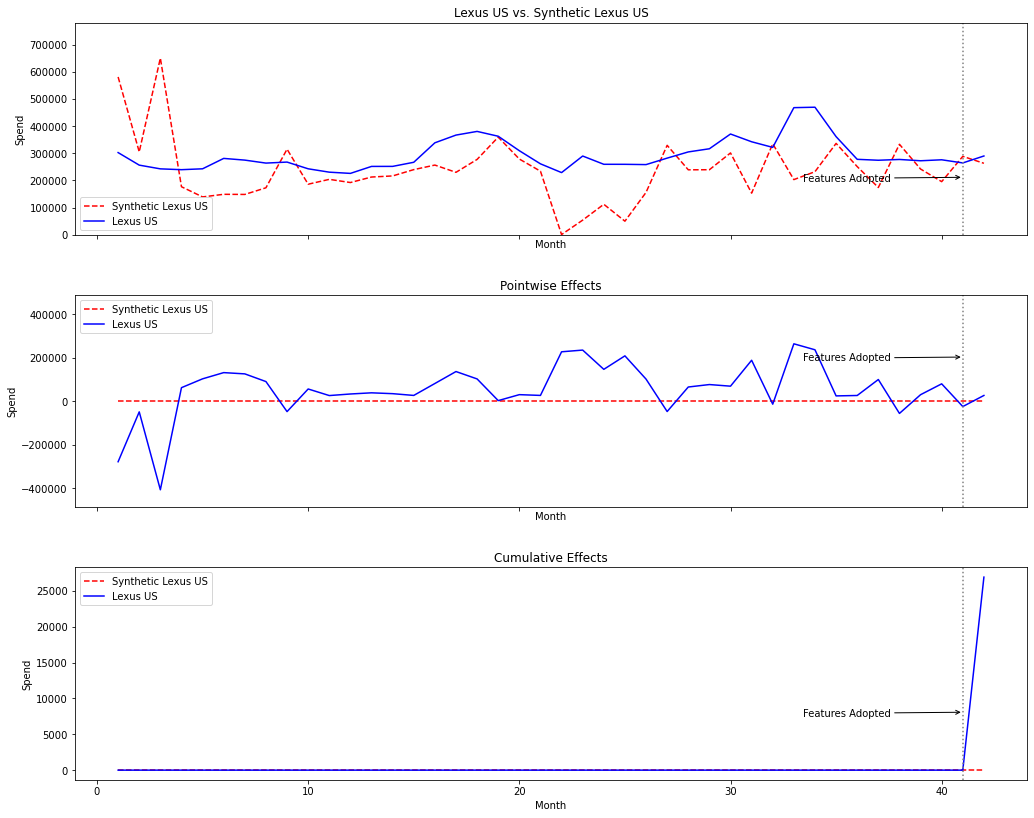

Controls and their weights:
                                        Name   Weight
671423   Jaguar Land Rover North America LLC  0.83233
7008393          Toyota Motor Sales Inc. USA  0.16767
Processing for Customer # 1
Test Customer Id:20, Name:Discover Financial Services LLC, L1:Financial Services & Insurance, L2:Credit Cards, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 8
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 7
Data Set Shape: (294, 5)


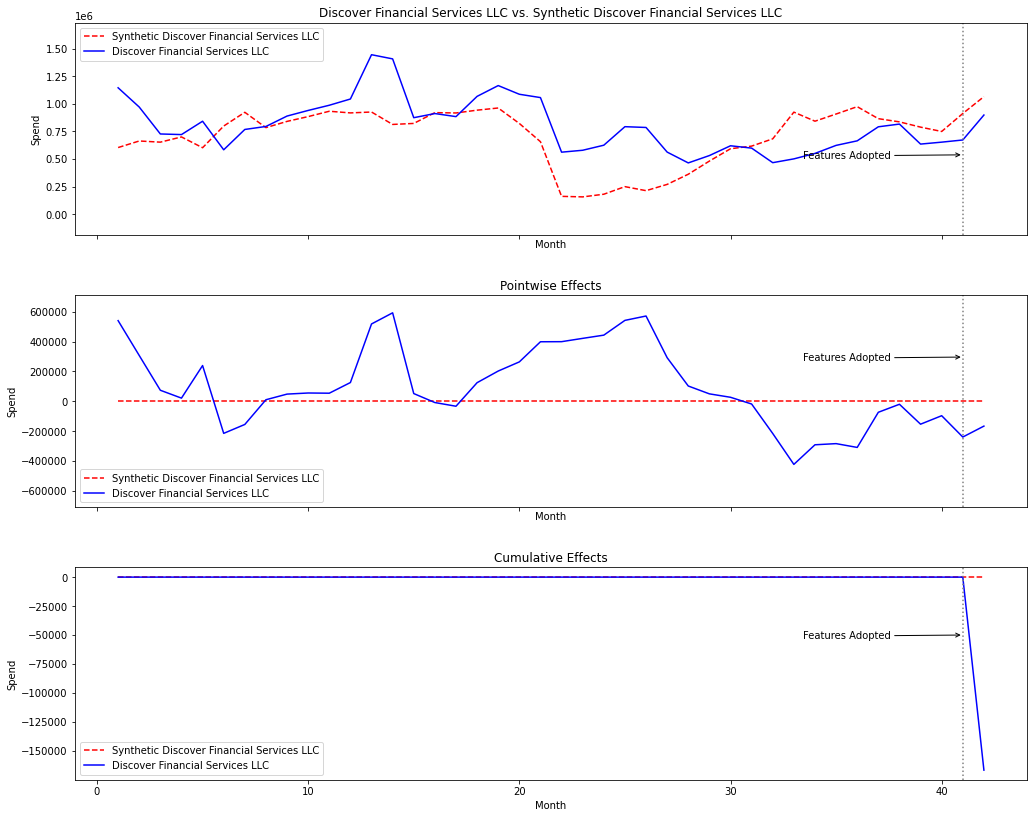

Controls and their weights:
                            Name    Weight
319              JP Morgan Chase  0.667825
2024  Capital One Services, Inc.  0.332175
Processing for Customer # 2
Test Customer Id:191, Name:Lendingtree, LLC, L1:Financial Services & Insurance, L2:Loans & Lending, Segment:Strategic, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 10
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 7
Data Set Shape: (294, 5)


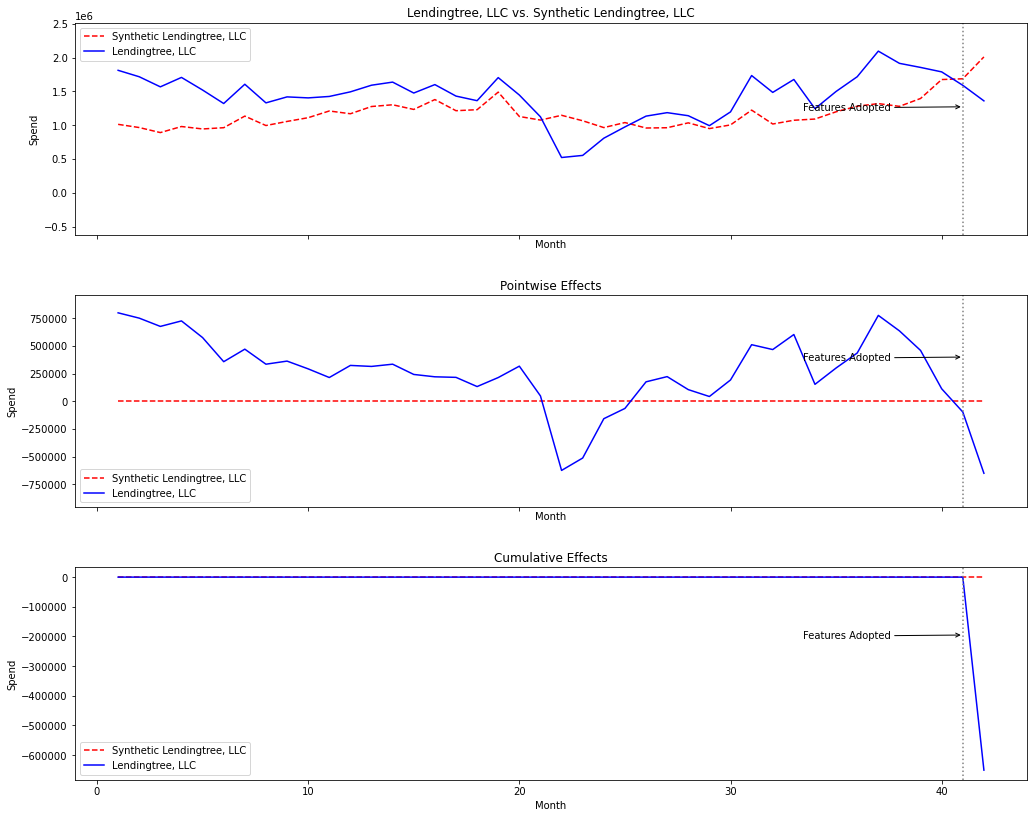

Controls and their weights:
              Name  Weight
212  Quicken Loans     1.0
Processing for Customer # 3
Test Customer Id:690, Name:Stub Hub, L1:Entertainment, L2:Events & Tickets, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 24
Number of Months test data available: 35
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 4
Data Set Shape: (140, 5)


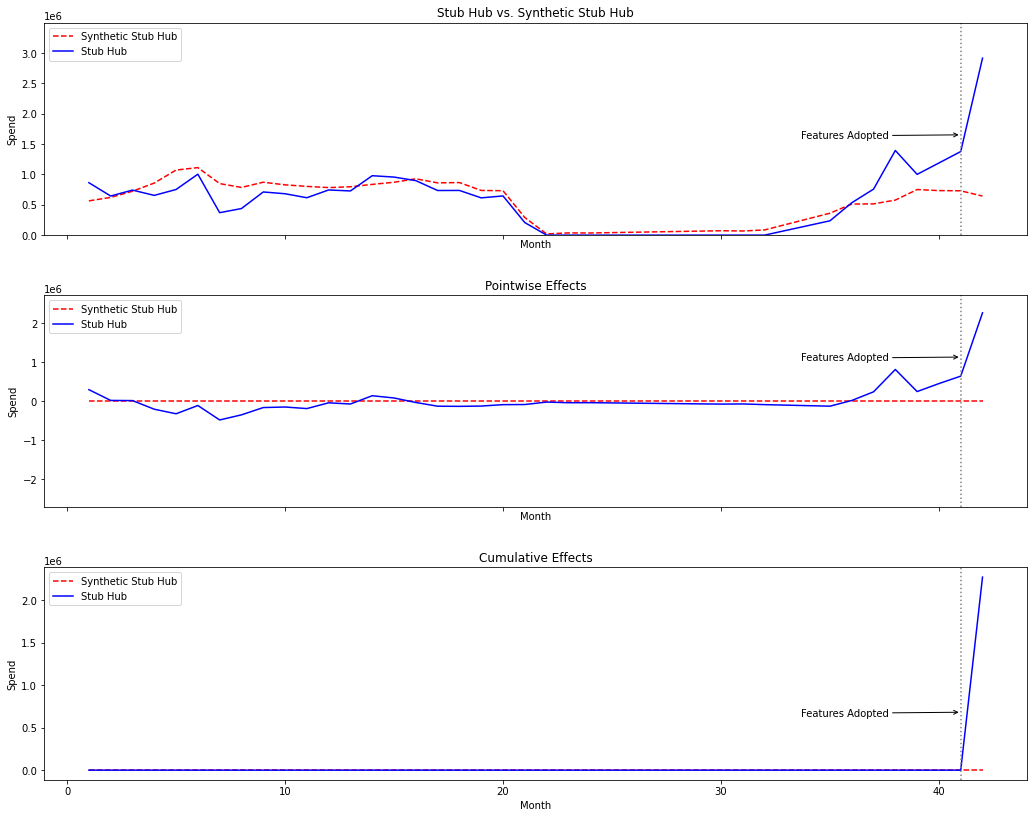

Controls and their weights:
                     Name    Weight
661018   Vivid Seats Ltd.  0.311802
1054393   Viagogo Limited  0.688198
Processing for Customer # 4
Test Customer Id:698, Name:Dow Jones & Company, Inc., L1:Entertainment, L2:Media, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 6
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 4
Data Set Shape: (168, 5)


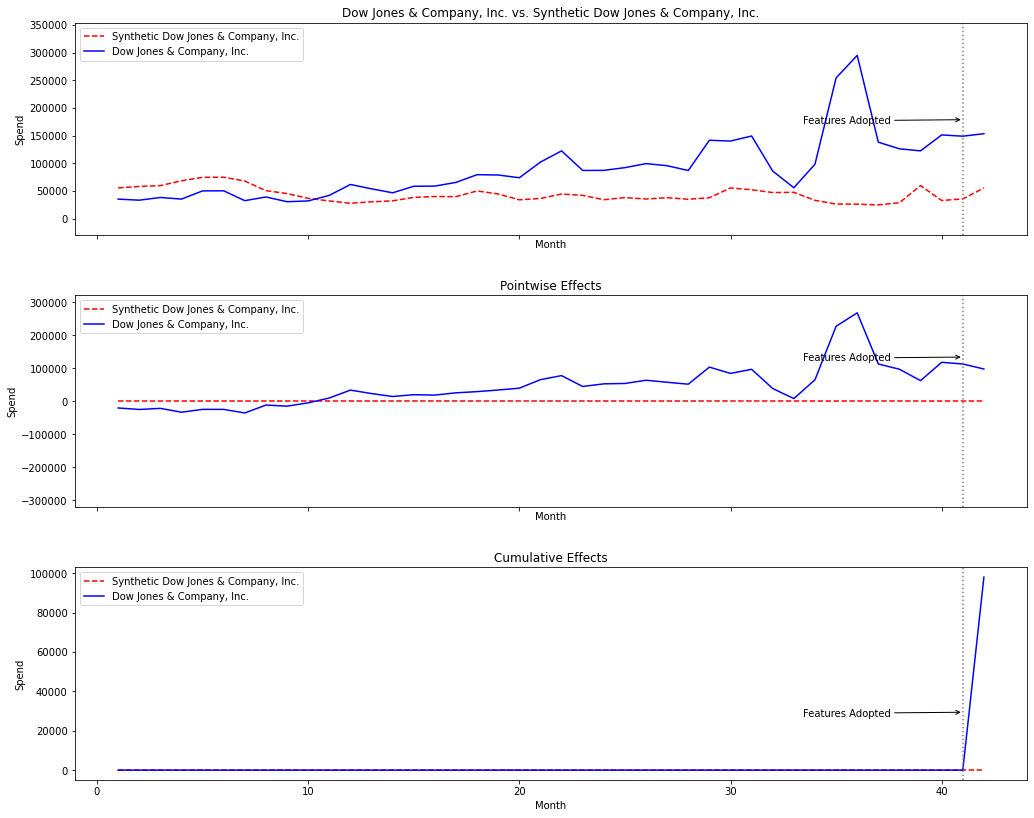

Controls and their weights:
             Name  Weight
7541  Contrix Inc     1.0
Processing for Customer # 5
Test Customer Id:1795, Name:Consensus Cloud Services, L1:Technology & Telecommunications, L2:Software, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 42
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 31
Data Set Shape: (1302, 5)


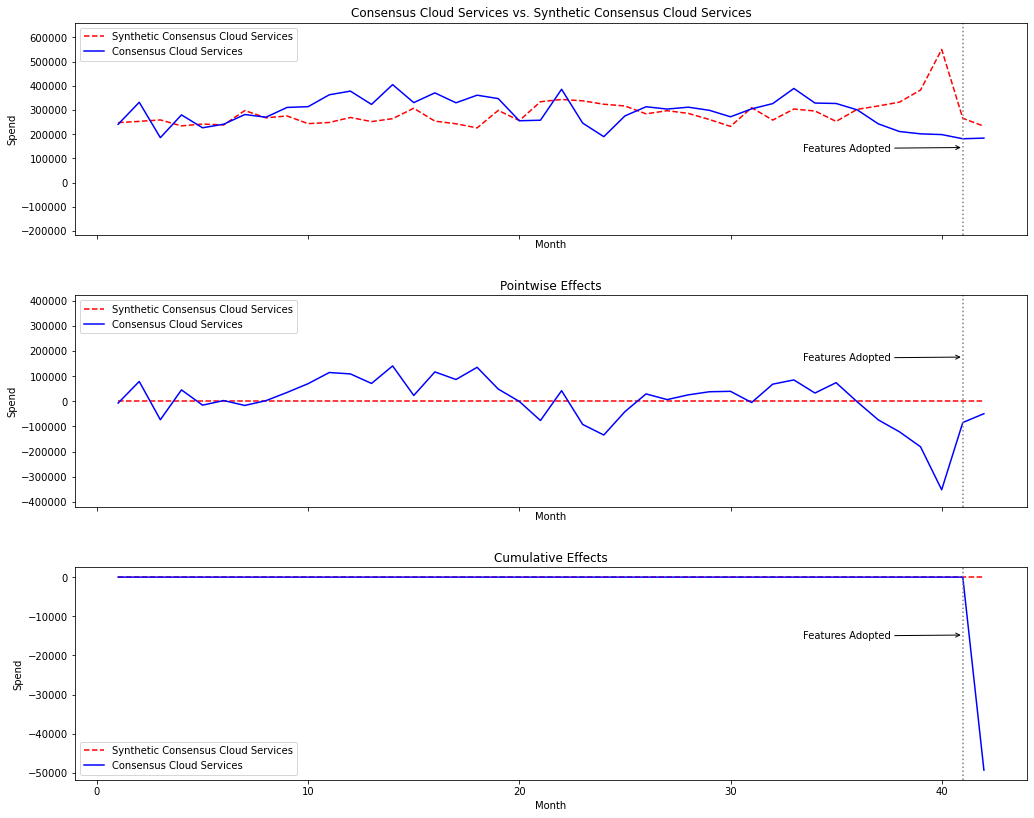

Controls and their weights:
                   Name    Weight
10398          NetSuite  0.045565
350519    airSlate, Inc  0.132250
11057145  Dropbox, Inc.  0.822186
Processing for Customer # 6
Test Customer Id:1962, Name:Devry, Inc., L1:Careers & Education, L2:Education, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 79
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 45
Data Set Shape: (1890, 5)


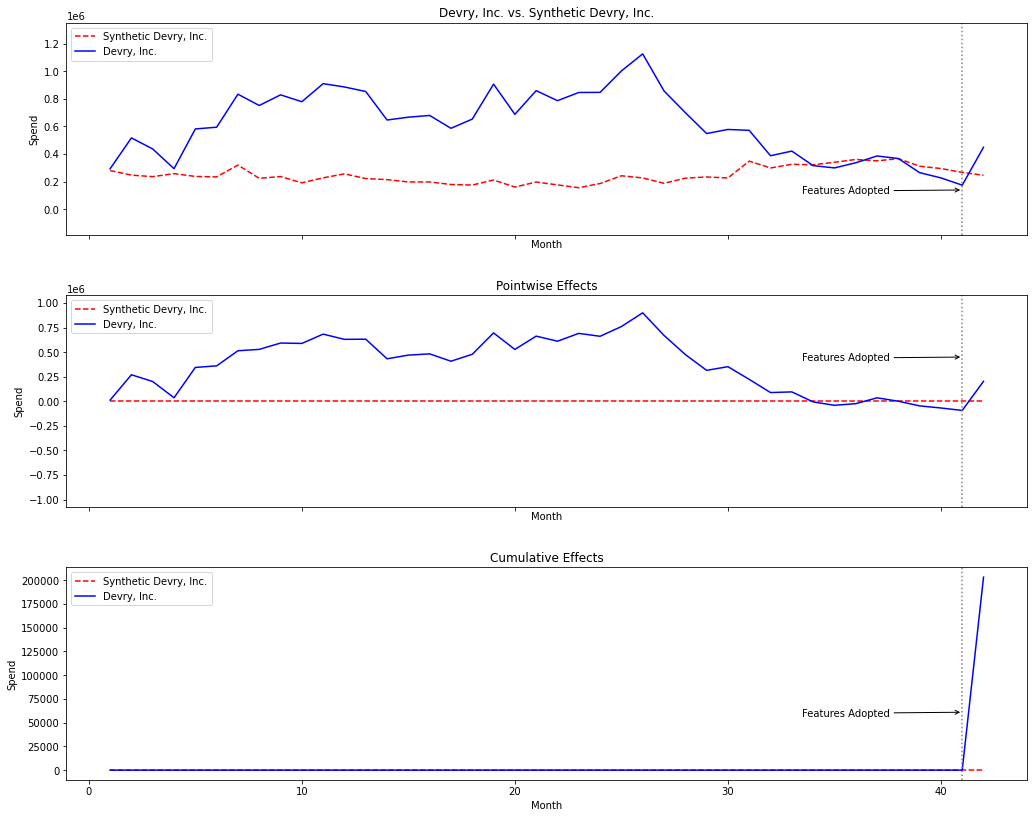

Controls and their weights:
                                      Name    Weight
563300           Compass Knowledge Group 1  0.623664
2075226  Southern New Hampshire University  0.376336
Processing for Customer # 7
Test Customer Id:2214, Name:Pfizer Inc Ny, L1:Health & Wellness, L2:Pharma - Rx, Segment:Strategic, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 14
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 10
Data Set Shape: (420, 5)


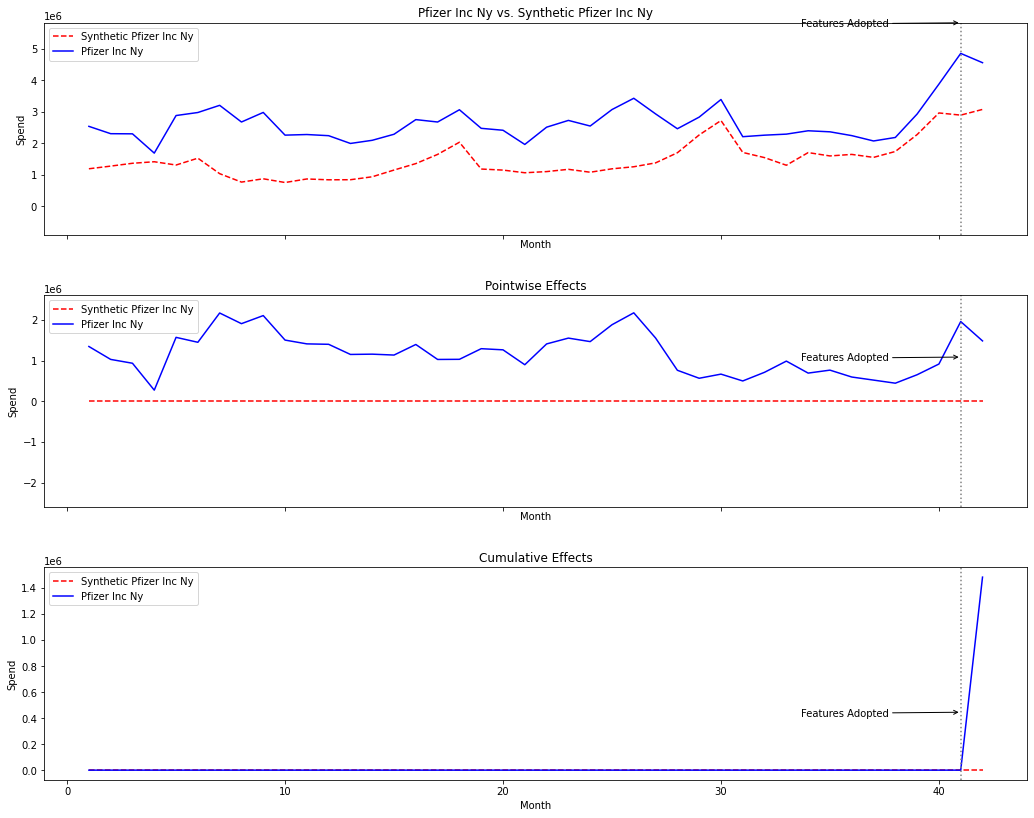

Controls and their weights:
                 Name  Weight
21  Johnson & Johnson     1.0
Processing for Customer # 8
Test Customer Id:2409, Name:Office Depot, L1:Retail, L2:Business, Industrial & Office, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 32
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 28
Data Set Shape: (1176, 5)


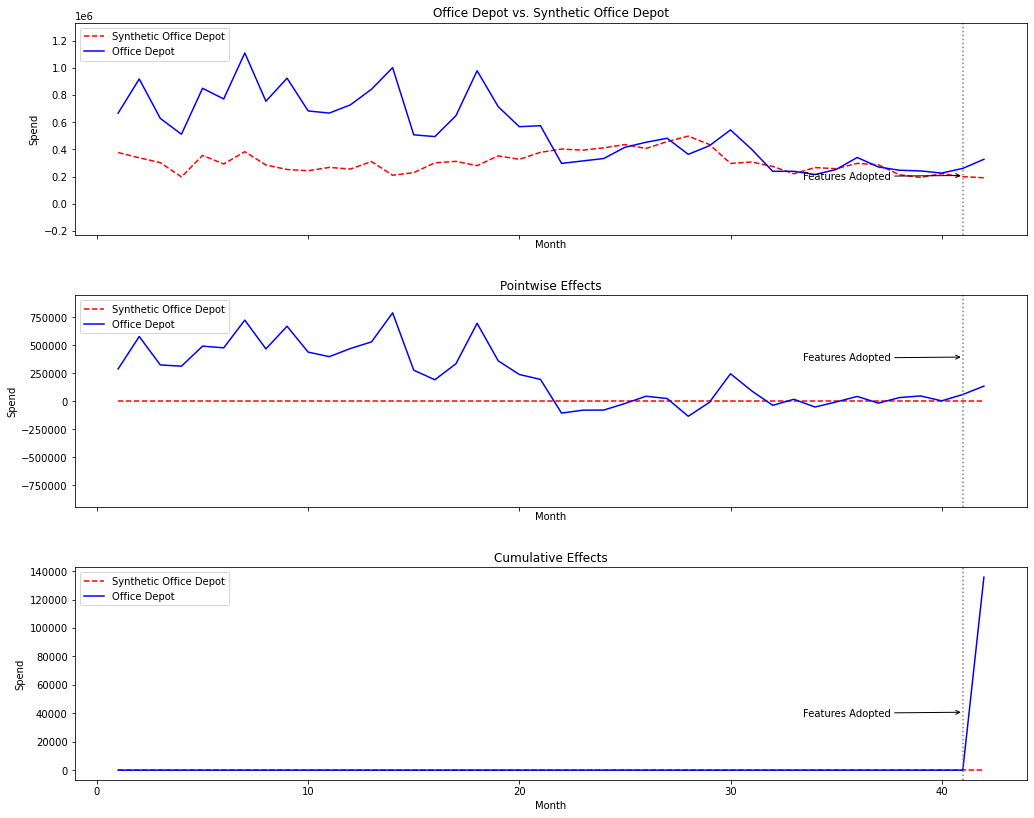

Controls and their weights:
            Name  Weight
43  Staples Inc.     1.0
Processing for Customer # 9
Test Customer Id:2426, Name:Wayfair LLC, L1:Retail, L2:Home & Garden, Segment:Strategic, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 28
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 23
Data Set Shape: (966, 5)


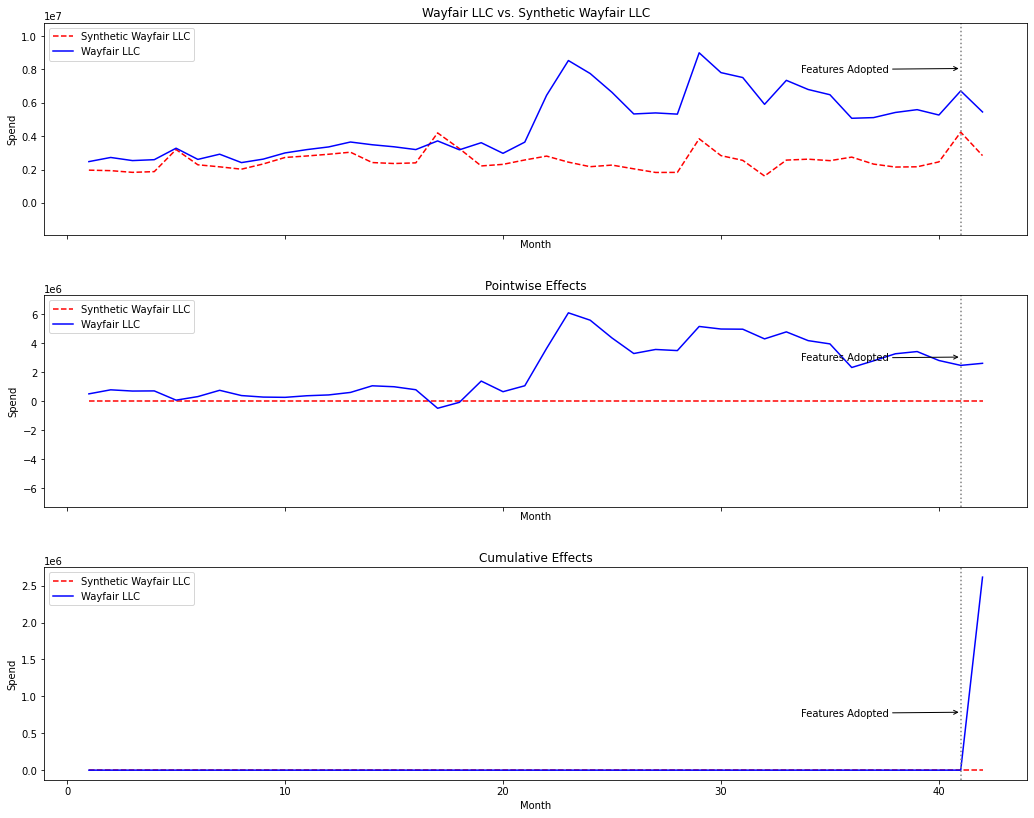

Controls and their weights:
                       Name  Weight
489  Home Depot U.S.A. Inc.     1.0
Processing for Customer # 10
Test Customer Id:4289, Name:SA ENGIE, L1:B2C Services, L2:Utilities, Segment:Enterprise, Country:France
Number of customers in the pool before excluding all treated customers and test months data : 5
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 3
Data Set Shape: (126, 5)


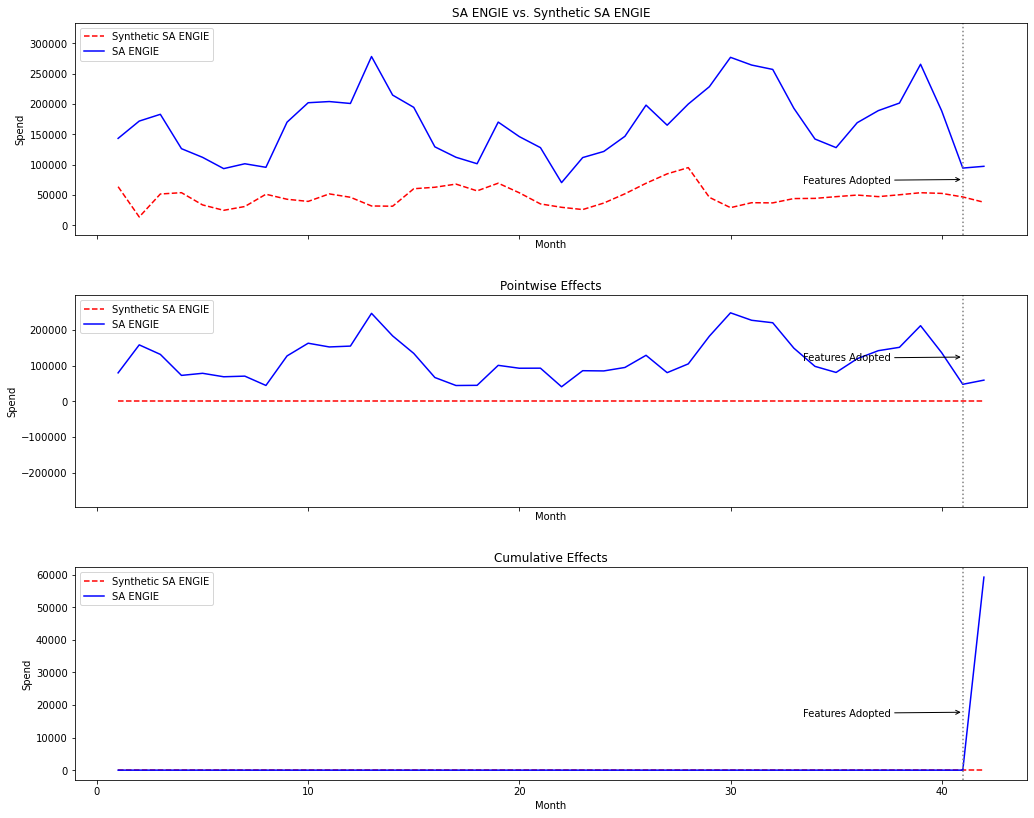

Controls and their weights:
           Name  Weight
13223  EDF - FR     1.0
Processing for Customer # 11
Test Customer Id:7509, Name:Enterprise Holdings, Inc, L1:Travel & Transportation, L2:Land Transportation, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 5
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 3
Data Set Shape: (126, 5)


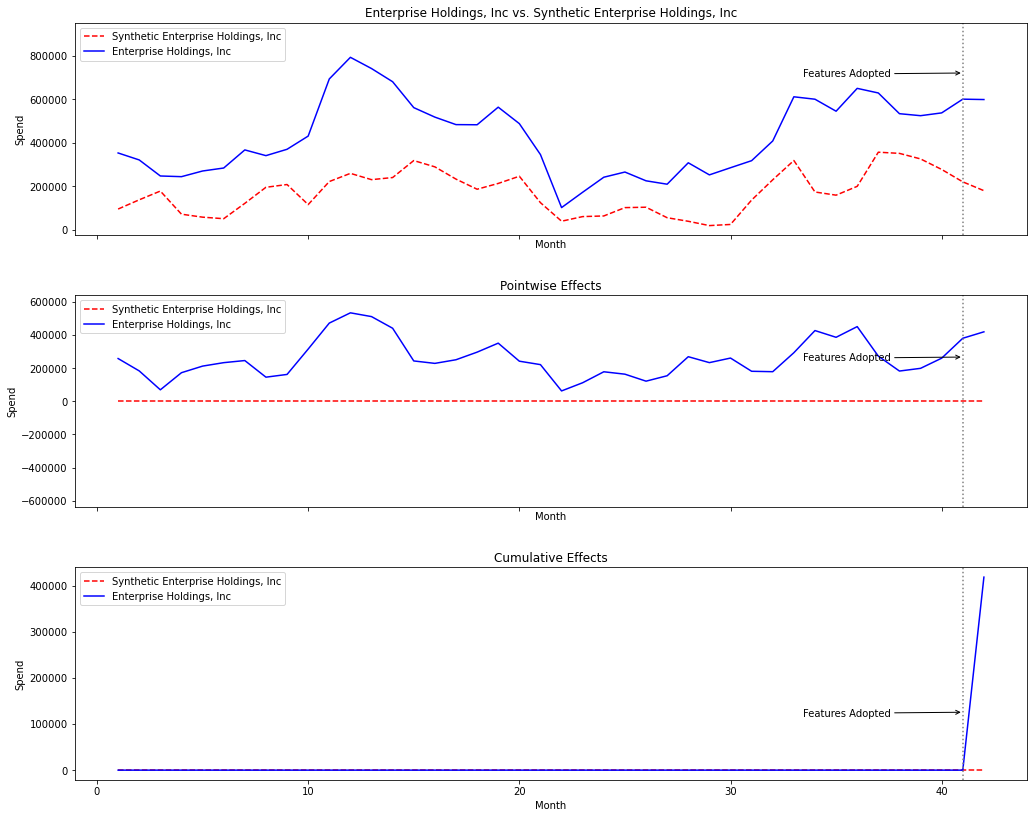

Controls and their weights:
                                 Name  Weight
4569  Budget Rent A Car Systems, Inc.     1.0
Processing for Customer # 12
Test Customer Id:11389, Name:Capterra Inc, L1:Technology & Telecommunications, L2:Software, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 42
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 31
Data Set Shape: (1302, 5)


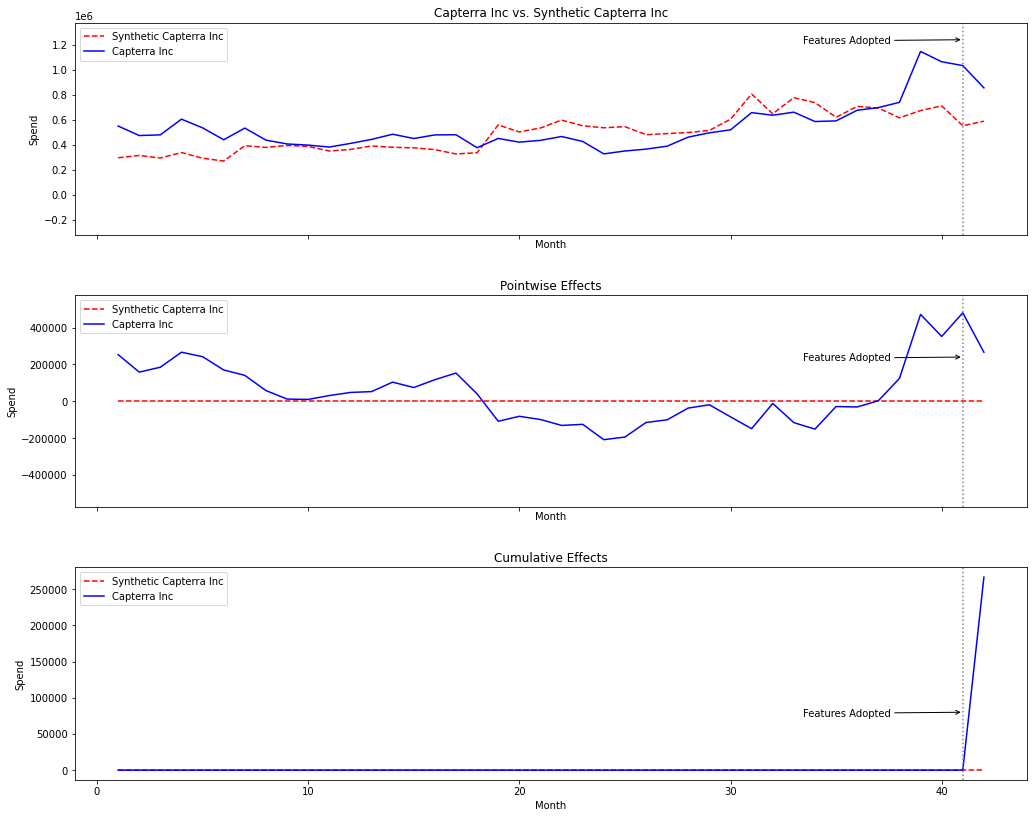

Controls and their weights:
                   Name    Weight
10398          NetSuite  0.301625
350519    airSlate, Inc  0.544031
11057145  Dropbox, Inc.  0.154344
Processing for Customer # 13
Test Customer Id:12767, Name:FactoryOutletStore.com, L1:Retail, L2:Consumer Electronics, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 10
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 9
Data Set Shape: (378, 5)


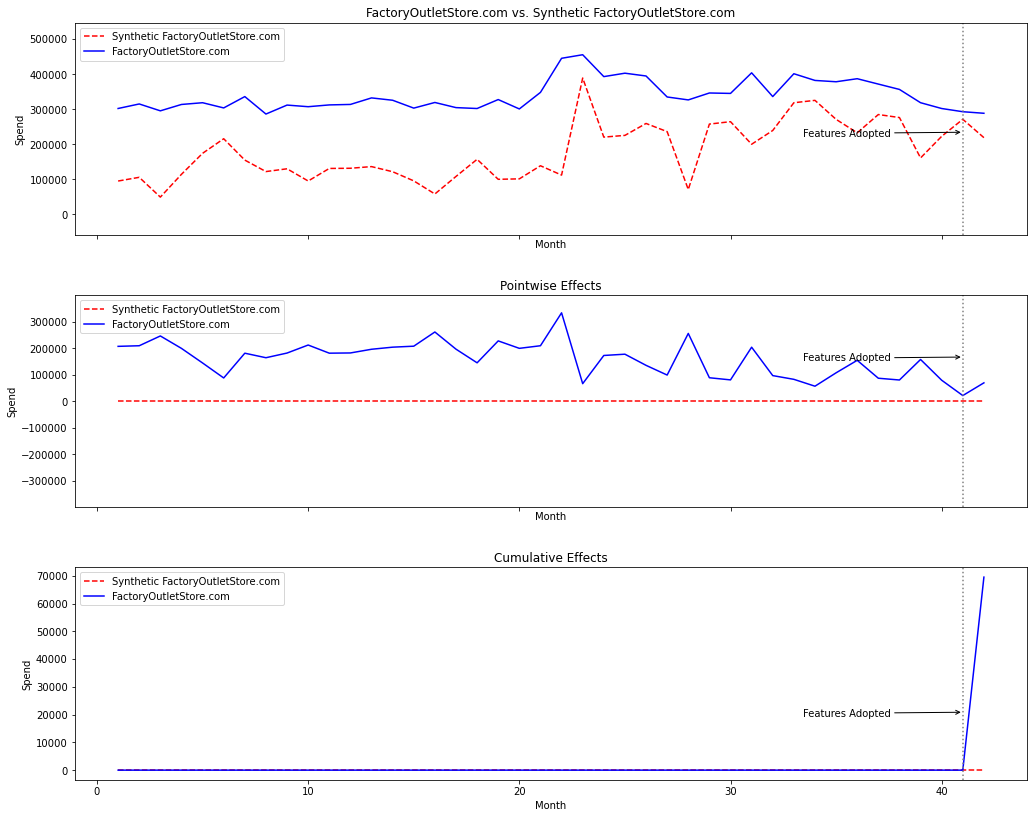

Controls and their weights:
                      Name  Weight
30136  B&H Photo and Video     1.0
Processing for Customer # 14
Test Customer Id:17850, Name:Discountmugs.com, L1:Retail, L2:Business, Industrial & Office, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 32
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 28
Data Set Shape: (1176, 5)


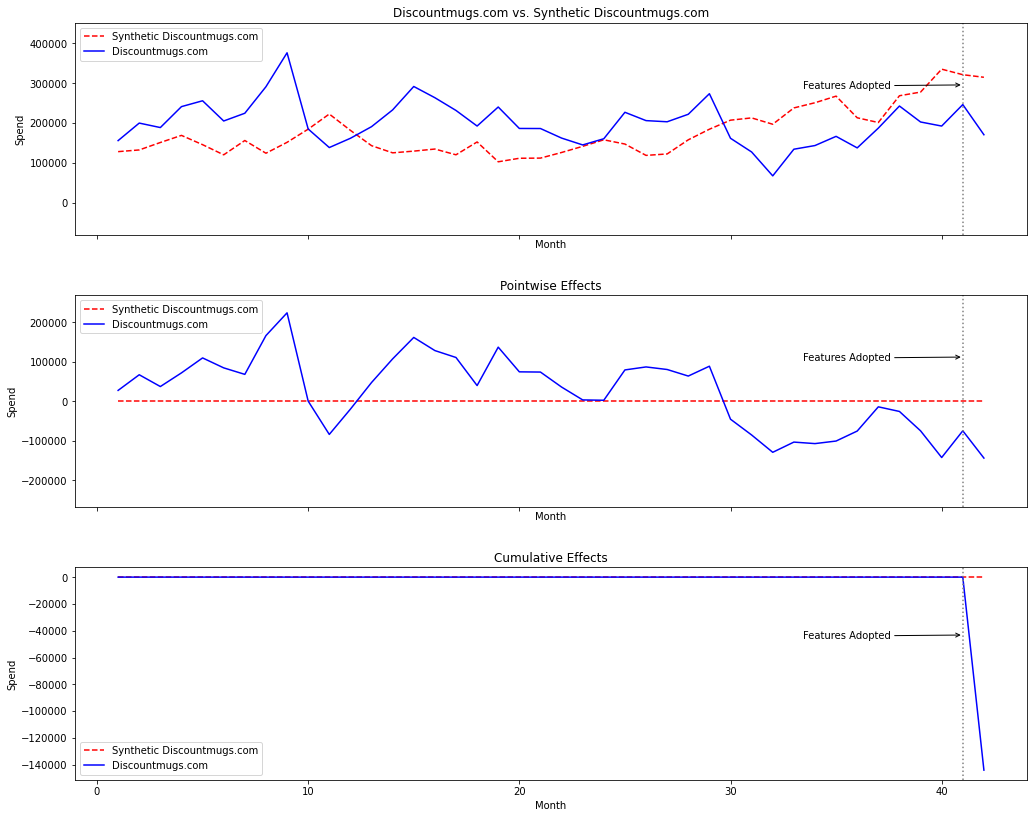

Controls and their weights:
                      Name    Weight
2069431               Zoro  0.307487
168422752  TRT Banners LLC  0.692513
Processing for Customer # 15
Test Customer Id:19645, Name:Budge Industries, LLC dba EmpireCovers.com, L1:Autos, L2:Parts & Service, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 38
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 32
Data Set Shape: (1344, 5)


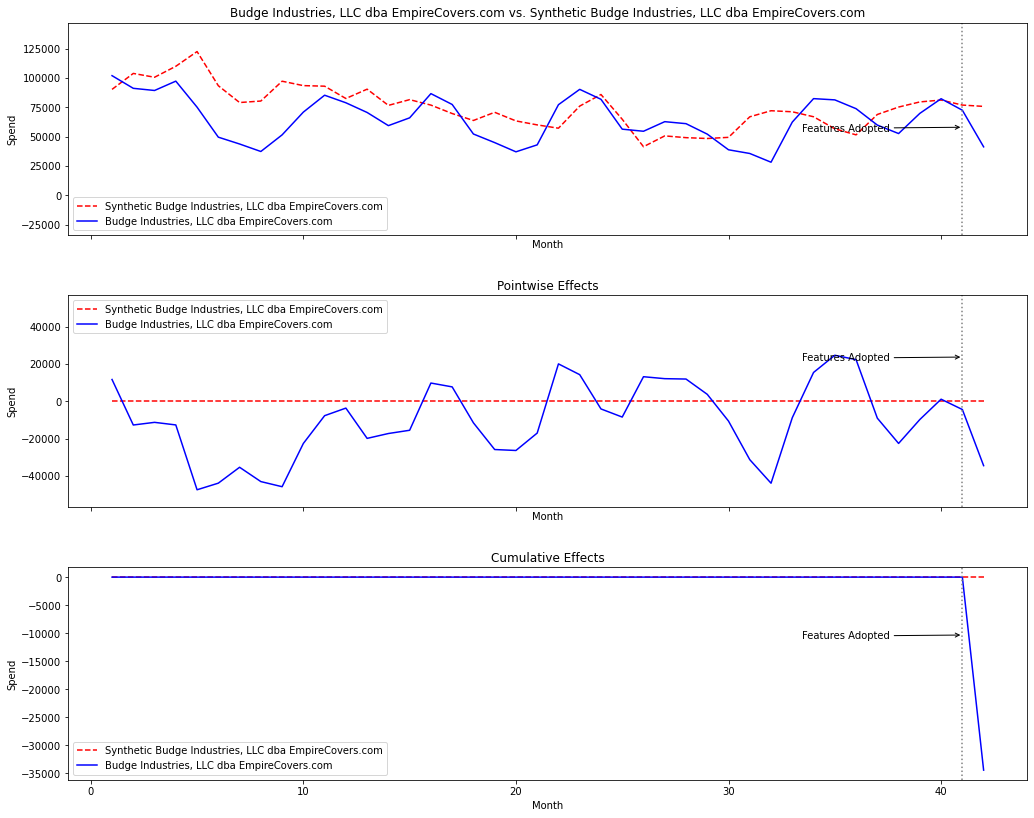

Controls and their weights:
                          Name    Weight
256873  Pods Enterprises, Inc.  0.582314
492414                AutoZone  0.264839
557798         Belron US, Inc.  0.152847
Processing for Customer # 16
Test Customer Id:20674, Name:Mavis Discount Tire, L1:Autos, L2:Parts & Service, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 38
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 32
Data Set Shape: (1344, 5)


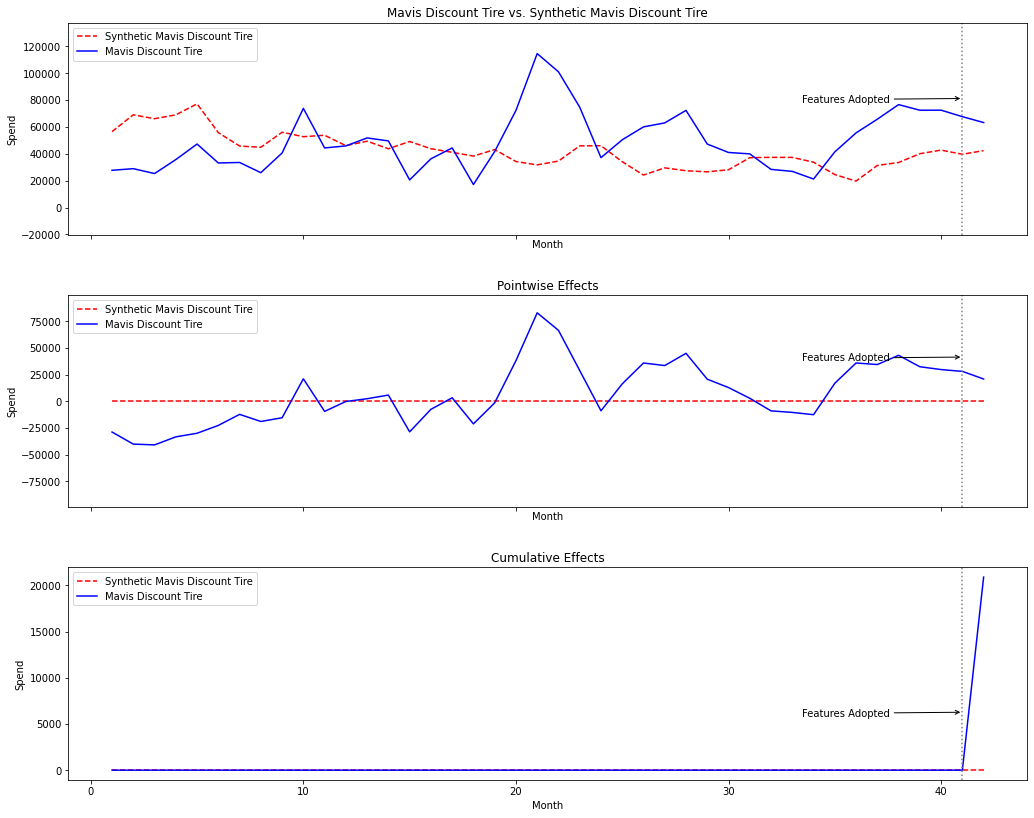

Controls and their weights:
                          Name    Weight
256873  Pods Enterprises, Inc.  0.282459
264768            AM-AutoParts  0.472750
492414                AutoZone  0.244790
Processing for Customer # 17
Test Customer Id:37680, Name:Kate Spade, L1:Retail, L2:Apparel & Accessories, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 121
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 99
Data Set Shape: (4158, 5)


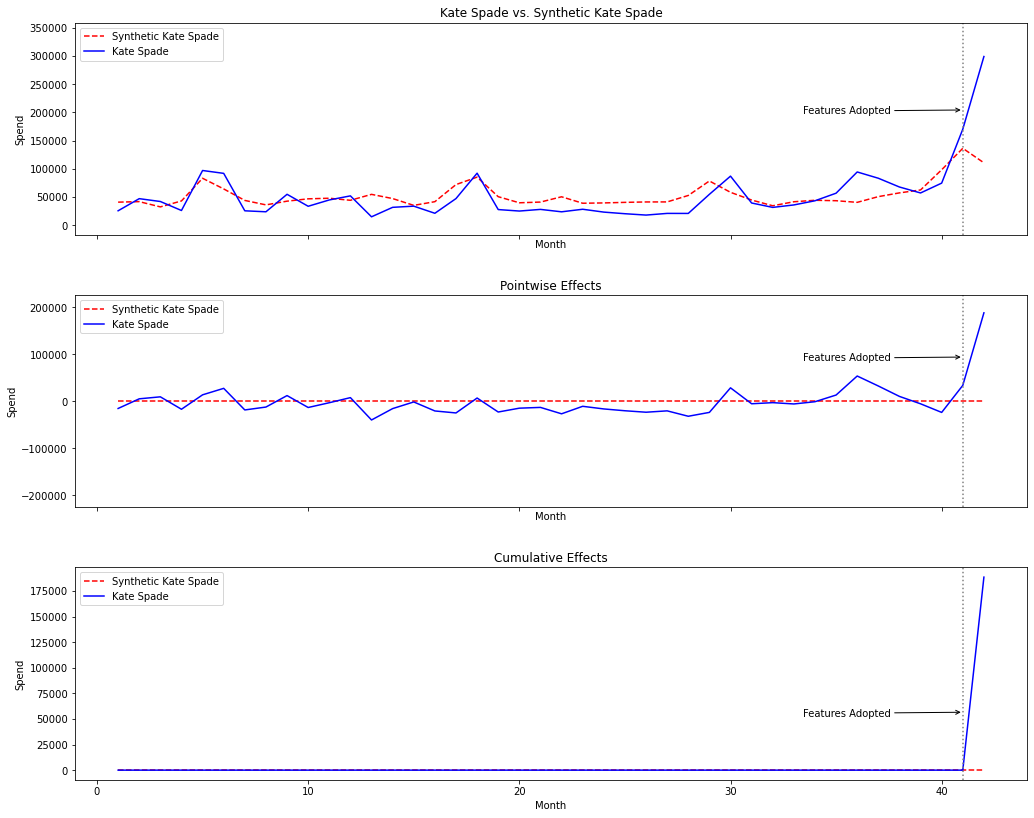

Controls and their weights:
                                Name    Weight
54342                      Joann.com  0.371181
3013237  Abercrombie & Fitch Company  0.628819
Processing for Customer # 18
Test Customer Id:41460, Name:La-Z-Boy, Inc., L1:Retail, L2:Home & Garden, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 40
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 35
Data Set Shape: (1470, 5)


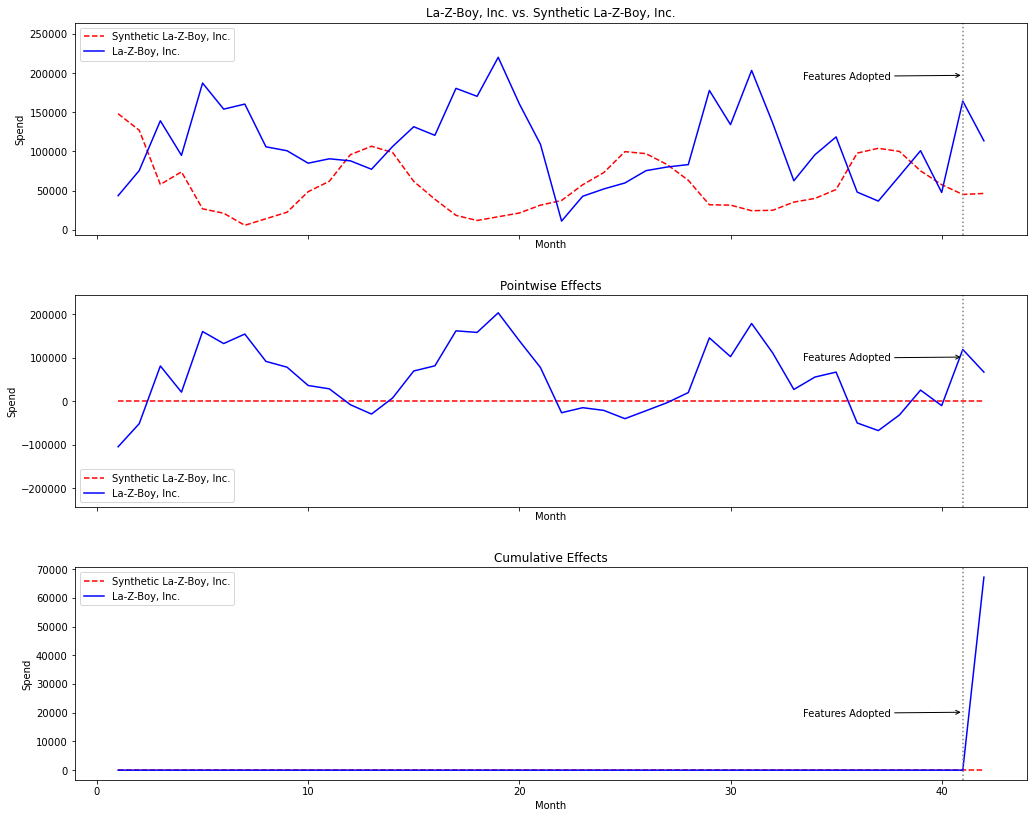

Controls and their weights:
                       Name    Weight
424120     Sherwin-Williams  0.434368
18172221  ShippingEasy Inc.  0.565632
Processing for Customer # 19
Test Customer Id:47840, Name:FreePeople.com, L1:Retail, L2:Apparel & Accessories, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 121
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 99
Data Set Shape: (4158, 5)


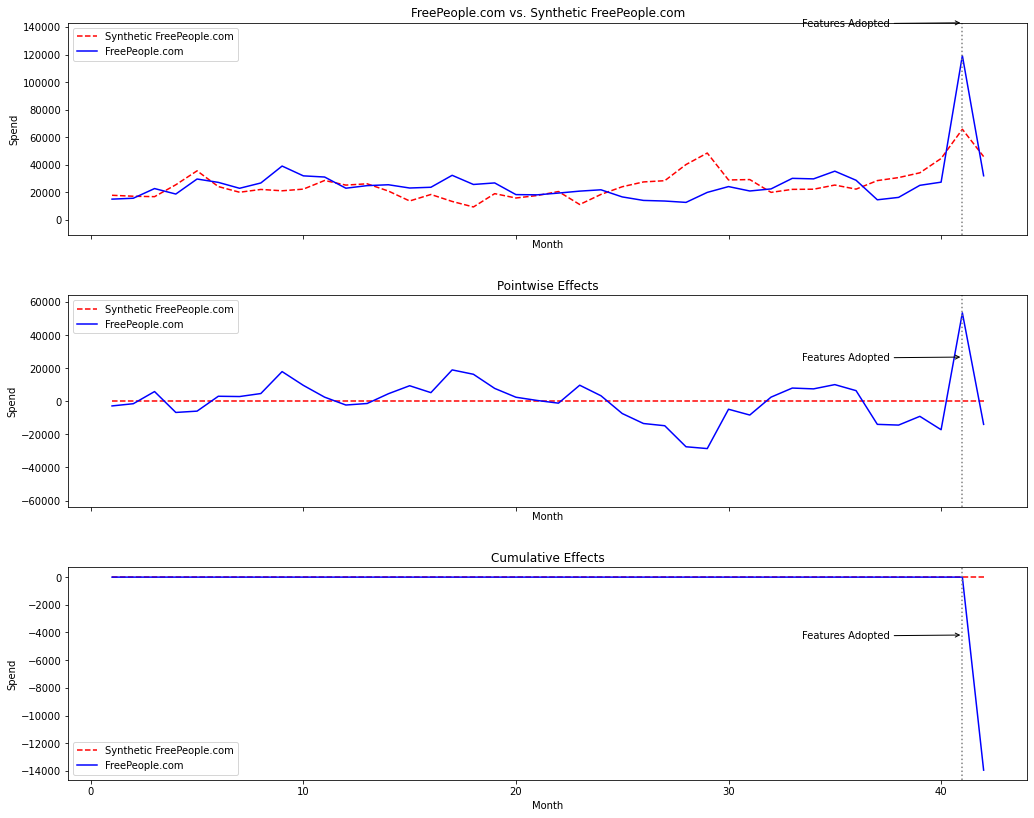

Controls and their weights:
                               Name    Weight
54342                     Joann.com  0.520965
15262102  Wisconsin Harley-Davidson  0.479035
Processing for Customer # 20
Test Customer Id:181912, Name:Jet2 - UK, L1:Travel & Transportation, L2:OTA/ Meta Engine, Segment:Enterprise, Country:United Kingdom
Number of customers in the pool before excluding all treated customers and test months data : 22
Number of Months test data available: 39
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 9
Data Set Shape: (351, 5)


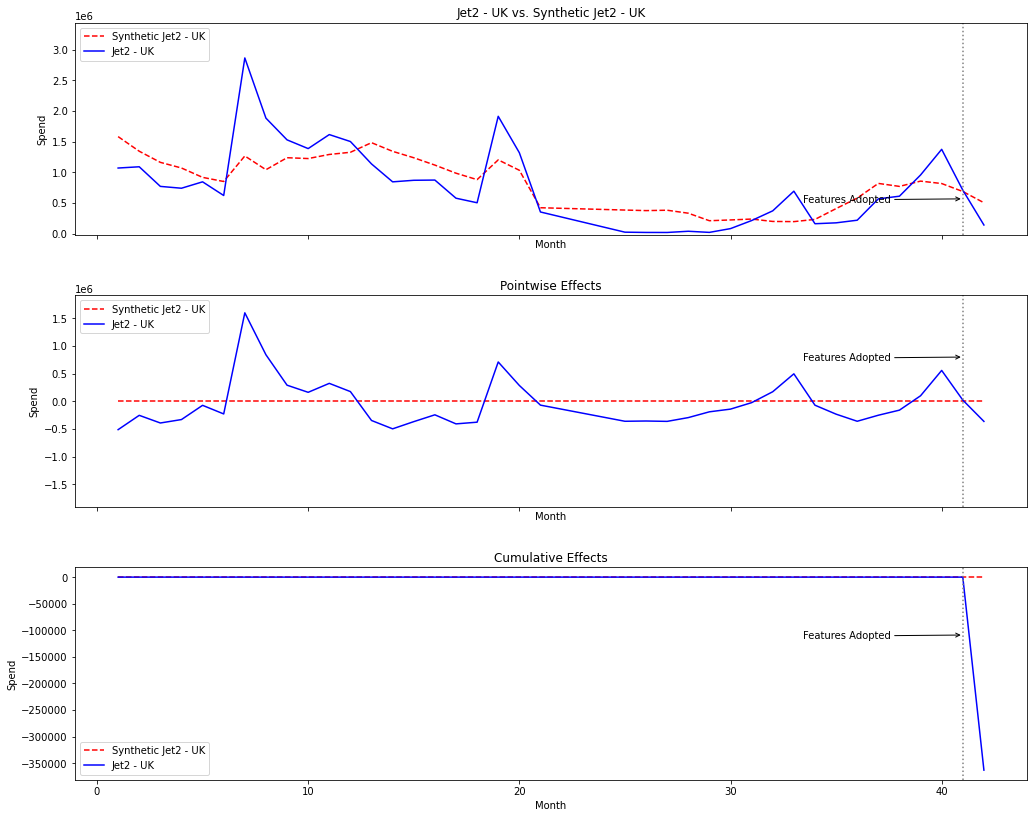

Controls and their weights:
                      Name  Weight
11401601  Traveljigsaw Ltd     1.0
Processing for Customer # 21
Test Customer Id:194086, Name:ASOS.com Limited, L1:Retail, L2:Apparel & Accessories, Segment:Enterprise, Country:United Kingdom
Number of customers in the pool before excluding all treated customers and test months data : 23
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 15
Data Set Shape: (630, 5)


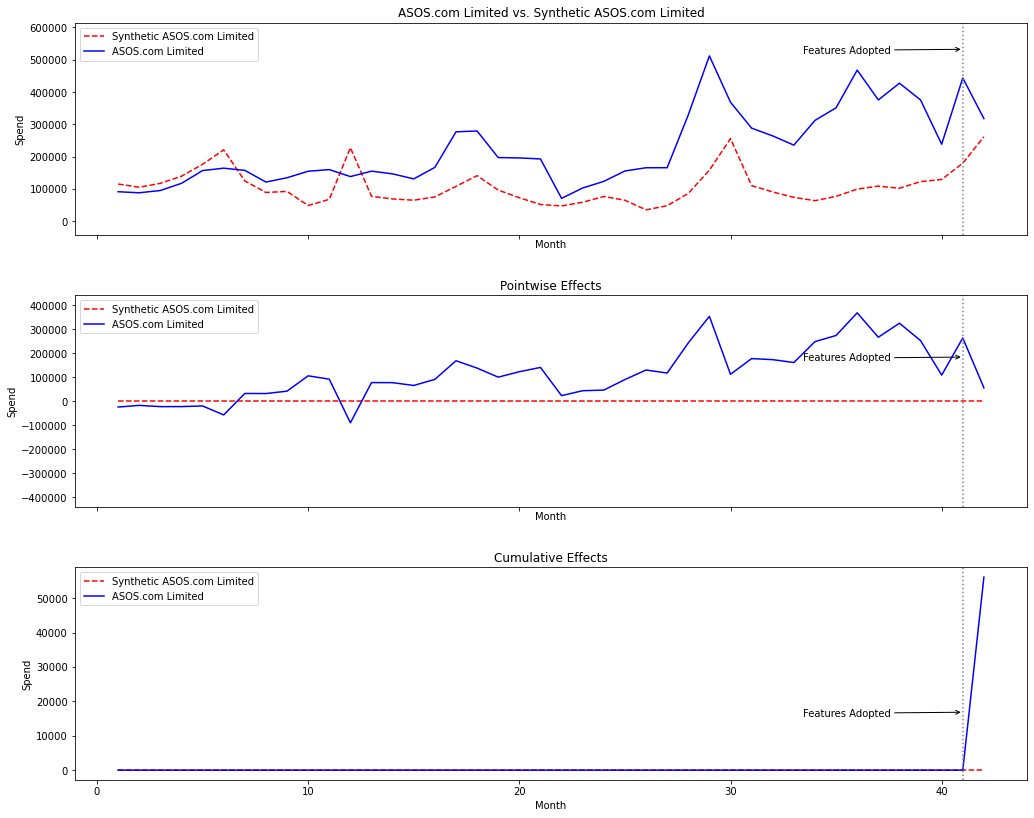

Controls and their weights:
                  Name  Weight
14185237  Lyst Limited     1.0
Processing for Customer # 22
Test Customer Id:661650, Name:EBS - MCC, L1:Travel & Transportation, L2:OTA/ Meta Engine, Segment:Strategic, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 17
Number of Months test data available: 34
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 8
Data Set Shape: (272, 5)


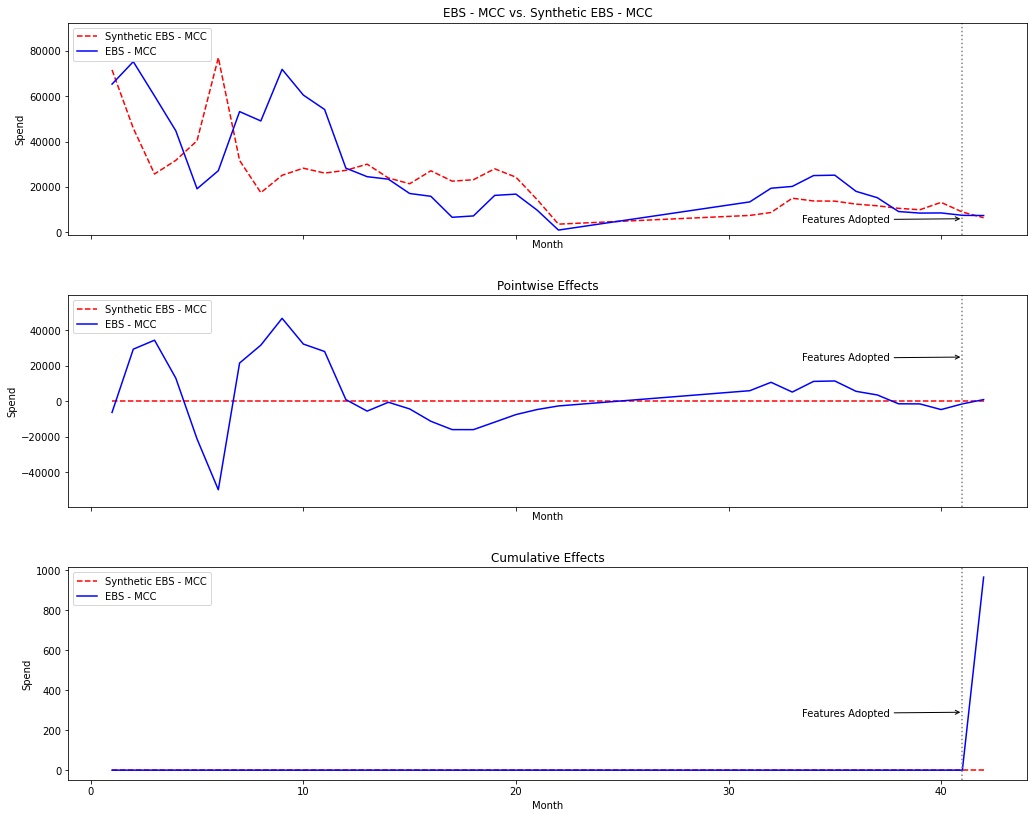

Controls and their weights:
                          Name    Weight
6344      CarRentals.com, Inc.  0.353475
14098218  Travelocity.com L.P.  0.646525
Processing for Customer # 23
Test Customer Id:662587, Name:DocuSign, L1:Technology & Telecommunications, L2:Software, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 42
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 31
Data Set Shape: (1302, 5)


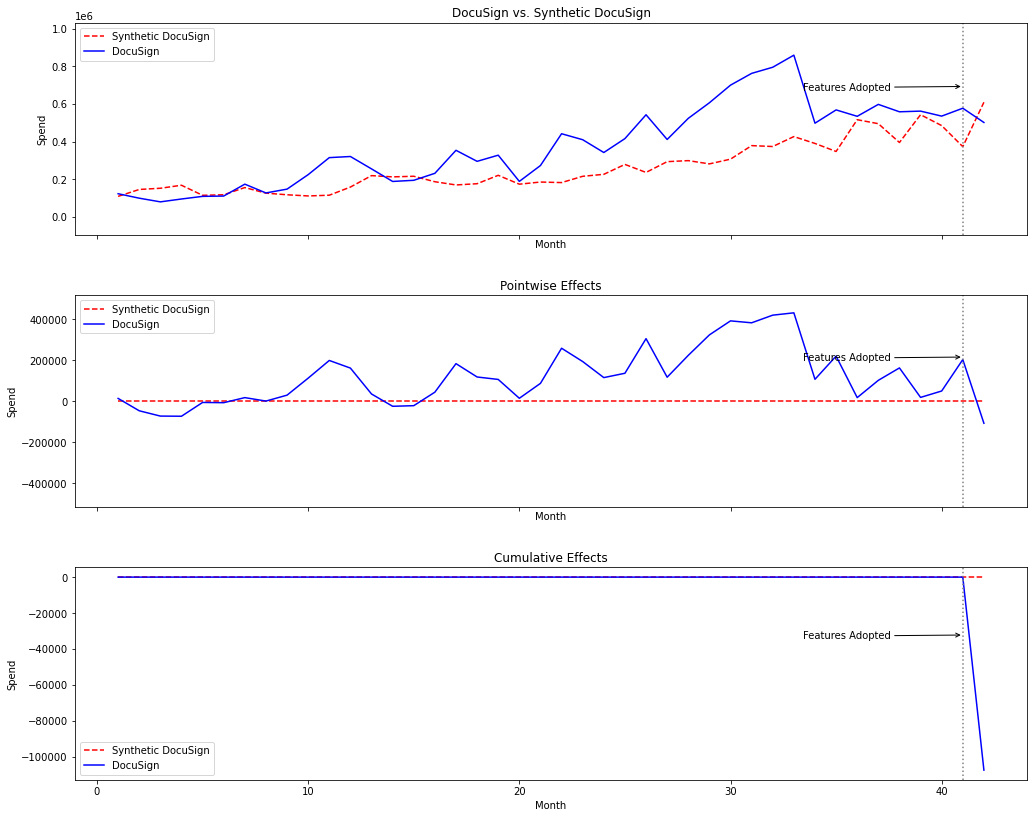

Controls and their weights:
                     Name    Weight
10398            NetSuite  0.530156
5043087  Squarespace, Inc  0.469844
Processing for Customer # 24
Test Customer Id:771818, Name:Rocket Lawyer, L1:B2C Services, L2:Legal Services, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 8
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 3
Data Set Shape: (126, 5)


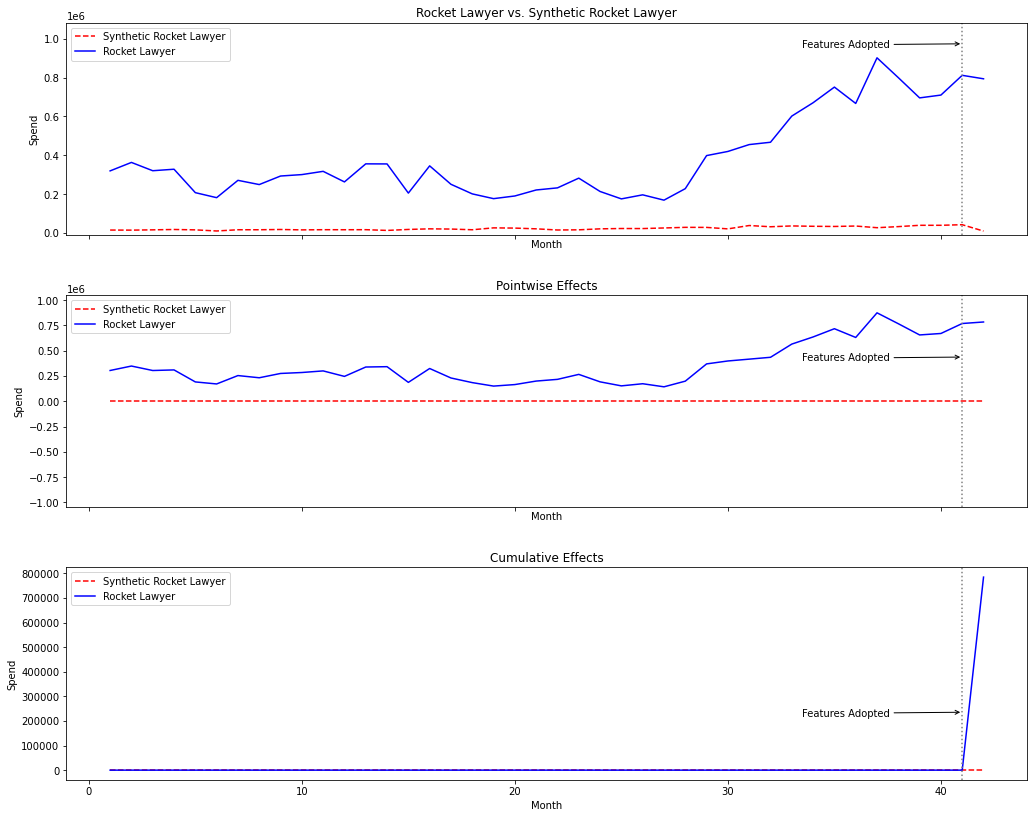

Controls and their weights:
                             Name  Weight
8054058  Rocket Lawyer UK Limited     1.0
Processing for Customer # 25
Test Customer Id:5057990, Name:MediaAlpha, L1:Financial Services & Insurance, L2:Insurance, Segment:Strategic, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 9
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 6
Data Set Shape: (252, 5)


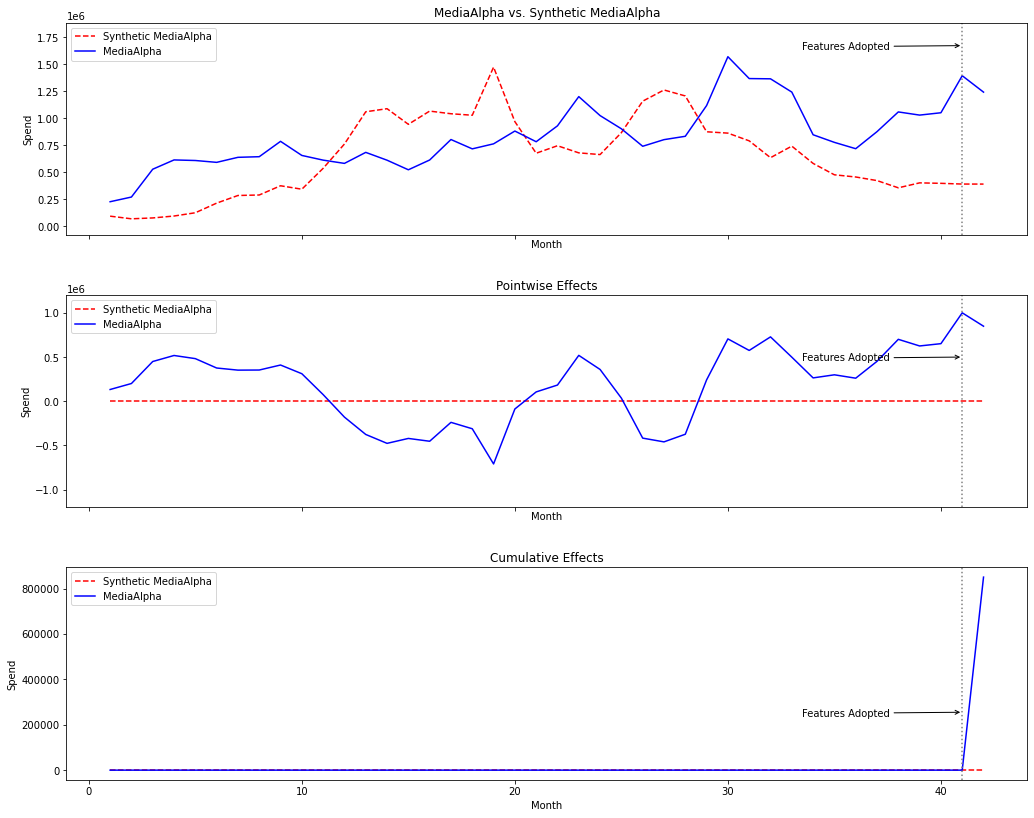

Controls and their weights:
                                 Name   Weight
12829     Progressive Commercial Auto  0.09016
14445975                  QuoteWizard  0.90984
Processing for Customer # 26
Test Customer Id:5127122, Name:Consecionaria Vuela Compañía de Aviacion SAPI de CV, L1:Travel & Transportation, L2:Unspecified, Segment:Corporate, Country:Mexico
Number of customers in the pool before excluding all treated customers and test months data : 5
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 3
Data Set Shape: (126, 5)


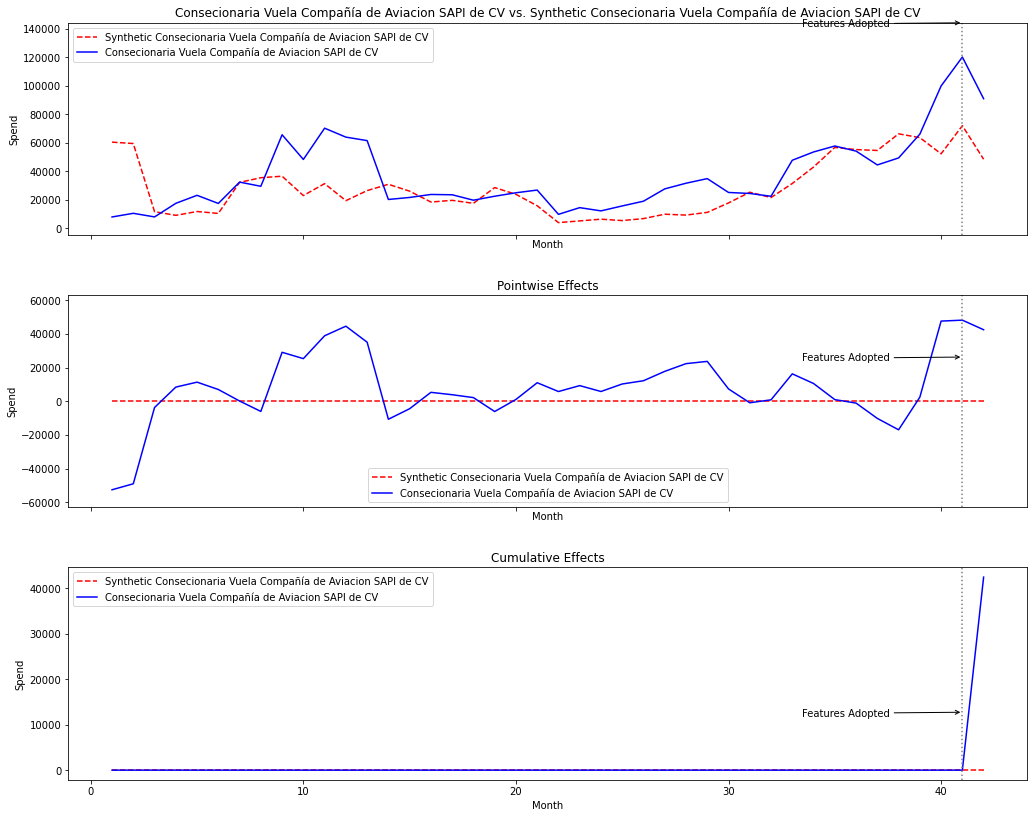

Controls and their weights:
                               Name  Weight
42188868  Marena Intracorp BV, Inc.     1.0
Processing for Customer # 27
Test Customer Id:5143439, Name:Bassett Furniture, L1:Retail, L2:Home & Garden, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 125
Number of Months test data available: 34
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 91
Data Set Shape: (3094, 5)


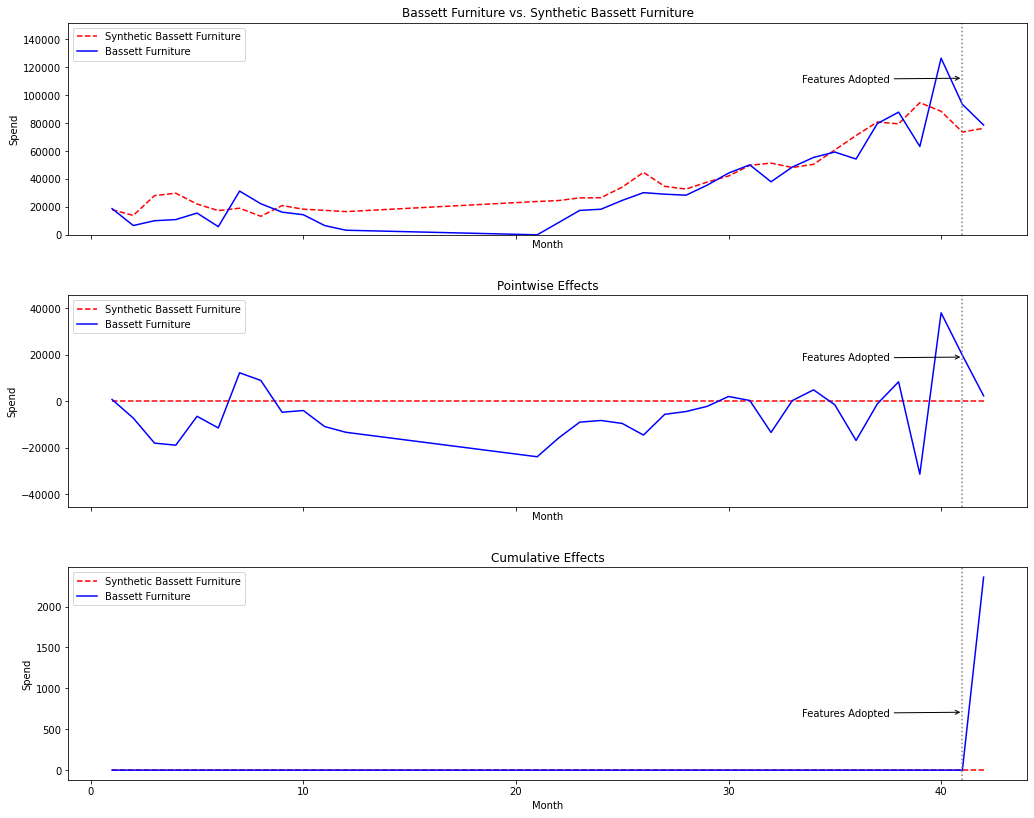

Controls and their weights:
                    Name    Weight
890453      Sunrun, Inc.  0.679588
11019043  Zuri Furniture  0.320412
Processing for Customer # 28
Test Customer Id:7021885, Name:Adverplex7, L1:Financial Services & Insurance, L2:Insurance, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 52
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 34
Data Set Shape: (1428, 5)


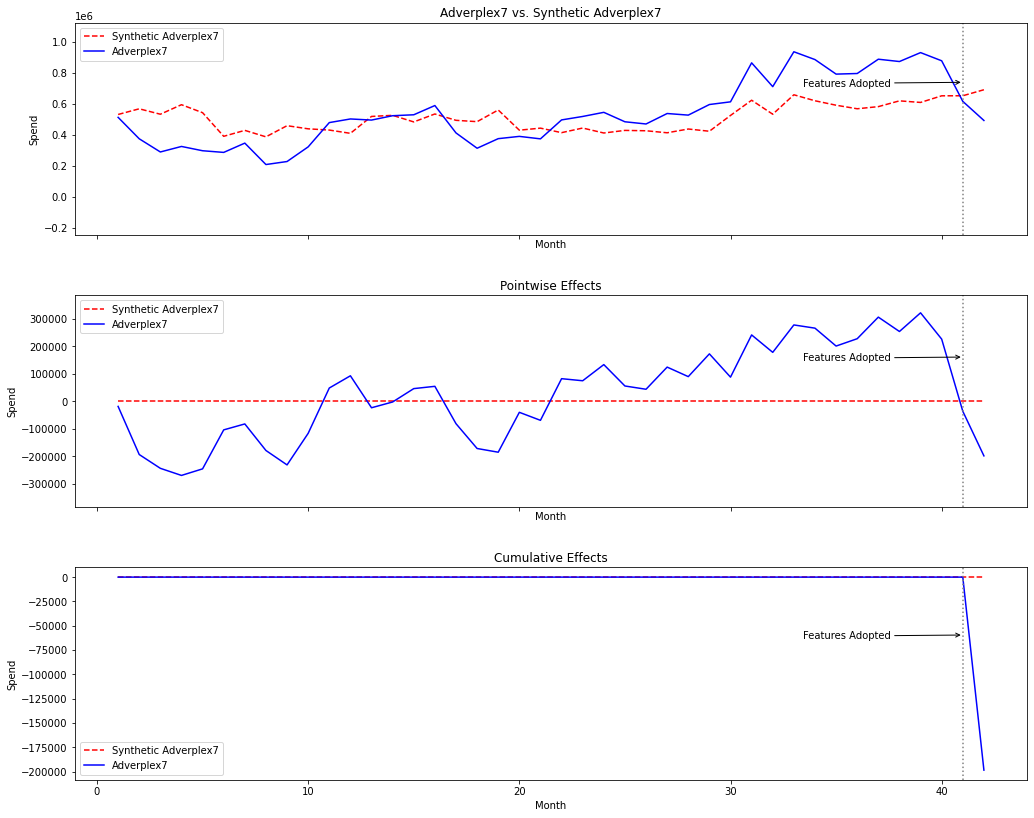

Controls and their weights:
                                     Name    Weight
856826                All Web Leads, Inc.  0.629016
36198985  biBERK Insurance Services, Inc.  0.370984
Processing for Customer # 29
Test Customer Id:11000768, Name:Reservation Desk, L1:Travel & Transportation, L2:Lodging, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 33
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 15
Data Set Shape: (630, 5)


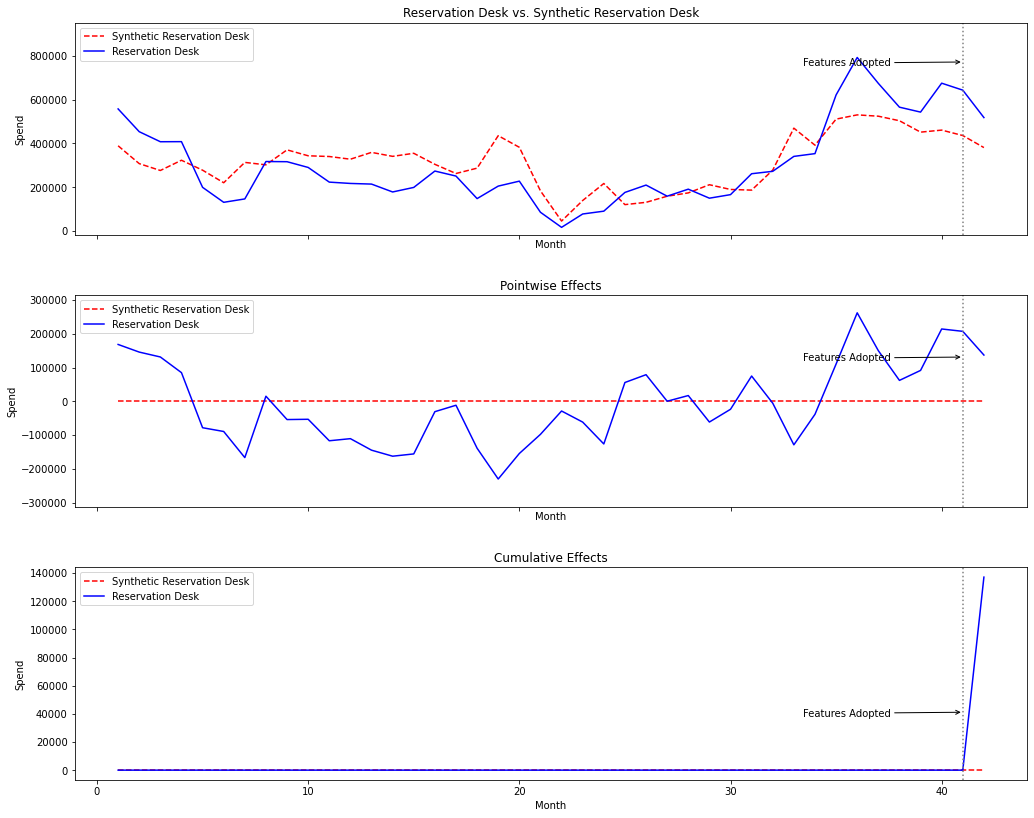

Controls and their weights:
                               Name    Weight
13078498       Wyndham Hotel Group.  0.711395
50175757  Hyper Global Technologies  0.288605
Processing for Customer # 30
Test Customer Id:11061936, Name:ALBELLI, L1:B2C Services, L2:Photography, Segment:Enterprise, Country:Netherlands (the)
Number of customers in the pool before excluding all treated customers and test months data : 3
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 3
Data Set Shape: (126, 5)


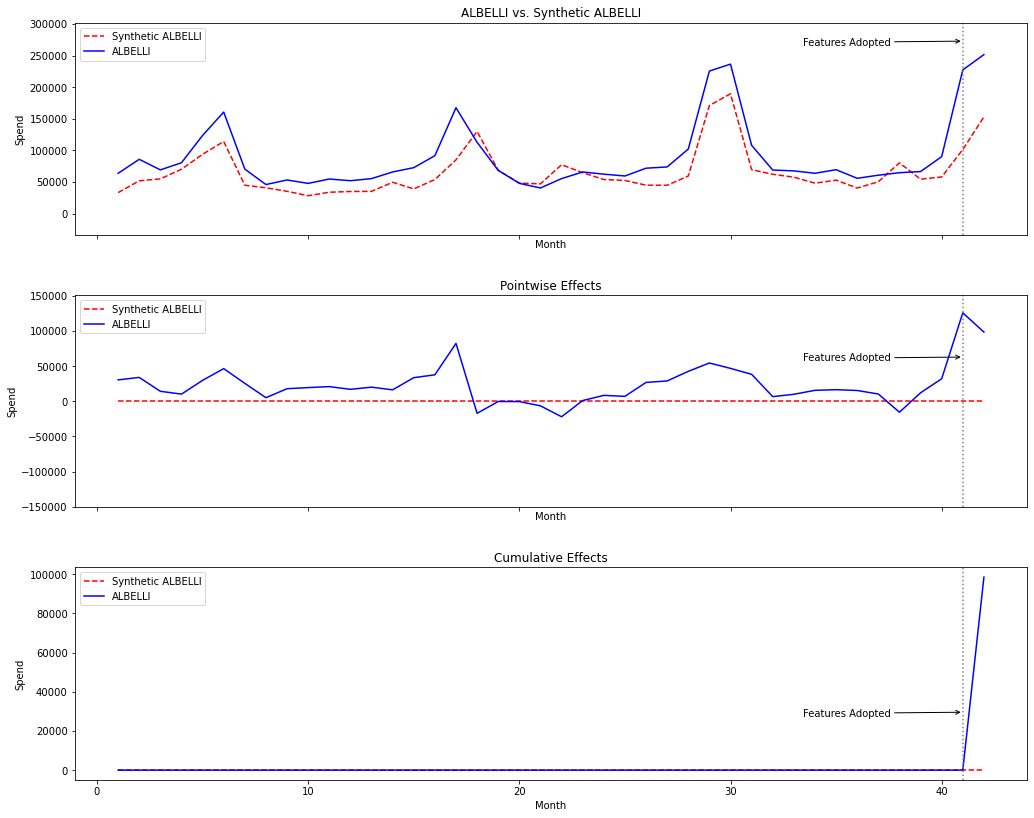

Controls and their weights:
                             Name  Weight
18005626  Monalbumphoto.fr - MSFT     1.0
Processing for Customer # 31
Test Customer Id:11229616, Name:Carvana, L1:Autos, L2:Third Party Sites, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 17
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 12
Data Set Shape: (504, 5)


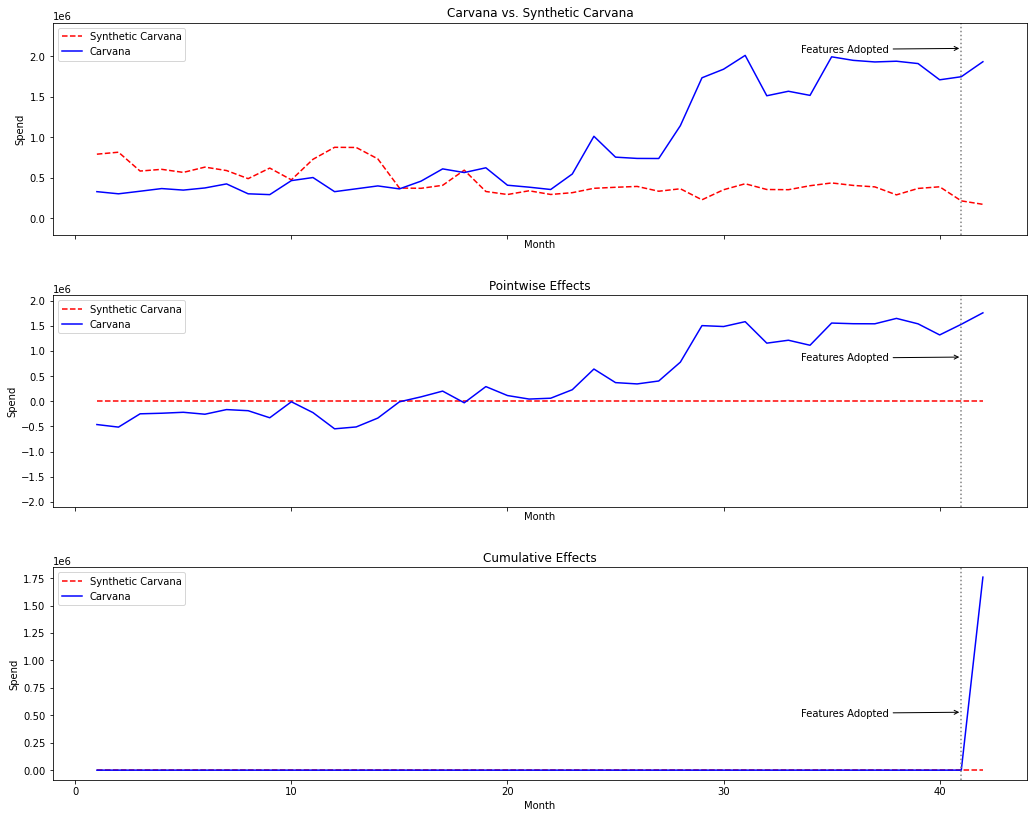

Controls and their weights:
                         Name    Weight
54643    H&S_Kelley Blue Book  0.369727
4007051               Truecar  0.630273
Processing for Customer # 32
Test Customer Id:11244132, Name:PayPal Business Finance Solutions, L1:Financial Services & Insurance, L2:Loans & Lending, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 14
Number of Months test data available: 25
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 10
Data Set Shape: (250, 5)


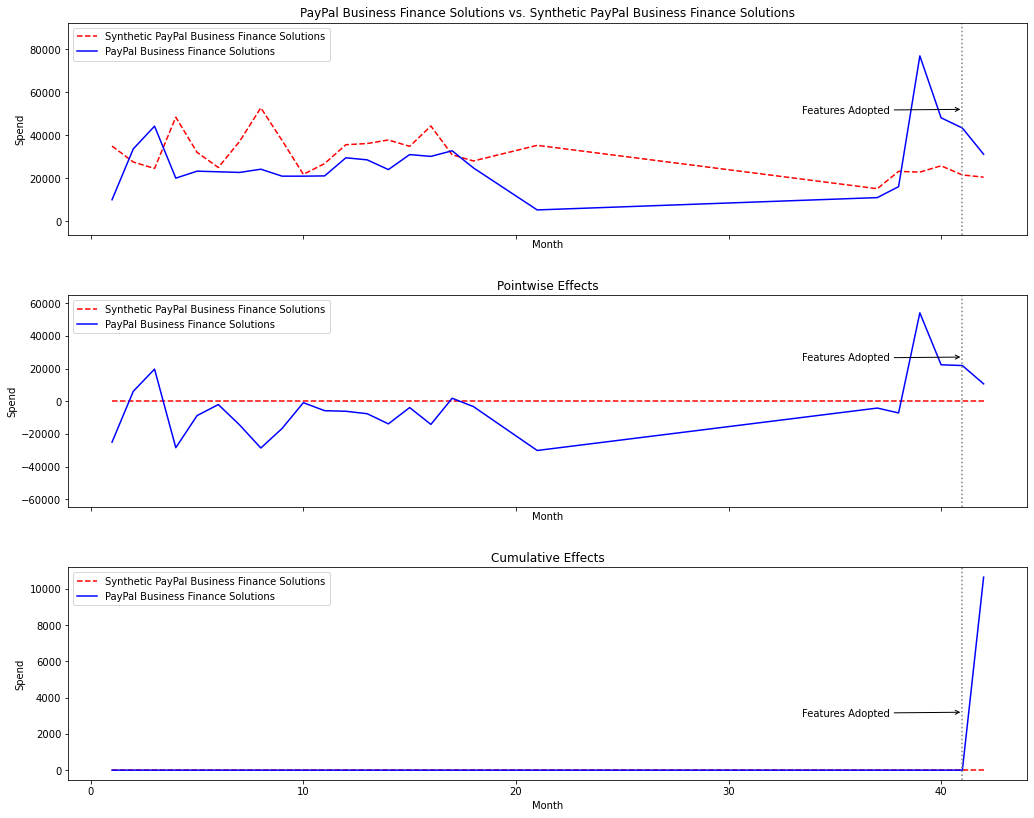

Controls and their weights:
                             Name    Weight
15039         America One Funding  0.555257
48509                  Debtmerica  0.175626
25190097  Marcus by Goldman Sachs  0.269117
Processing for Customer # 33
Test Customer Id:12095858, Name:Best Buy Canada LTD, L1:Retail, L2:Consumer Electronics, Segment:Corporate, Country:Canada
Number of customers in the pool before excluding all treated customers and test months data : 5
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 2
Data Set Shape: (84, 5)


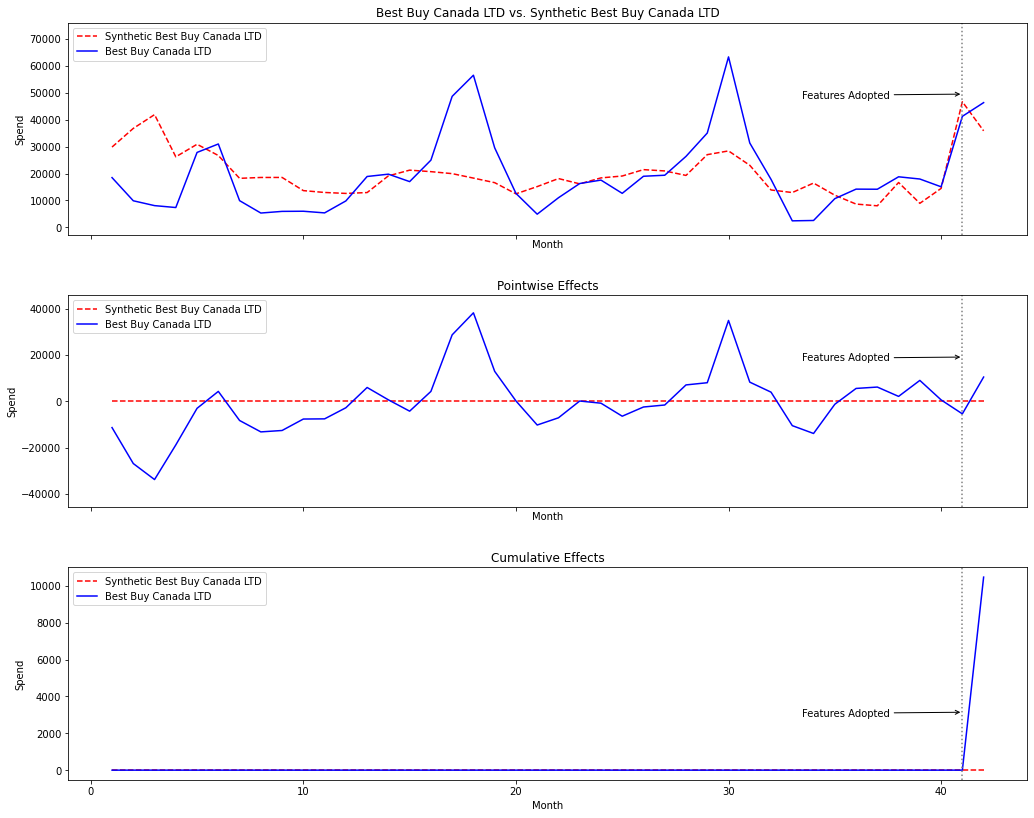

Controls and their weights:
                   Name  Weight
60581  Dell Canada - CA     1.0
Processing for Customer # 34
Test Customer Id:12125683, Name:Lucid Software, L1:Technology & Telecommunications, L2:Software, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 62
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 42
Data Set Shape: (1764, 5)


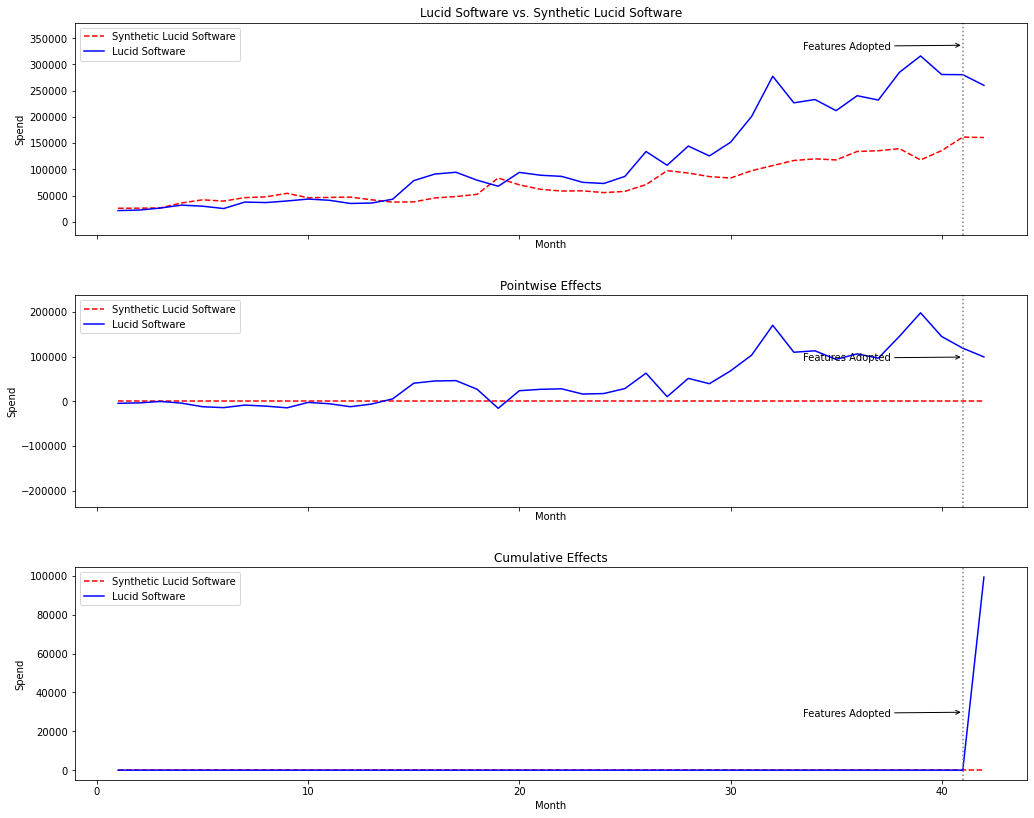

Controls and their weights:
                                  Name    Weight
1718       SAP Global Direct Marketing  0.018944
53658                  Mindbody Online  0.029712
60936               Fishbowl Inventory  0.030812
177190                SurePayroll, LLC  0.050598
278714                         Dotster  0.038231
4042947      Procore Technologies, Inc  0.012887
4052053            Bigcommerce Pty Ltd  0.025804
4069521                      Kareo Inc  0.029122
6021478              TherapyNotes, LLC  0.039907
11119318                 MuleSoft, Inc  0.052431
12236769                    IDrive Inc  0.020427
13088947                  QlikTech Inc  0.033950
14026087              Pitney Bowes Inc  0.010492
18165163                       Hubspot  0.465198
21130500                       iMatrix  0.091990
160434087                    Splashtop  0.020630
Processing for Customer # 35
Test Customer Id:12174608, Name:Asana Inc, L1:Technology & Telecommunications, L2:Software, Segment:Enterprise

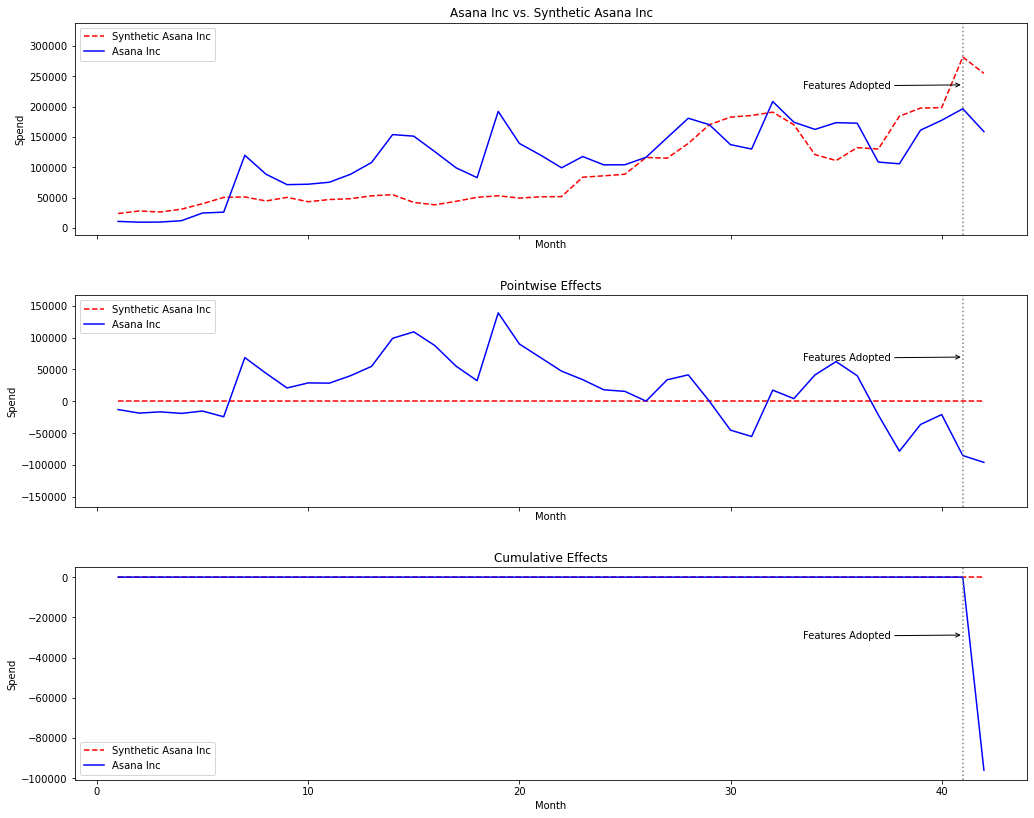

Controls and their weights:
                Name  Weight
36128827  Corel Corp     1.0
Processing for Customer # 36
Test Customer Id:14049925, Name:GoodRx, L1:Health & Wellness, L2:Pharma - Rx, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 31
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 23
Data Set Shape: (966, 5)


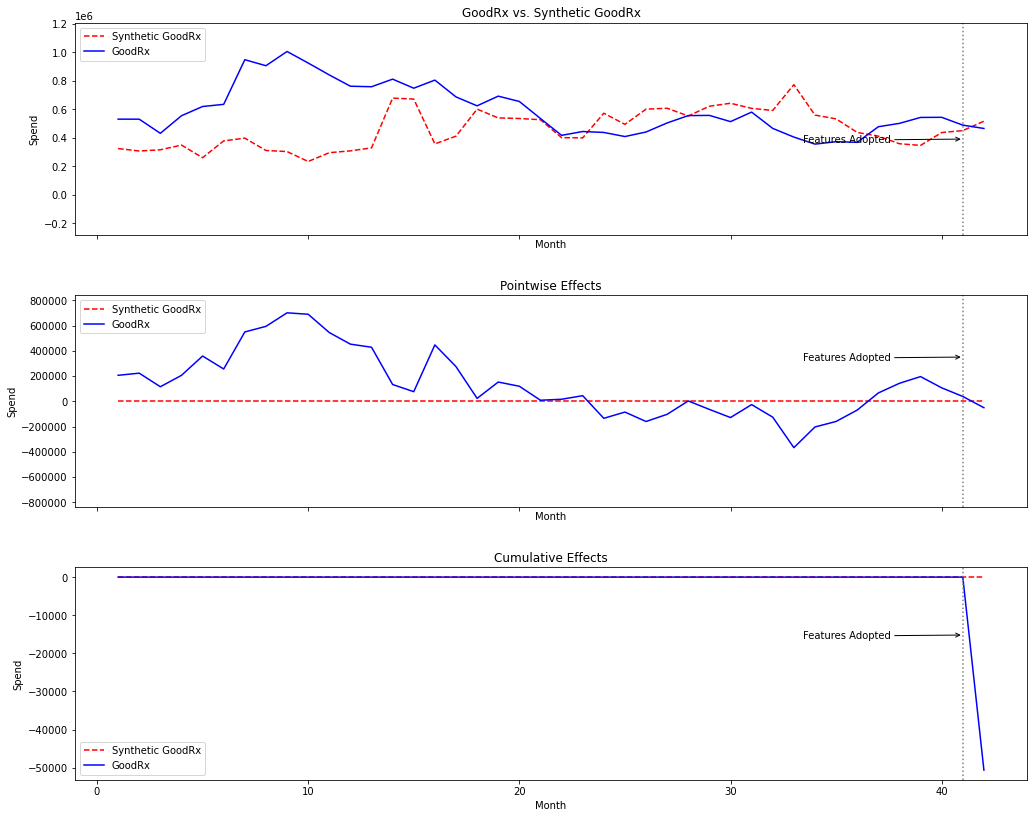

Controls and their weights:
                  Name    Weight
13074  CVS Corporation  0.554031
43224         Allergan  0.445969
Processing for Customer # 37
Test Customer Id:14102189, Name:Abbott Laboratories, L1:Health & Wellness, L2:Health Aids & Medical Supplies, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 30
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 21
Data Set Shape: (882, 5)


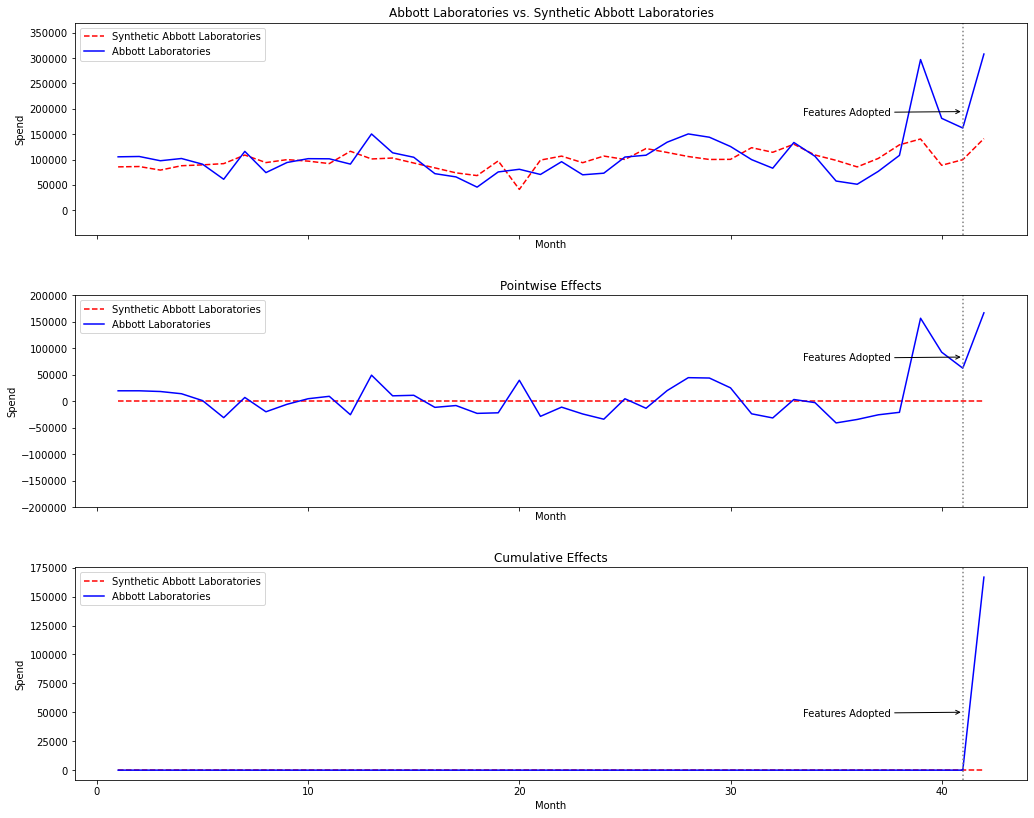

Controls and their weights:
                     Name   Weight
524875  Responselink, LLC  0.44021
886119      Zenni Optical  0.55979
Processing for Customer # 38
Test Customer Id:17018321, Name:France Telecom España S.A.U, L1:Technology & Telecommunications, L2:Telecommunications, Segment:Enterprise, Country:Spain
Number of customers in the pool before excluding all treated customers and test months data : 3
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 2
Data Set Shape: (84, 5)


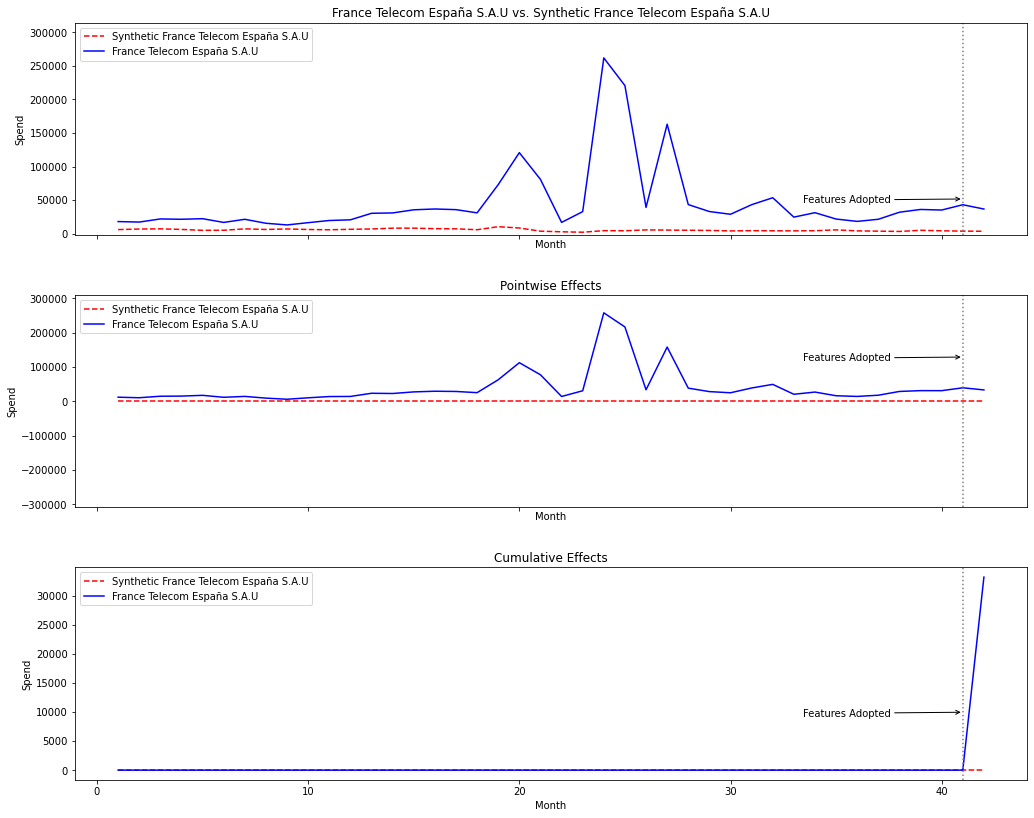

Controls and their weights:
                          Name  Weight
17018110  JAZZ TELECOM, S.A.U.     1.0
Processing for Customer # 39
Test Customer Id:17101857, Name:Canada Goose, L1:Retail, L2:Apparel & Accessories, Segment:Corporate, Country:Canada
Number of customers in the pool before excluding all treated customers and test months data : 5
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 1
Data Set Shape: (42, 5)
No Customers in the pool
Processing for Customer # 40
Test Customer Id:50168202, Name:The Hartford Gold Group, L1:Health & Wellness, L2:Health Services, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 44
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test month

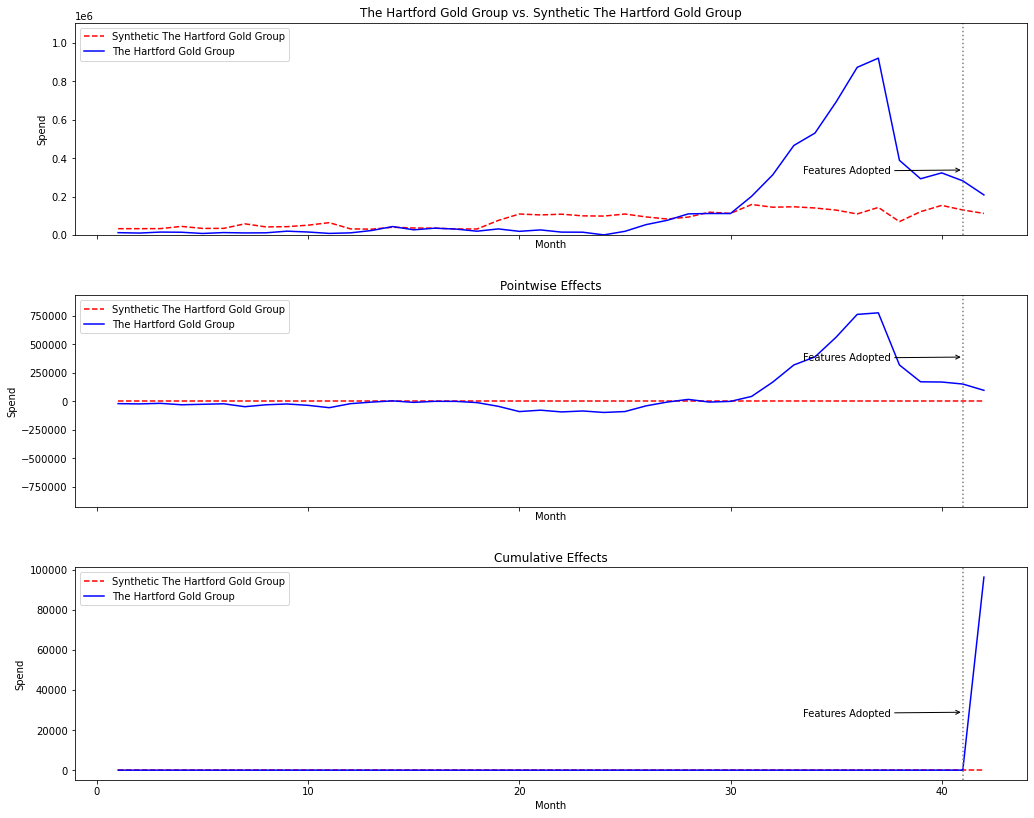

Controls and their weights:
                       Name    Weight
559499          Launch That  0.304399
11231090  SpeerLaboratories  0.695601
Processing for Customer # 41
Test Customer Id:163219202, Name:DerbySoft, L1:Travel & Transportation, L2:Lodging, Segment:SMB, Country:China
Number of customers in the pool before excluding all treated customers and test months data : 26
Number of Months test data available: 9
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 5
Data Set Shape: (45, 5)


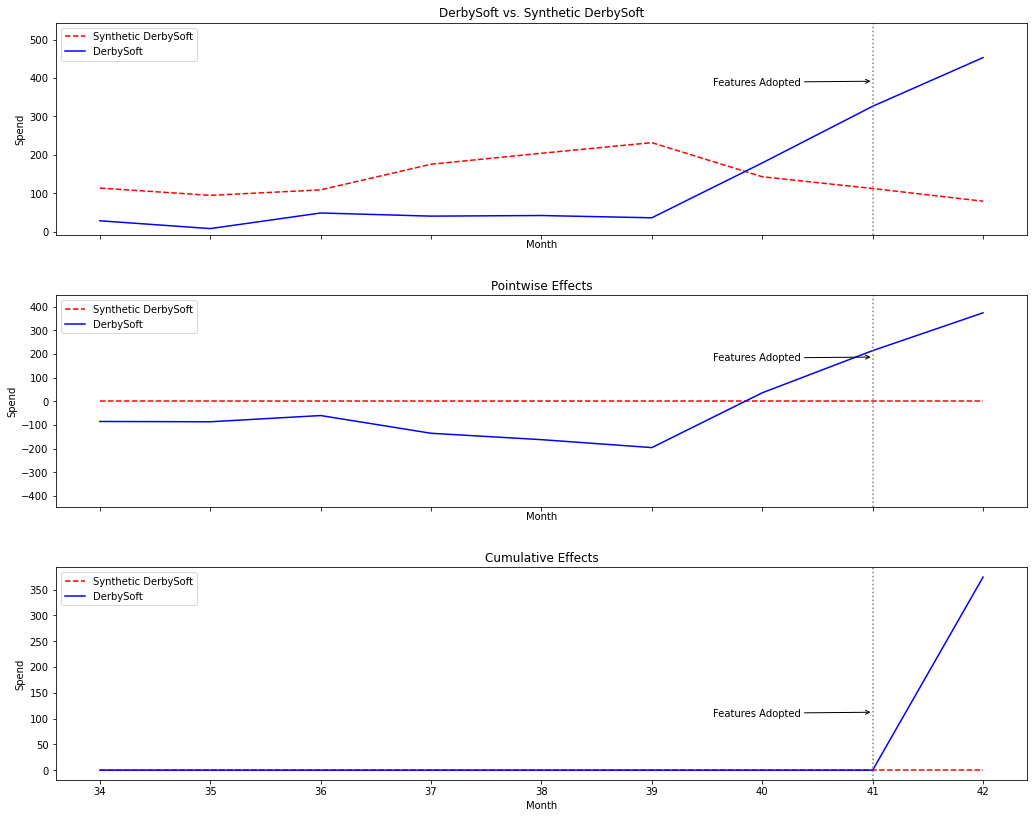

Controls and their weights:
                   Name  Weight
250568307  Go Fly La TW     1.0
Processing for Customer # 42
Test Customer Id:168417317, Name:NJM Insurance Group, L1:Financial Services & Insurance, L2:Insurance, Segment:SMB, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 3151
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 215
Data Set Shape: (9030, 5)


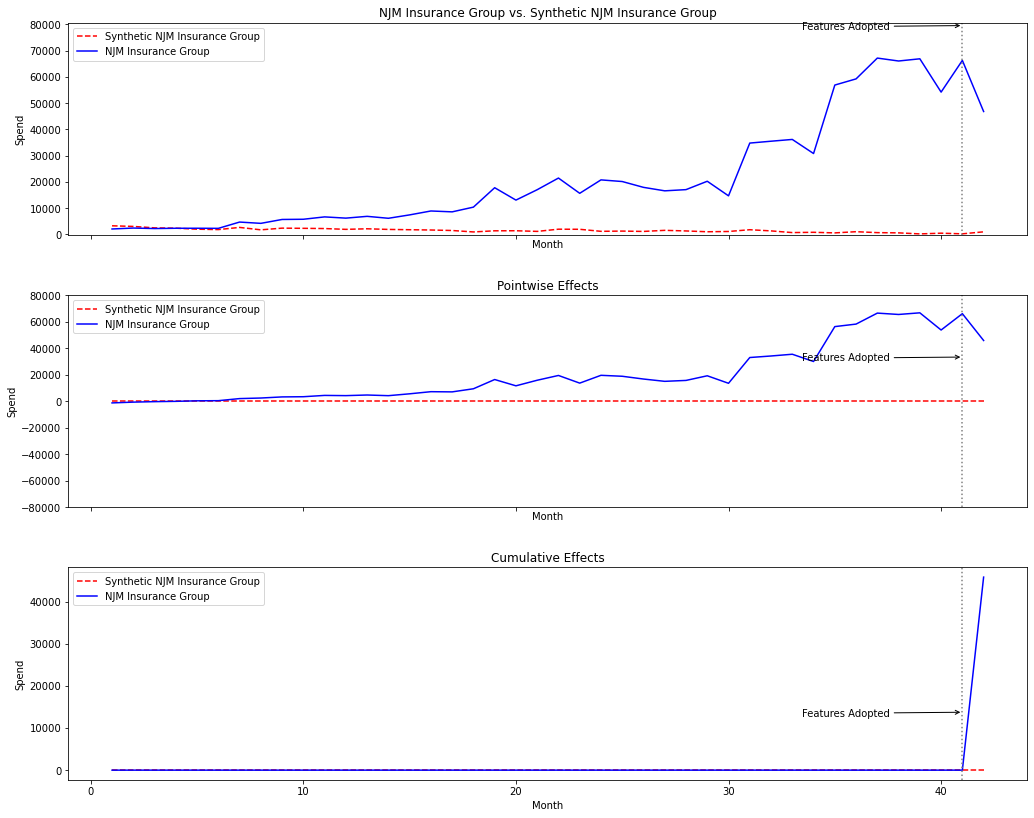

Controls and their weights:
                       Name  Weight
12073858  Second Look Flood     1.0
Processing for Customer # 43
Test Customer Id:250317108, Name:AMResorts, L.P., L1:Travel & Transportation, L2:Lodging, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 13
Number of Months test data available: 38
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 10
Data Set Shape: (380, 5)


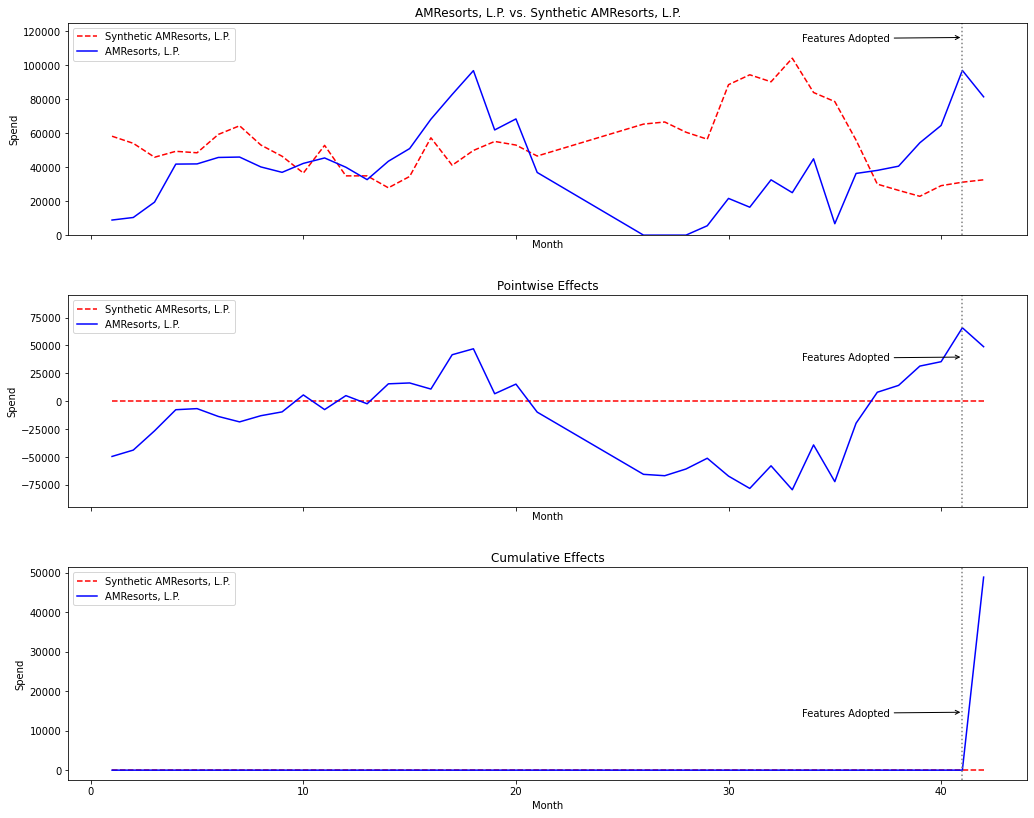

Controls and their weights:
                               Name  Weight
159422438  Vacation Innovations LLC     1.0
Processing for Customer # 44
Test Customer Id:250913912, Name:Pintas & Mullins Law Firm, L1:B2C Services, L2:Legal Services, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 8
Number of Months test data available: 20
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 3
Data Set Shape: (60, 5)


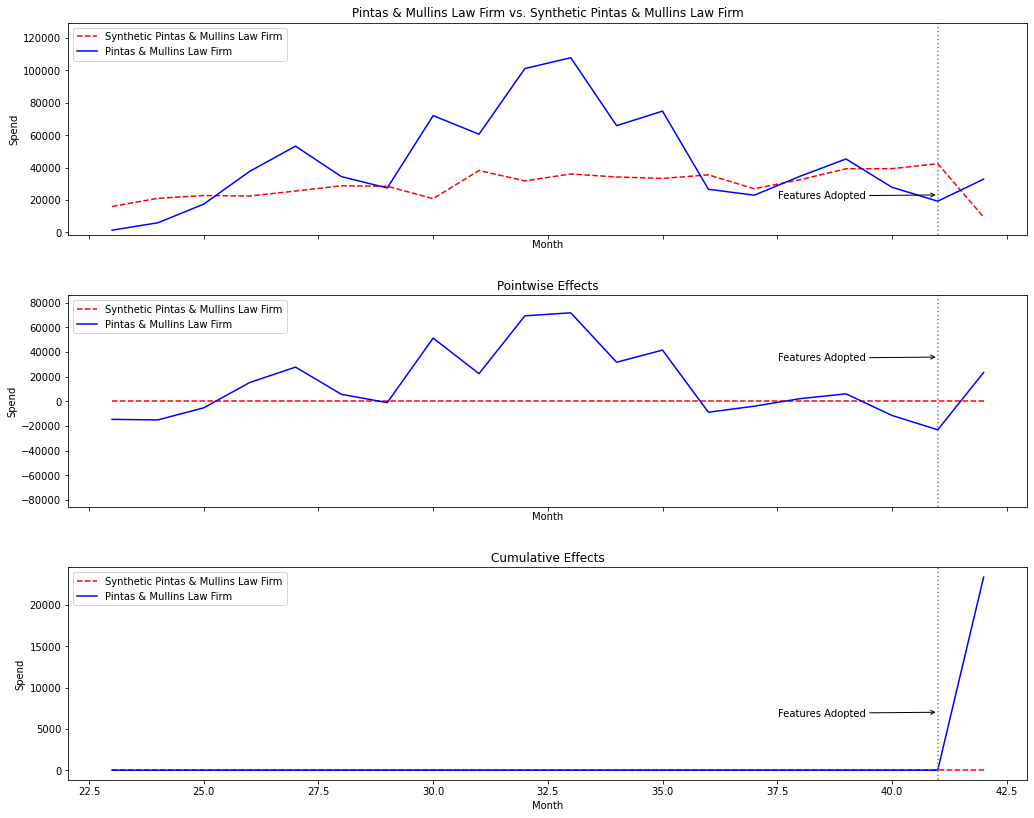

Controls and their weights:
                             Name  Weight
8054058  Rocket Lawyer UK Limited     1.0
Processing for Customer # 45
Test Customer Id:251664079, Name:MapQuest, L1:Real Estate, L2:Properties for Sale, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 21
Number of Months test data available: 5
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 18
Data Set Shape: (90, 5)


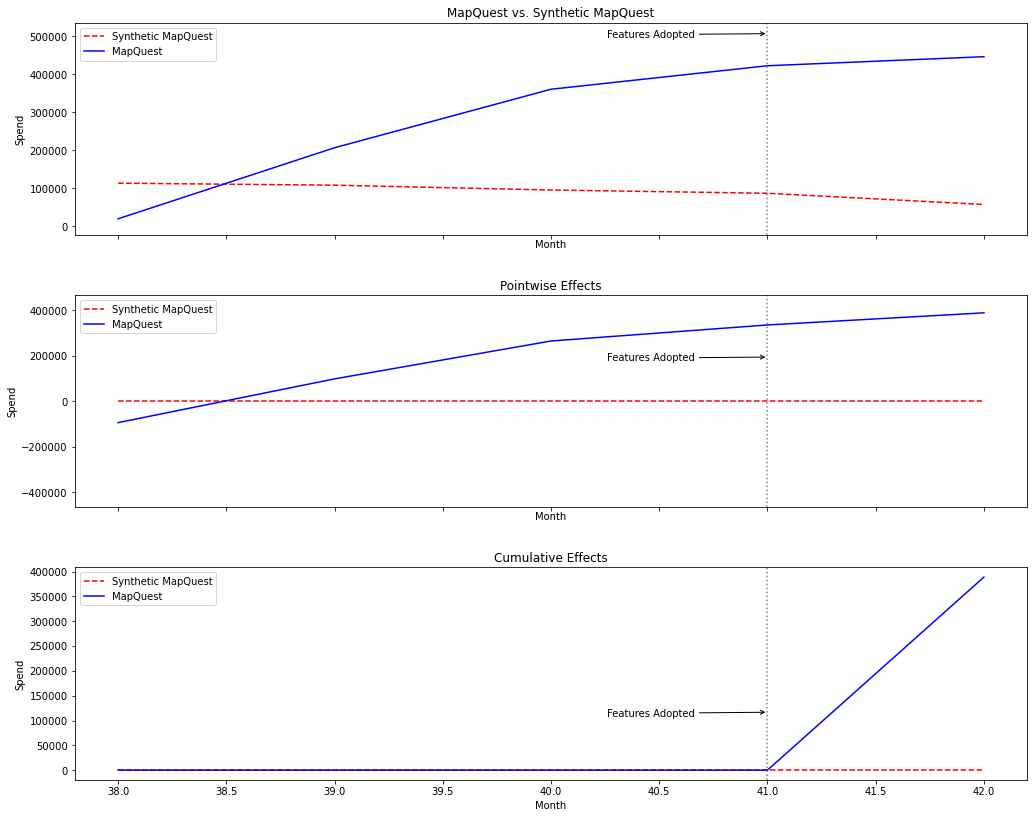

Controls and their weights:
                                 Name  Weight
42172618  HomeVestors of America, Inc     1.0
Processing for Customer # 46
Test Customer Id:251680205, Name:Tripadvisor Experiences, L1:Travel & Transportation, L2:Activities, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 1
Number of Months test data available: 32
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 1
Data Set Shape: (32, 5)
No Customers in the pool
Processing for Customer # 47
Test Customer Id:251757767, Name:SkinBaron GmbH, L1:Retail, L2:Toys & Hobbies, Segment:SMB, Country:Germany
Number of customers in the pool before excluding all treated customers and test months data : 204
Number of Months test data available: 3
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and tes

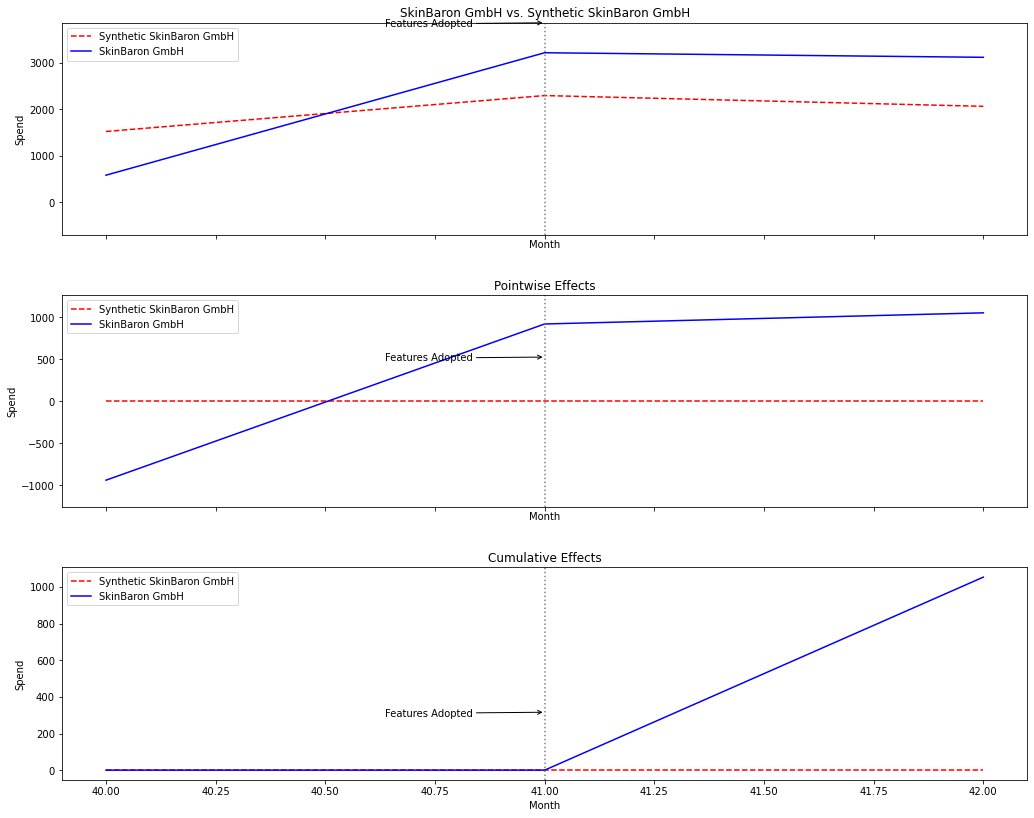

Controls and their weights:
                                            Name    Weight
19000636                                  Steiff  0.218932
42111767                 European Games Group AG  0.027891
158133944       Faber-Castell Aktiengesellschaft  0.051359
160426759                        Nicolas Grobbel  0.037129
163279840                         Smartmaxx GmbH  0.051511
168941682  geobra Brandstätter Stiftung & Co. KG  0.055100
169928951                        Steinway & Sons  0.025385
250642501                JUMP House Holding GmbH  0.028072
251443703                              Toypalace  0.295153
Processing for Customer # 48
Test Customer Id:251822327, Name:GFM Retail Private Limited, L1:Restaurants & Food, L2:Food & Beverages, Segment:Channel Partner, Country:India
Number of customers in the pool before excluding all treated customers and test months data : 6
Number of Months test data available: 2
Treatment Month: December2021
Number of customers in the pool after exclu

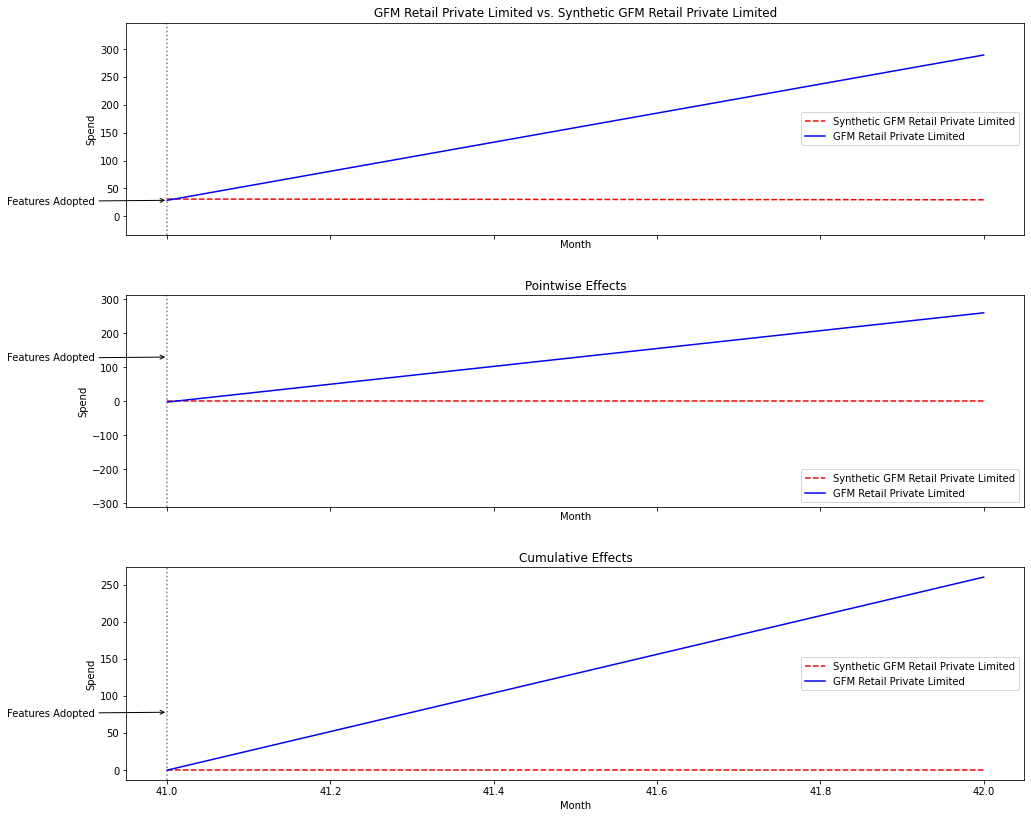

Controls and their weights:
                       Name  Weight
160387411  Wine Cooler City     1.0
Wall time: 4min 40s


In [89]:
%%time
res = run_sc(eng_mth)
append_monthly_outputs(res)

In [90]:
cons_res_df.shape, cons_error_df.shape, cons_comp_df.shape

((98, 7), (47, 14), (47, 5))

#### Done with All months

In [91]:
#Write Consolidated outputs to excel
cons_res_df.to_excel(op_path+'Cons_Mappings.xlsx',index=False)
cons_comp_df.to_excel(op_path+'Cons_Comparison.xlsx',index=False)
cons_error_df.to_excel(op_path+'Cons_Error.xlsx',index=False)

In [92]:
def form_no_ctrl_df(no_ctrls_dict_):
    no_ctrls_df_ = pd.DataFrame(columns=['CID','Name','Month','Reason'])
    for k,v in no_ctrls_dict_.items():
        temp_dict = {'CID':k[0],'Name':k[1],'Month':k[2],'Reason':v}
        no_ctrls_df_ = no_ctrls_df_.append(temp_dict, ignore_index=True)
    return no_ctrls_df_

In [93]:
end_time = time.ctime()
start_time, end_time

('Mon Jan  3 19:04:06 2022', 'Mon Jan  3 19:13:12 2022')

## Retry Mappings

In [94]:
#Retry Synthetic Controls- Input df should contain two columns: CID, Month
def retry_sc(retry_cids_df_,include_seg =True, include_con=True, include_l2=True, post_con=True):
    global res_df, error_df, comp_df

    i=0
    #Flush results before starting
    flush_results()
    print('Number of Customers to be processed:',len(retry_cids_df_))
    for row in retry_cids_df_.itertuples():
        print('Processing Customer #',i)
        cid_, mth_= row[1], row[2]
        print('='*80)
        sc, excludes = fit_sc(cid_, mth_, include_seg, include_con, include_l2, post_con)
        if (sc != None) :
            process_result(sc, excludes, i, cid_, mth_)
        i+=1
                        
    return res_df, error_df, comp_df

In [95]:
#Data frame with  no control CIDs
no_ctrls_df = form_no_ctrl_df(no_ctrls_dict)

no_ctrls_df.shape

(2, 4)

In [96]:
#Write no mapping before retry to a file
no_ctrls_df.to_excel(op_path+'Cons_No_Mapping_Before_Retry.xlsx',index=False)

no_ctrls_df.Reason.value_counts()

No Customers in the pool    2
Name: Reason, dtype: int64

### No customers in the Pool

In [97]:
#To Retry with segment excluded
retry_no_pool_seg_df = no_ctrls_df[no_ctrls_df.Reason=='No Customers in the pool'][['CID','Month']]

retry_no_pool_seg_df.shape, no_ctrls_df.shape

((2, 2), (2, 4))

In [98]:
print('Number of Customers to retry:',len(retry_no_pool_seg_df))

Number of Customers to retry: 2


In [99]:
#Flush No controls dictionary
no_ctrls_dict = {}

Number of Customers to be processed: 2
Processing Customer # 0
Trying without Segment, Test Customer Id:17101857, Name:Canada Goose, L1:Retail, L2:Apparel & Accessories, Segment:Corporate, Country:Canada
Number of customers in the pool before excluding all treated customers and test months data : 2400
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 102
Data Set Shape: (4284, 5)


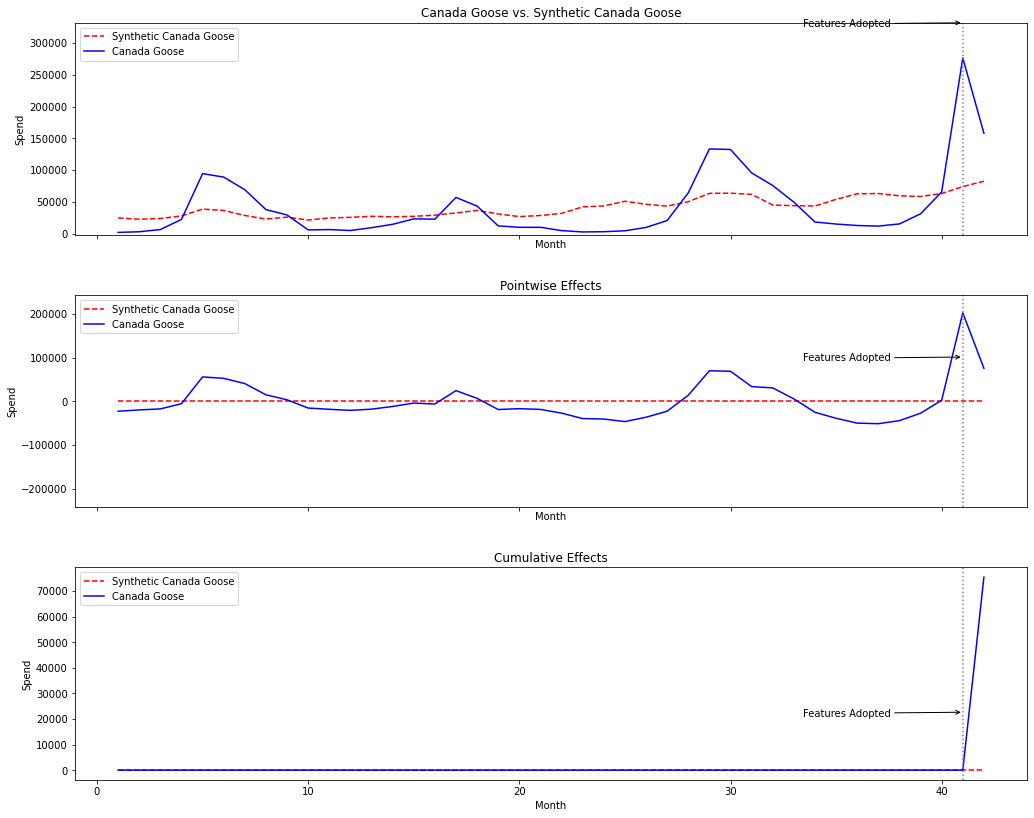

Controls and their weights:
                                  Name    Weight
11143709         La Maison Simons Inc.  0.956633
12021367  Jaded Pixel Technologies Inc  0.043367
Processing Customer # 1
Trying without Segment, Test Customer Id:251680205, Name:Tripadvisor Experiences, L1:Travel & Transportation, L2:Activities, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 852
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 48
Data Set Shape: (1536, 5)


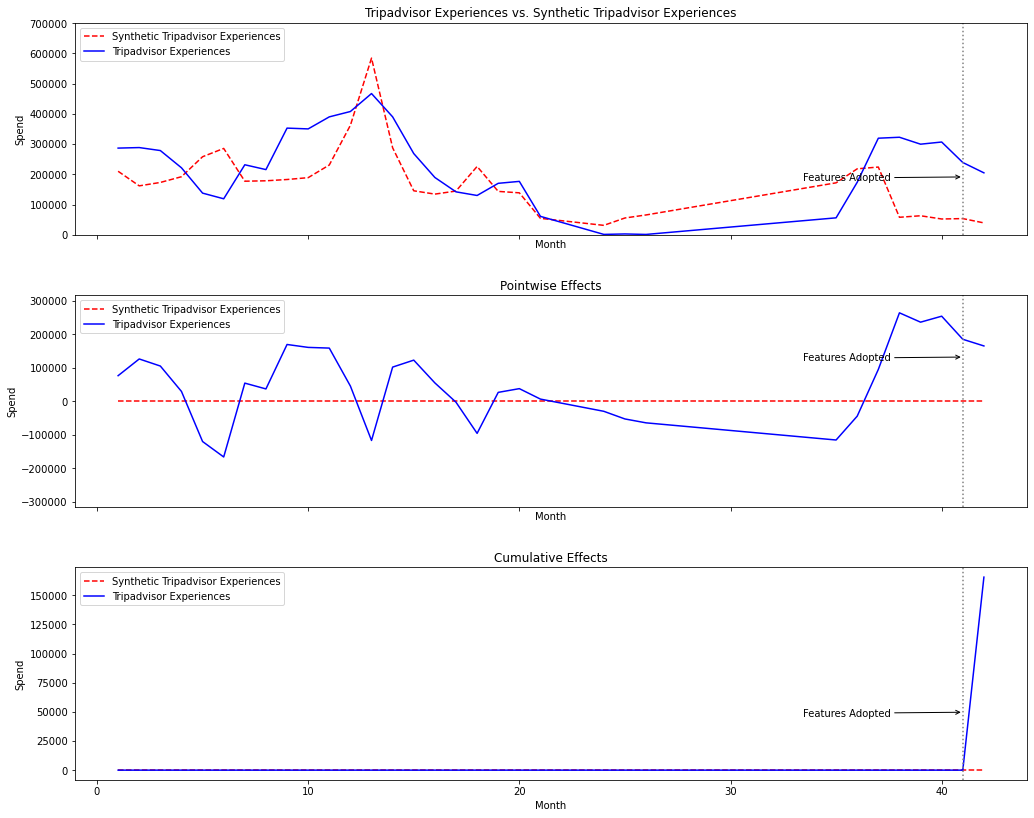

Controls and their weights:
                                   Name  Weight
410795  Busch Entertainment Corporation     1.0
Wall time: 13.4 s


In [100]:
%%time
#Try Without Segment
remap_no_pool_seg_df = retry_sc(retry_no_pool_seg_df, include_seg=False, include_con=True, include_l2=True)

In [101]:
print_results()

Results df Shape: (3, 7) Error df Shape: (2, 5) Comparison df shape: (2, 14)
Number of Entries for which mappings are found: 2


In [102]:
remap_no_pool_seg_df[0].shape, len(remap_no_pool_seg_df[0].CID.unique())

((3, 7), 2)

In [103]:
no_ctrls_dict

{}

In [104]:
#Customers Still having no mappings
temp_df = form_no_ctrl_df(no_ctrls_dict)
display(temp_df.shape)
#To Retry with country excluded
retry_no_pool_con_df = temp_df[['CID','Month']]
retry_no_pool_con_df.shape


(0, 4)

(0, 2)

In [105]:
#Flush No controls dictionary
no_ctrls_dict = {}

In [106]:
print('Number of Customers to retry:',len(retry_no_pool_con_df))

Number of Customers to retry: 0


In [107]:
%%time
#Try Without Segment and Country
remap_no_pool_con_dfs = retry_sc(retry_no_pool_con_df,include_seg=False, include_con=False, include_l2=True)

Number of Customers to be processed: 0
Wall time: 11.8 ms


In [108]:
print_results()

Results df Shape: (0, 7) Error df Shape: (0, 0) Comparison df shape: (0, 14)
Number of Entries for which mappings are found: 0


In [109]:
no_ctrls_dict

{}

In [110]:
no_ctrls_df.Reason.value_counts()

No Customers in the pool    2
Name: Reason, dtype: int64

### No Data on or Post Treatment  

In [111]:
retry_post_data_df = no_ctrls_df[no_ctrls_df.Reason=='No Test Data Available on or post the treatment'][['CID','Month']]

retry_post_data_df.shape, no_ctrls_df.shape

((0, 2), (2, 4))

In [112]:
#Exclude Customers that are resulting in error
retry_post_data_df = retry_post_data_df[~(retry_post_data_df.Month=='October2020')]

retry_post_data_df.shape

(0, 2)

In [113]:
%%time
remap_post_data_df = retry_sc(retry_post_data_df, post_con=False)

Number of Customers to be processed: 0
Wall time: 8.08 ms


In [114]:
print_results()

Results df Shape: (0, 7) Error df Shape: (0, 0) Comparison df shape: (0, 14)
Number of Entries for which mappings are found: 0


In [115]:
no_ctrls_dict

{}

### Weights Not returned by model

In [116]:
retry_no_weights_df = no_ctrls_df[no_ctrls_df.Reason=='Weights not returned by the model'][['CID','Month']]

retry_no_weights_df.shape, no_ctrls_df.shape

((0, 2), (2, 4))

In [117]:
%%time
remap_no_weights_df = retry_sc(retry_no_weights_df, post_con=False)

Number of Customers to be processed: 0
Wall time: 9.47 ms


In [118]:
print_results()

Results df Shape: (0, 7) Error df Shape: (0, 0) Comparison df shape: (0, 14)
Number of Entries for which mappings are found: 0


In [119]:
len(no_ctrls_dict)

0

In [120]:
no_ctrls_dict

{}

### Combine results

In [121]:
cons_res_df.shape, remap_post_data_df[0].shape

((98, 7), (0, 7))

In [122]:
remap_no_pool_seg_df[0].shape, remap_no_pool_con_dfs[0].shape
remap_no_pool_df = remap_no_pool_seg_df[0].append(remap_no_pool_con_dfs[0])
remap_no_pool_df.shape

(3, 7)

In [123]:
cons_res_df[cons_res_df.CID.isin(remap_post_data_df[0].CID)].shape, cons_res_df[cons_res_df.CID.isin(remap_no_pool_df.CID)].shape

((0, 7), (0, 7))

In [124]:
cons_res_df[cons_res_df.CID.isin(remap_no_weights_df[0].CID)].shape

(0, 7)

#### There are no overlapping customers.

In [125]:
display(cons_res_df.head(2))
display(remap_post_data_df[0].head(2))
display(remap_no_pool_df.head(2))
display(remap_no_weights_df[0].head(2))

CID      Name         Month ControlCID                          ControlName  \
0   3  Lexus US  December2021     671423  Jaguar Land Rover North America LLC   
1   3  Lexus US  December2021    7008393          Toyota Motor Sales Inc. USA   

   ControlWeight Excludes  
0        0.83233           
1        0.16767

Empty DataFrame
Columns: [CID, Name, Month, ControlCID, ControlName, ControlWeight, Excludes]
Index: []

CID          Name         Month ControlCID  \
0  17101857  Canada Goose  December2021   11143709   
1  17101857  Canada Goose  December2021   12021367   

                    ControlName  ControlWeight Excludes  
0         La Maison Simons Inc.       0.956633  Segment  
1  Jaded Pixel Technologies Inc       0.043367  Segment

Empty DataFrame
Columns: [CID, Name, Month, ControlCID, ControlName, ControlWeight, Excludes]
Index: []

In [126]:
#Drops the existing mappings from main df and keeps the ones in sub df based on CID and Month combination
def combine_dfs(main_df_, sub_df_ ):
    df1 = main_df_.copy()
    df2 = sub_df_.copy()
    for row in df2[['CID','Month']].drop_duplicates().itertuples():
#         print('Existing mappings shape in main df:', main_df_[ (main_df_.CID==row[1]) & (main_df_.Month==row[2])].shape)
        df1 = df1[ ~((df1.CID==row[1]) & (df1.Month==row[2]))]
    
#     print(df1.shape, df2.shape)
    df1 = df1.append(df2)
#     print(df1.shape)
    return df1

In [127]:
cons_res_df.shape, remap_post_data_df[0].shape, remap_no_pool_df.shape, remap_no_weights_df[0].shape

((98, 7), (0, 7), (3, 7), (0, 7))

In [128]:
cons_res_remaps_df = combine_dfs(cons_res_df, remap_no_pool_df)
cons_res_remaps_df = combine_dfs(cons_res_remaps_df, remap_post_data_df[0])
cons_res_remaps_df = combine_dfs(cons_res_remaps_df, remap_no_weights_df[0])

#Check the shape after merging
cons_res_remaps_df.shape

(101, 7)

In [129]:
start_time, time.ctime()

('Mon Jan  3 19:04:06 2022', 'Mon Jan  3 19:13:26 2022')

# Manually Checked Mappings - Refine mappings for bad mappings

In [131]:
retry_man_df = pd.read_csv(op_path+'To_Retry.csv')
retry_man_df.shape

(12, 2)

In [132]:
retry_man_df

CID         Month
0        1962  December2021
1        2409  December2021
2        4289  December2021
3       12767  December2021
4       41460  December2021
5      771818  December2021
6    11229616  December2021
7    17018321  December2021
8   168417317  December2021
9   250913912  December2021
10  251664079  December2021
11  251822327  December2021

In [133]:
no_ctrls_dict = {}

In [134]:
# %%time
# max_pool_cap = 100
# #First try with reducing the pool size. Still around 16 mappings are either bad or no customers in control pool
# map_man_df = retry_sc(retry_man_df)

In [135]:
# map_man_df.shape

Number of Customers to be processed: 12
Processing Customer # 0
Test Customer Id:1962, Name:Devry, Inc., L1:Careers & Education, L2:Education, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 108
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 67
Data Set Shape: (2814, 5)


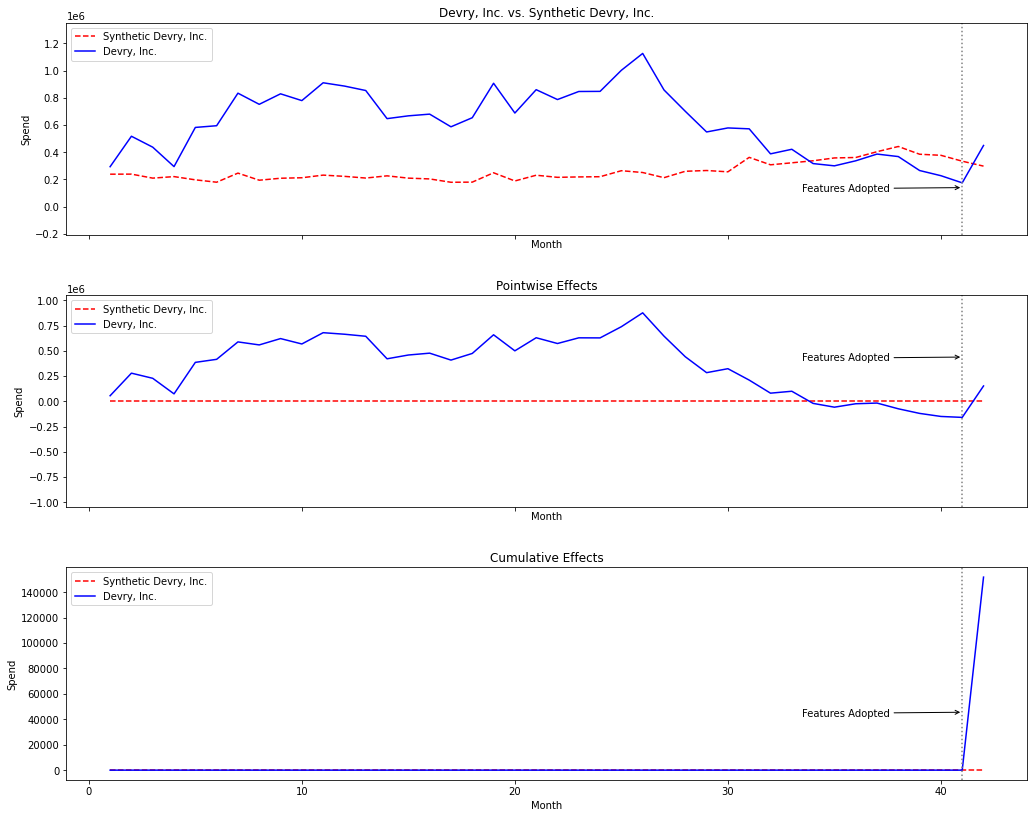

Controls and their weights:
                                        Name    Weight
180             Capella University Corporate  0.013736
15658                    Connections Academy  0.017338
33703                Laureate Education Inc.  0.014840
54883                           Aptimus, Inc  0.038743
100734           Grand Canyon Education Inc.  0.042823
563300             Compass Knowledge Group 1  0.011755
2015783                                Zovio  0.044159
2047563                                   2U  0.024376
2075226    Southern New Hampshire University  0.249496
5140403                       Learning House  0.010939
6017781                   Carrington College  0.019136
7055647                       Deltak Edu Inc  0.015614
7065461                Academic Partnerships  0.015974
11212434                  Keiser University.  0.027486
12076229                QuinStreet Education  0.087510
12279111         National University Systems  0.013660
13233221          San Joaquin Valley 

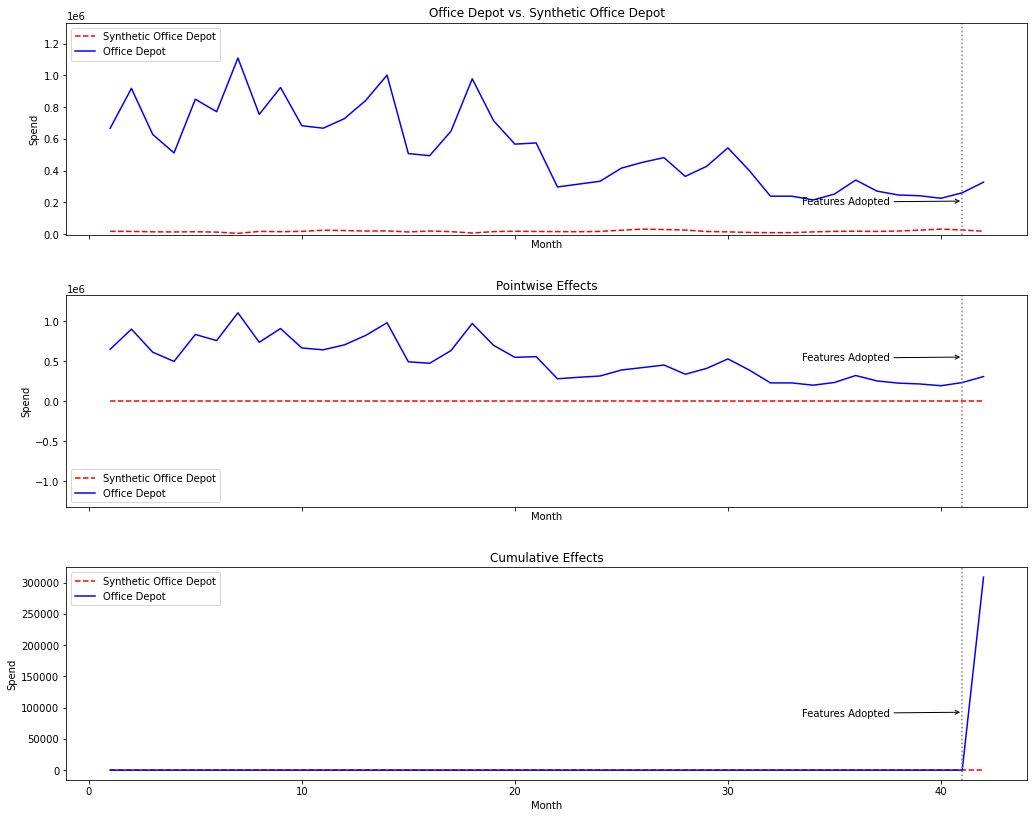

Controls and their weights:
               Name  Weight
854033  Luna Carpet     1.0
Processing Customer # 2
Test Customer Id:4289, Name:SA ENGIE, L1:B2C Services, L2:Utilities, Segment:Enterprise, Country:France
Number of customers in the pool before excluding all treated customers and test months data : 97
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 70
Data Set Shape: (2940, 5)


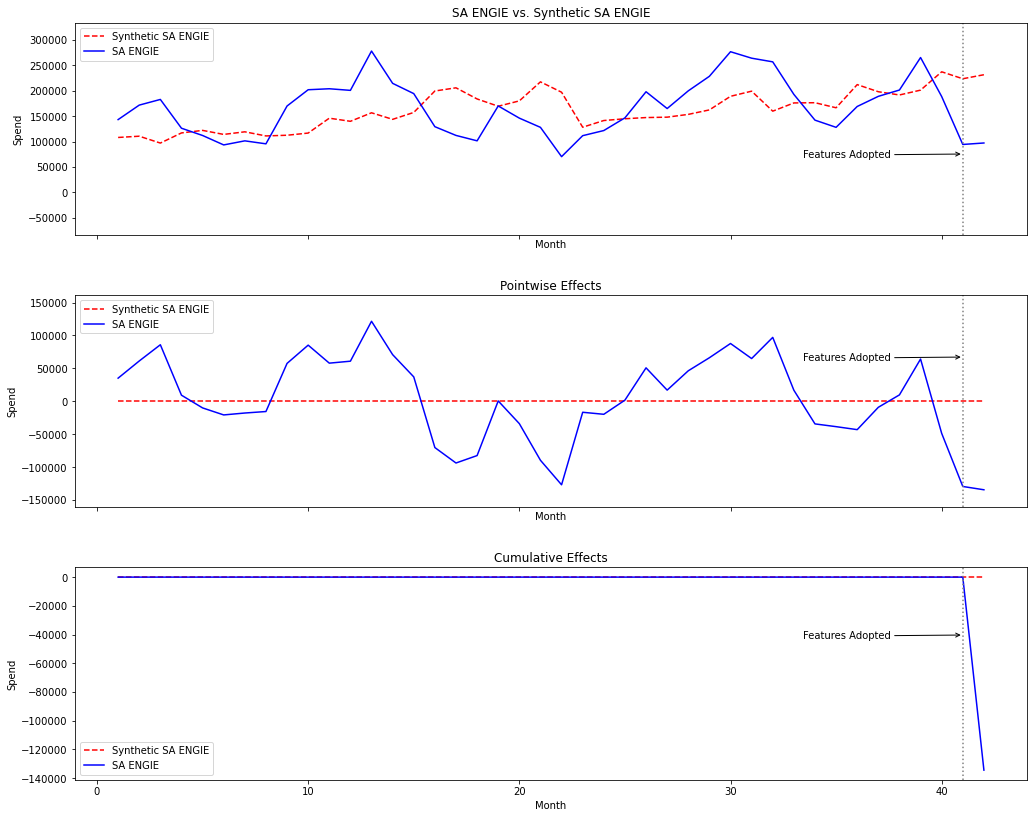

Controls and their weights:
                                           Name    Weight
43076                                    Ups-Fr  0.204810
13088160   Roto-Rooter Plumbing & Drain Service  0.702958
159310828                    The NumberGuru LLC  0.092231
Processing Customer # 3
Test Customer Id:12767, Name:FactoryOutletStore.com, L1:Retail, L2:Consumer Electronics, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 632
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 447
Capping the number of customers to 100 as it exceeded
Data Set Shape: (4242, 5)


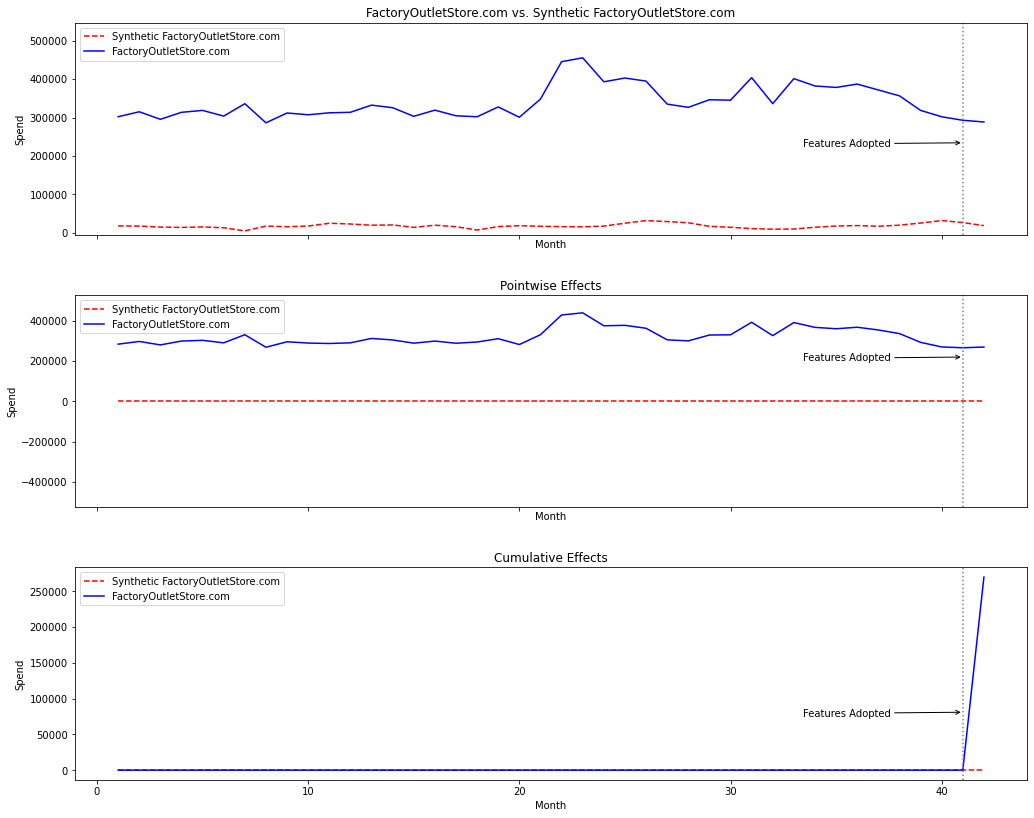

Controls and their weights:
               Name  Weight
854033  Luna Carpet     1.0
Processing Customer # 4
Test Customer Id:41460, Name:La-Z-Boy, Inc., L1:Retail, L2:Home & Garden, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 632
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 447
Capping the number of customers to 100 as it exceeded
Data Set Shape: (4242, 5)


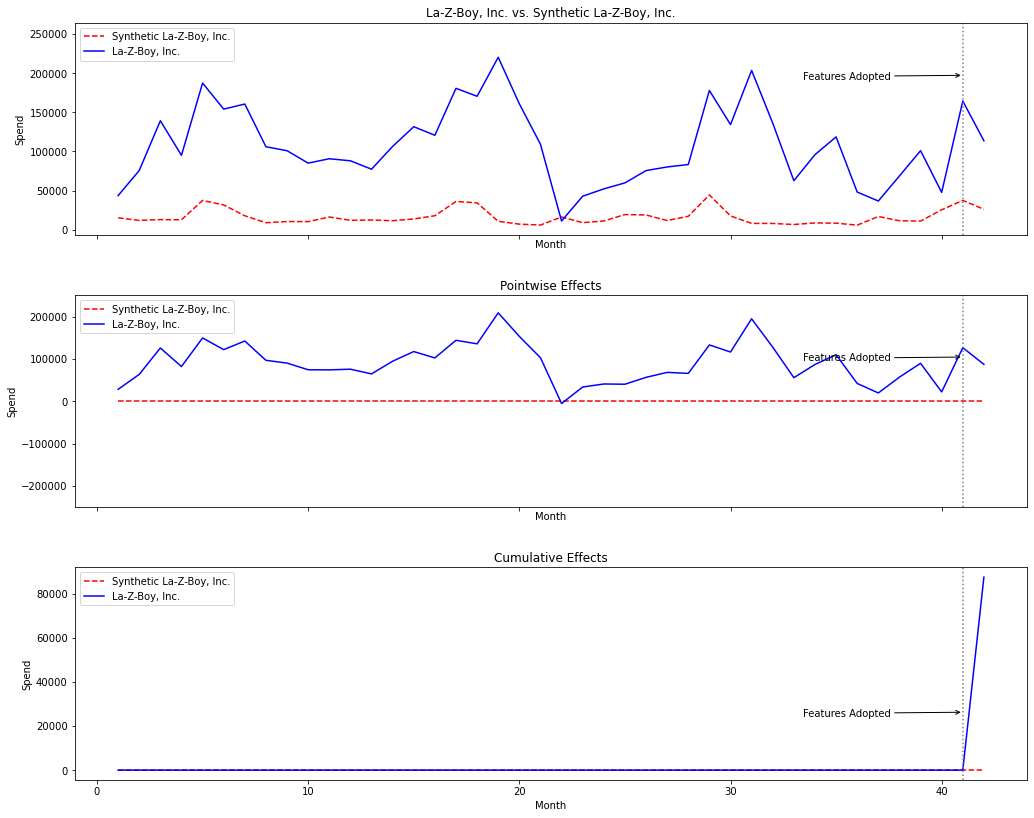

Controls and their weights:
              Name  Weight
2197  Sephora - FR     1.0
Processing Customer # 5
Test Customer Id:771818, Name:Rocket Lawyer, L1:B2C Services, L2:Legal Services, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 97
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 70
Data Set Shape: (2940, 5)


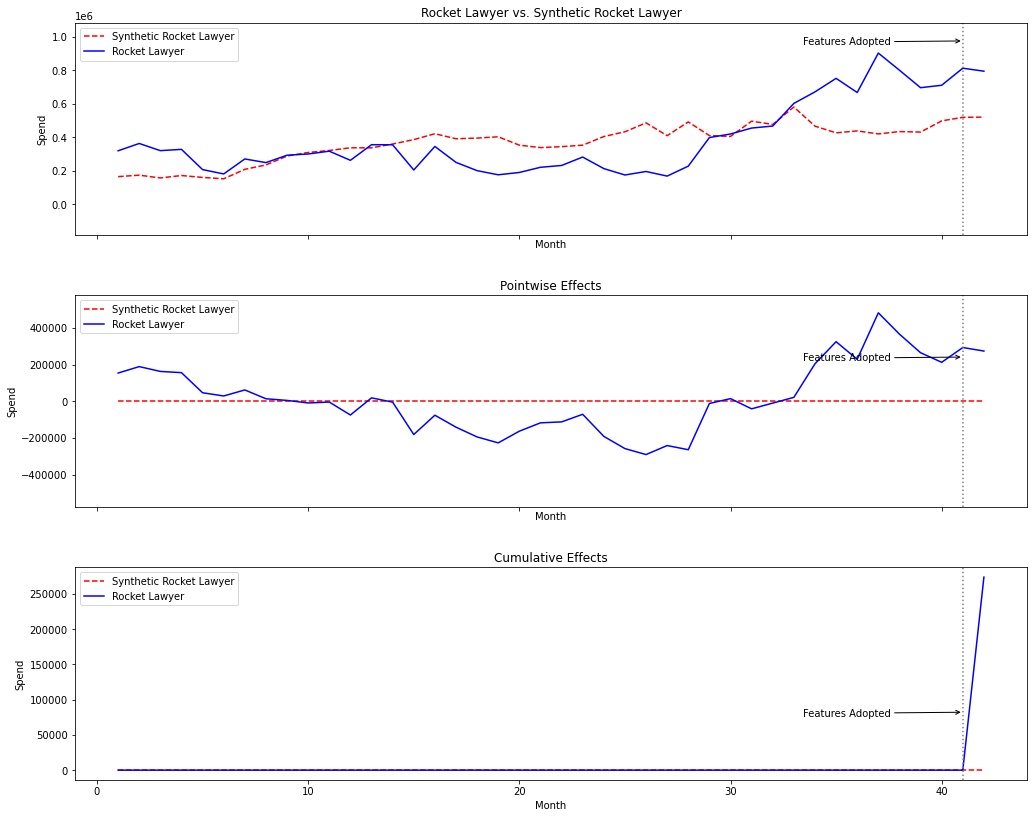

Controls and their weights:
                   Name    Weight
43076            Ups-Fr  0.254041
11229635  Penguin Leads  0.745959
Processing Customer # 6
Test Customer Id:11229616, Name:Carvana, L1:Autos, L2:Third Party Sites, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 151
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 100
Data Set Shape: (4200, 5)


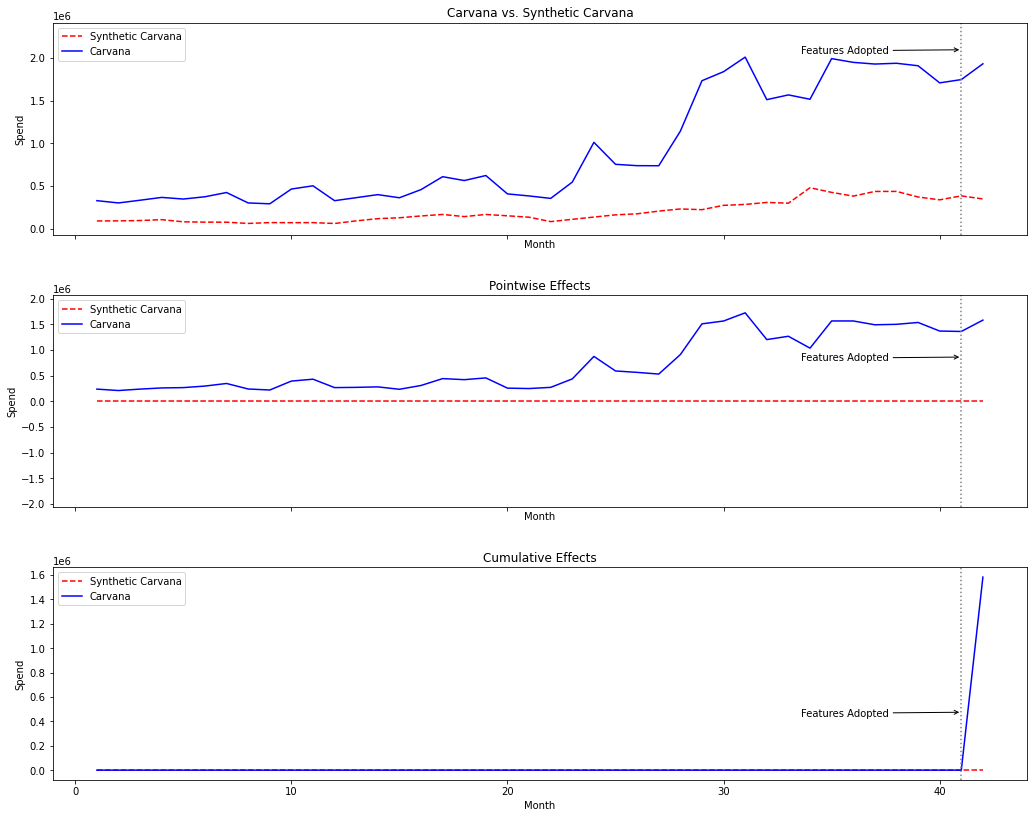

Controls and their weights:
             Name    Weight
16674  Parts Geek  0.145973
89792        TCAA  0.852891
Processing Customer # 7
Test Customer Id:17018321, Name:France Telecom España S.A.U, L1:Technology & Telecommunications, L2:Telecommunications, Segment:Enterprise, Country:Spain
Number of customers in the pool before excluding all treated customers and test months data : 160
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 117
Capping the number of customers to 100 as it exceeded
Data Set Shape: (4242, 5)


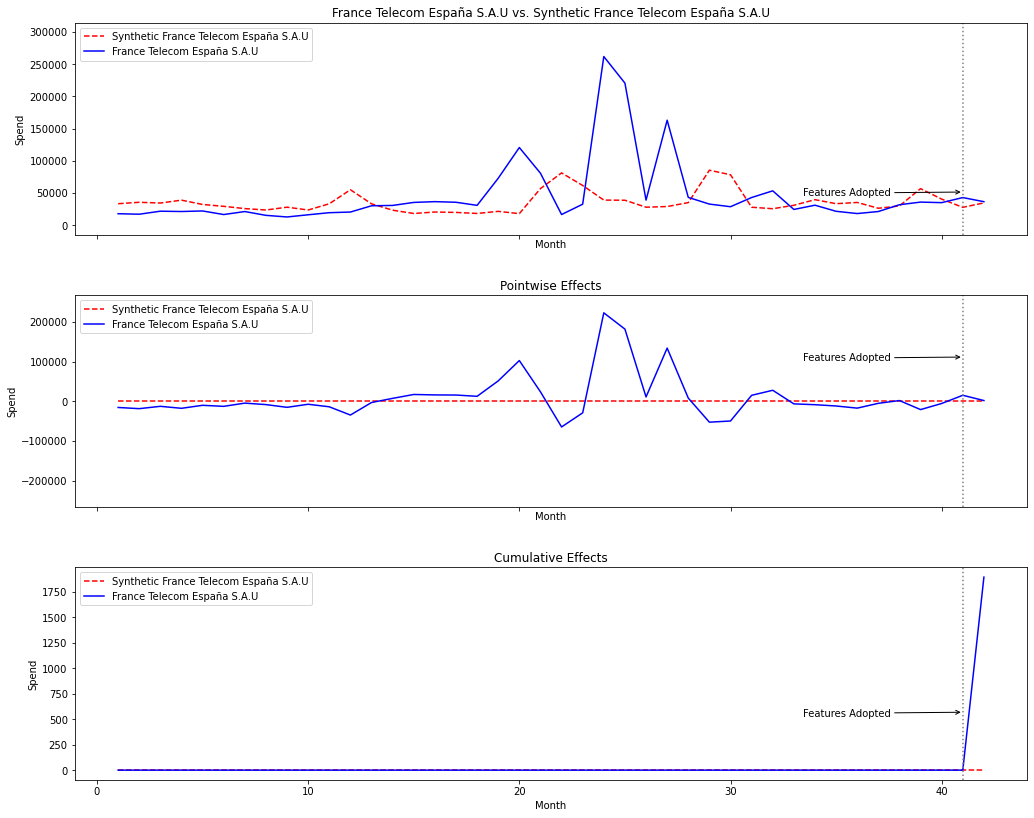

Controls and their weights:
                                                Name    Weight
655390    GetGo, Inc., a subsidiary of LogMeIn, Inc.  0.716209
17018110                        JAZZ TELECOM, S.A.U.  0.283791
Processing Customer # 8
Test Customer Id:168417317, Name:NJM Insurance Group, L1:Financial Services & Insurance, L2:Insurance, Segment:SMB, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 36098
Number of Months test data available: 42
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 1349
Capping the number of customers to 100 as it exceeded
Data Set Shape: (4242, 5)


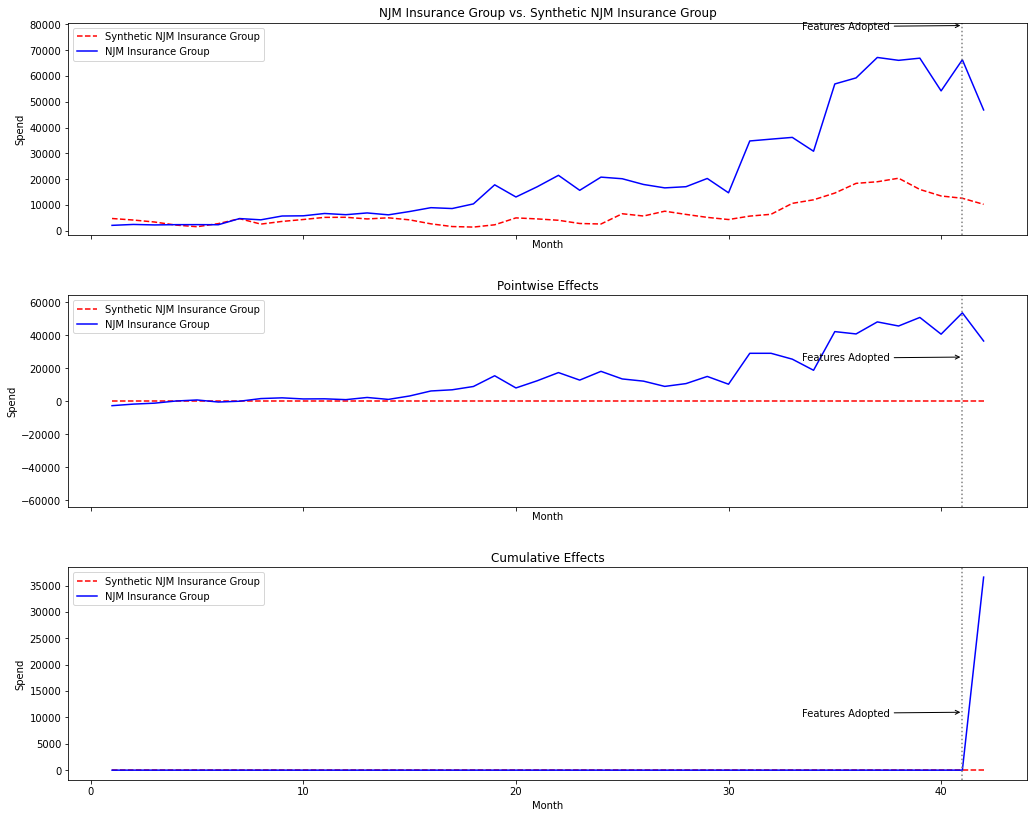

Controls and their weights:
                Name    Weight
8398  US Hole In One  0.819337
Processing Customer # 9
Test Customer Id:250913912, Name:Pintas & Mullins Law Firm, L1:B2C Services, L2:Legal Services, Segment:Enterprise, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 97
Number of Months test data available: 20
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 75
Data Set Shape: (1500, 5)


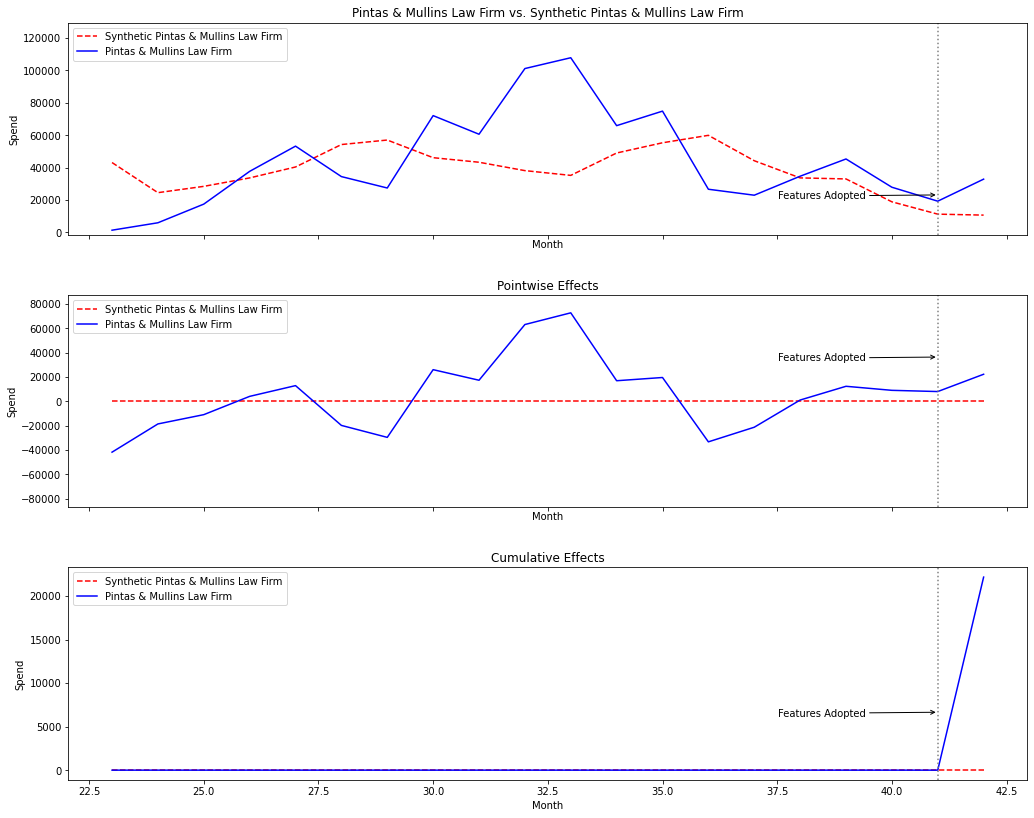

Controls and their weights:
               Name  Weight
406382  Essent - NL     1.0
Processing Customer # 10
Test Customer Id:251664079, Name:MapQuest, L1:Real Estate, L2:Properties for Sale, Segment:Corporate, Country:United States of America (the)
Number of customers in the pool before excluding all treated customers and test months data : 55
Number of Months test data available: 5
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 50
Data Set Shape: (250, 5)


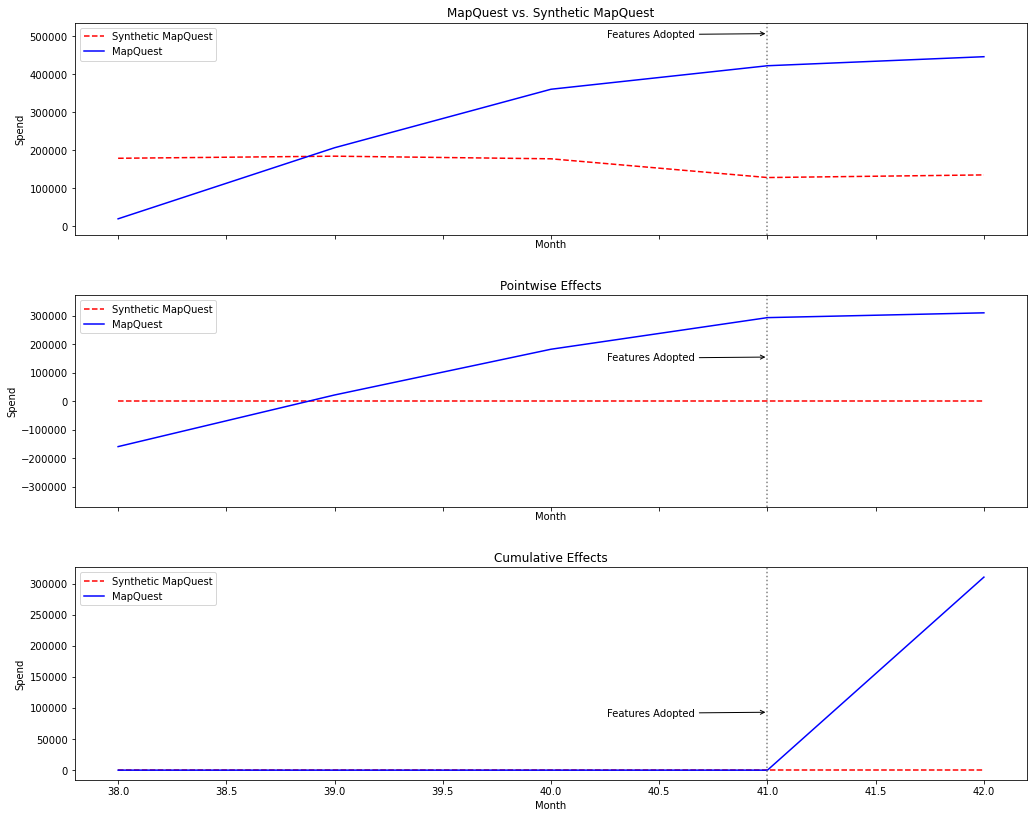

Controls and their weights:
                Name  Weight
163281146  Bsell.com     1.0
Processing Customer # 11
Test Customer Id:251822327, Name:GFM Retail Private Limited, L1:Restaurants & Food, L2:Food & Beverages, Segment:Channel Partner, Country:India
Number of customers in the pool before excluding all treated customers and test months data : 6701
Number of Months test data available: 2
Treatment Month: December2021
Number of customers in the pool after excluding all treated customers and test months data: 1328
Capping the number of customers to 100 as it exceeded
Data Set Shape: (200, 5)


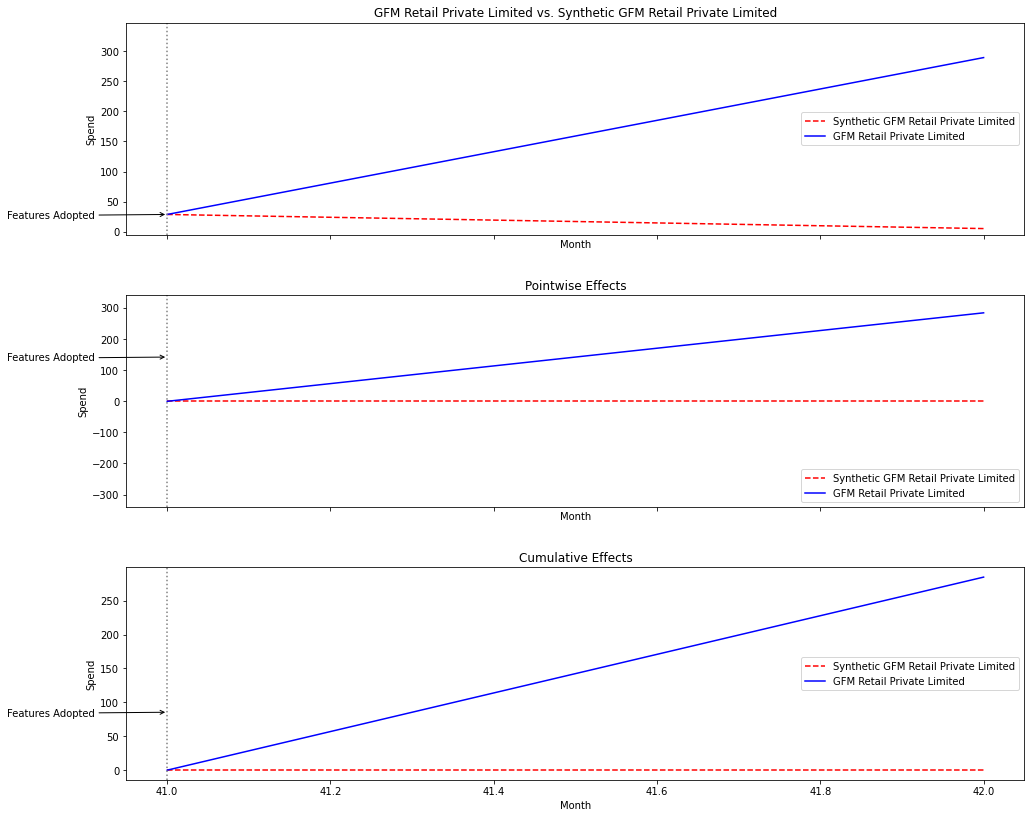

Controls and their weights:
                 Name    Weight
169947376    Net Urel  0.856099
251822264  Five Spice  0.143901
Wall time: 1min 54s


In [136]:
%%time
max_pool_cap = 100

#Next try with reducing the pool size and without L2 and country. This produced good results. Only 6 mappings are bad.
map_man_l2_con_df = retry_sc(retry_man_df,include_con=False, include_l2=False)

In [137]:
print_results()

Results df Shape: (37, 7) Error df Shape: (12, 5) Comparison df shape: (12, 14)
Number of Entries for which mappings are found: 12


In [138]:
len(no_ctrls_dict)

0

### Combine results
We need to drop existing mappings and add the refined mappings for these

In [139]:
display(len(map_man_l2_con_df[0].CID.unique()), map_man_l2_con_df[0].shape, cons_res_remaps_df.shape, 
        cons_res_remaps_df[cons_res_remaps_df.CID.isin(map_man_l2_con_df[0].CID.unique())].shape, 
        cons_res_remaps_df[~cons_res_remaps_df.CID.isin(map_man_l2_con_df[0].CID.unique())].shape
       )

12

(37, 7)

(101, 7)

(15, 7)

(86, 7)

In [140]:
# cons_res_remaps_df = cons_res_remaps_df[~cons_res_remaps_df.CID.isin(map_man_l2_con_df[0].CID.unique())]
display(cons_res_remaps_df.shape)

cons_res_remaps_df = combine_dfs(cons_res_remaps_df, map_man_l2_con_df[0])

display(cons_res_remaps_df.shape)

(101, 7)

(123, 7)

In [141]:
pool_cnts_df = pd.DataFrame(columns=['CID','Name','Month','Segment_Excluded','Pool_Count'])
for k,v in pool_counts_dict.items():
    temp_dict = {'CID':k[0],'Name':k[1],'Month':k[2],'Segment_Excluded':v[0],'Pool_Count':v[1]}
    pool_cnts_df = pool_cnts_df.append(temp_dict, ignore_index=True)

In [142]:
max(pool_counts_dict.values()), min(pool_counts_dict.values())

(('Segment', 102), ('', 2))

### Refine mappings with sum(weights)< 0.3 (Retry)

In [143]:
mappings_df = cons_res_remaps_df.copy()
mapping_weights = mappings_df.groupby(['Month','CID']).agg({'ControlWeight':['sum','count']}).reset_index()

In [144]:
mapping_weights

#Change Column Names for single index
mapping_weights.columns = ['Month', 'CID', 'ControlWeights_sum', 'Controls_count']

In [145]:
mapping_weights[mapping_weights.ControlWeights_sum<.3].sort_values(['ControlWeights_sum'])

Empty DataFrame
Columns: [Month, CID, ControlWeights_sum, Controls_count]
Index: []

In [146]:
mapping_weights[mapping_weights.ControlWeights_sum<.7].sort_values(['ControlWeights_sum']).shape

(0, 4)

In [147]:
mapping_weights_07 = mapping_weights[mapping_weights.ControlWeights_sum<.7].sort_values(['ControlWeights_sum'])
mapping_weights_07 = pd.merge(mapping_weights_07, pool_cnts_df, how='left', on=['CID','Month'])

In [148]:
mapping_weights_07.head(2)

Empty DataFrame
Columns: [ControlWeights_sum, Controls_count, CID, Name, Month, Segment_Excluded, Pool_Count]
Index: []

In [149]:
mapping_weights_07

Empty DataFrame
Columns: [ControlWeights_sum, Controls_count, CID, Name, Month, Segment_Excluded, Pool_Count]
Index: []

In [150]:
retry_wt_cids_df = mapping_weights_07[['CID','Month']]

In [151]:
retry_wt_cids_df.head(2)

Empty DataFrame
Columns: [CID, Month]
Index: []

In [152]:
retry_wt_cids_df.shape

(0, 2)

In [153]:
%%time
#Limiting the max cap to 100

max_pool_cap = 100
remap_wt_cids_df = retry_sc(retry_wt_cids_df)

Number of Customers to be processed: 0
Wall time: 7 ms


In [154]:
len(remap_wt_cids_df[0])

0

In [155]:
len(no_ctrls_dict)

0

In [156]:
if len(remap_wt_cids_df[0]) != 0:
    remapping_weights = remap_wt_cids_df[0].groupby(['Month','CID']).agg({'ControlWeight':['sum','count']}).reset_index()
    remapping_weights.columns = ['_'.join(col).strip() for col in remapping_weights.columns.values]
    remapping_weights.columns = ['Month', 'CID', 'ControlWeights_sum', 'Controls_count']

In [157]:
remap_wt_cids_df[0].shape

(0, 7)

In [158]:
len(remap_wt_cids_df[0].CID.unique()), retry_wt_cids_df.shape, len(retry_wt_cids_df.CID.unique())

(0, (0, 2), 0)

### Combine results into refined df

In [159]:
#Combine
# cons_res_refined_df = cons_res_remaps_df.append(remap_wt_cids_df[0]) 
cons_res_refined_df = combine_dfs(cons_res_remaps_df, remap_wt_cids_df[0])


In [160]:
cons_res_refined_df.shape, cons_res_remaps_df.shape, remap_wt_cids_df[0].shape

((123, 7), (123, 7), (0, 7))

In [161]:
#Write the combined refined mappings to a file. 
cons_res_refined_df.to_excel(op_path+'Cons_Mappings_Refined.xlsx', index=False)

In [162]:
pool_cnts_df.to_excel(op_path+'Cons_Pool_Counts.xlsx',index=False)

In [163]:
#Final CIDs for which we couldn't find any mappings. Remove the CIDs = No Controls CIDS minus all cids with mappings found
final_no_ctrls_df = no_ctrls_df[~no_ctrls_df.CID.isin(cons_res_refined_df.CID)]
final_no_ctrls_df.to_excel(op_path+'Cons_No_Mapping.xlsx',index=False)

### Consolidate Files and Add L1, L2 and Segment

In [164]:
dim_df.shape, len(dim_df.CID.unique())

((942951, 6), 942951)

In [165]:
cons_all_df = cons_res_refined_df.copy()

#Add Month number column for easy sorting
cons_all_df['Month_Num'] = cons_all_df.Month.map(dt_map)

cons_all_df.shape

(123, 8)

In [166]:
dim_df.shape

(942951, 6)

In [167]:
dim_df_subset = dim_df[dim_df.CID.isin(list(cons_all_df.CID.unique()) + list(cons_all_df.ControlCID.unique()) )]
dim_df_subset.shape, len(dim_df_subset.CID.unique())

((49, 6), 49)

In [168]:
#Prepare dim_df for getting segment, L1, L2
#Segment to be fethced for both test and control customers
dim_df_seg = dim_df_subset[['CID','Segment']].drop_duplicates()
dim_df_subset = dim_df_subset[dim_df_subset.CID.isin(cons_all_df.CID.unique())]
#L1, L2 to be fetched for only test customers
dim_df_l1l2 = dim_df_subset[['CID','L1','L2']].drop_duplicates()
dim_df_con = dim_df_subset[['CID','Country']].drop_duplicates()
dim_df_seg.shape, dim_df_l1l2.shape, dim_df_con.shape

((49, 2), (49, 3), (49, 2))

In [169]:
#Drop duplicates and keep first record only
dim_df_l1l2 = dim_df_l1l2.drop_duplicates(subset='CID',keep='first')
dim_df_seg = dim_df_seg.drop_duplicates(subset='CID',keep='first')
dim_df_con = dim_df_con.drop_duplicates(subset='CID',keep='first')
dim_df_seg.shape, dim_df_l1l2.shape, dim_df_con.shape

((49, 2), (49, 3), (49, 2))

In [170]:
#Add test customer Segment, L1, L2
cons_all_df = pd.merge(cons_all_df, dim_df_l1l2, how='left', on='CID')
cons_all_df = pd.merge(cons_all_df, dim_df_seg, how='left', on='CID')
cons_all_df = pd.merge(cons_all_df, dim_df_con, how='left', on='CID')
cons_all_df.shape

(123, 12)

In [171]:
cons_all_df.head(2)

CID      Name         Month ControlCID                          ControlName  \
0   3  Lexus US  December2021     671423  Jaguar Land Rover North America LLC   
1   3  Lexus US  December2021    7008393          Toyota Motor Sales Inc. USA   

   ControlWeight Excludes  Month_Num     L1                     L2  \
0        0.83233                  42  Autos  Tier 1 - OEM/National   
1        0.16767                  42  Autos  Tier 1 - OEM/National   

      Segment                         Country  
0  Enterprise  United States of America (the)  
1  Enterprise  United States of America (the)

In [172]:
get_null_cnts(cons_all_df,0)

Series([], dtype: int64)

In [173]:
cons_all_df['ControlCID'] = cons_all_df.ControlCID.astype(int)

In [174]:
#Add Control Customer Segment
cons_all_df = pd.merge(cons_all_df, dim_df_seg, how='left', left_on='ControlCID', right_on='CID',)
cons_all_df.shape

(123, 14)

In [175]:
cons_all_df.head(2)

CID_x      Name         Month  ControlCID  \
0     3  Lexus US  December2021      671423   
1     3  Lexus US  December2021     7008393   

                           ControlName  ControlWeight Excludes  Month_Num  \
0  Jaguar Land Rover North America LLC        0.83233                  42   
1          Toyota Motor Sales Inc. USA        0.16767                  42   

      L1                     L2   Segment_x                         Country  \
0  Autos  Tier 1 - OEM/National  Enterprise  United States of America (the)   
1  Autos  Tier 1 - OEM/National  Enterprise  United States of America (the)   

   CID_y Segment_y  
0    NaN       NaN  
1    NaN       NaN

In [176]:
#Rename columns appropriately
cons_all_df =cons_all_df.rename(columns={'CID_x':'CID', 'Segment_x':'Segment', 'Segment_y':'ControlSegment' })

#sort the data
cons_all_df = cons_all_df.sort_values(['Month_Num','CID','ControlCID'])

#Drop unnecessary columns 
cons_all_df = cons_all_df.drop(columns=['CID_y','Month_Num'])

In [177]:
cons_all_df.columns

Index(['CID', 'Name', 'Month', 'ControlCID', 'ControlName', 'ControlWeight',
       'Excludes', 'L1', 'L2', 'Segment', 'Country', 'ControlSegment'],
      dtype='object')

In [178]:
cons_all_df = cons_all_df[['Month', 'CID', 'Name', 'L1', 'L2', 'Segment','Country', 'ControlCID',
       'ControlName', 'ControlWeight', 'ControlSegment','Excludes']]

In [179]:
cons_all_df.shape

(123, 12)

In [180]:
cons_all_df.to_excel(op_path+'Cons_Mappings_Refined_Details.xlsx', index=False)

In [181]:
cons_all_df.Month.value_counts()

December2021    123
Name: Month, dtype: int64

## Check mappings

#### Draw historical trend plots for the mappings we found above.

In [182]:
def plot_trends(mappings_df_):
    for CID in mappings_df_.CID.unique():
        treated = sc_df[sc_df.CID==CID]
        treated = treated[['Month','CID','Spend']]
        treated = treated.set_index('Month')

        ctrls = mappings_df_[mappings_df_.CID==CID][['ControlCID','ControlWeight']]
        ctrls_df = treated.copy()
        ctrls_df['CID'] = 'Synthetic ' + str(CID)
        ctrls_df['Spend'] = 0

        for row in ctrls.itertuples():
            ctrl_id, ctrl_wt = row[1], row[2]
        #     print(ctrl_id, ctrl_wt)
            ctrl_spend = sc_df[sc_df.CID == ctrl_id][['Month','Spend']]
            ctrl_spend = ctrl_spend.set_index('Month')
            ctrls_df['Spend'] = ctrls_df['Spend'] +(ctrl_spend*ctrl_wt)['Spend']

        comb_df = treated.append(ctrls_df)
        comb_df = comb_df.reset_index()

        print('CID:',CID, ', Controls Length:', len(ctrls))
        print('Controls:',list(ctrls.ControlCID), ', Controls Length:', list(ctrls.ControlWeight))
        plt.figure(figsize = (14,3))
        sns.lineplot(x='Month', y='Spend', data=comb_df, hue='CID')
        plt.show()

## Plot Trends Manually

In [183]:
mappings_df = cons_all_df.copy()
mappings_df = mappings_df.sort_values('CID')

CID: 3 , Controls Length: 2
Controls: [671423, 7008393] , Controls Length: [0.8323297934021208, 0.16767020659787926]


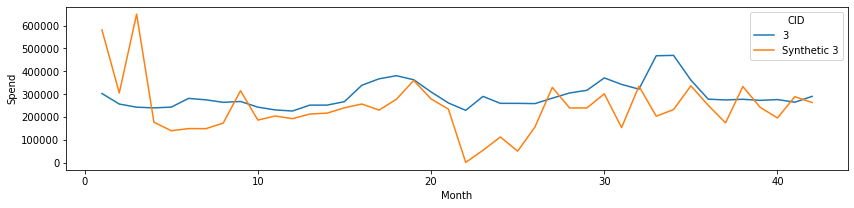

CID: 20 , Controls Length: 2
Controls: [319, 2024] , Controls Length: [0.6678251546832258, 0.332174845316774]


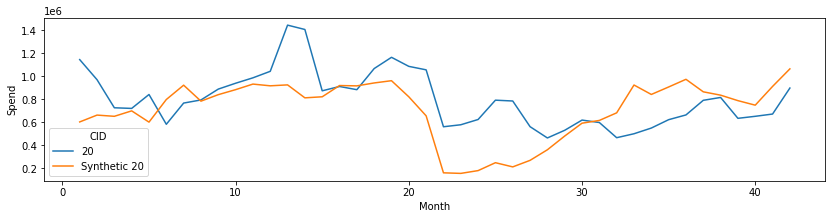

CID: 191 , Controls Length: 1
Controls: [212] , Controls Length: [0.9999999999999999]


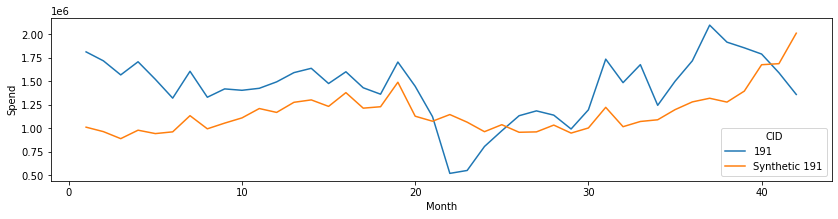

CID: 690 , Controls Length: 2
Controls: [661018, 1054393] , Controls Length: [0.3118020176917518, 0.6881979823082479]


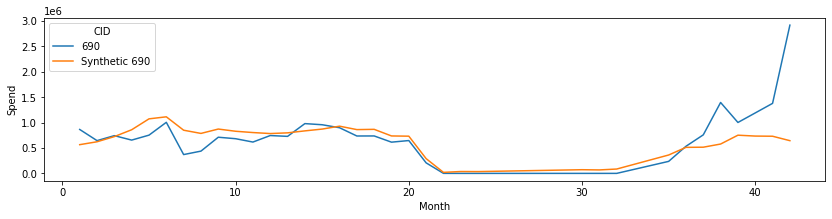

CID: 698 , Controls Length: 1
Controls: [7541] , Controls Length: [1.0]


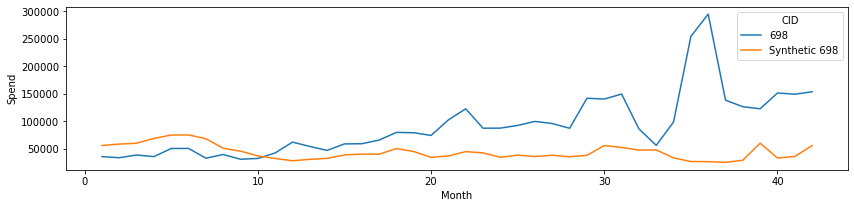

CID: 1795 , Controls Length: 3
Controls: [11057145, 350519, 10398] , Controls Length: [0.8221855703417238, 0.13224965182322745, 0.04556477783504852]


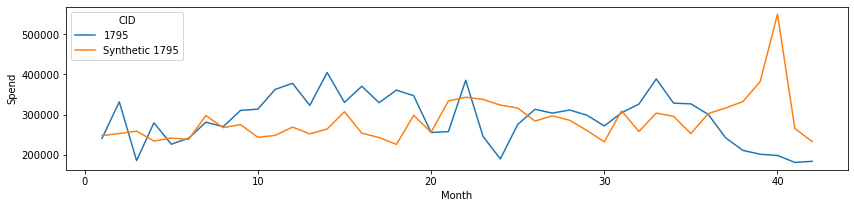

CID: 1962 , Controls Length: 20
Controls: [14282085, 14069264, 13233221, 12279111, 12076229, 11212434, 7065461, 7055647, 6017781, 162434174, 2075226, 180, 15658, 33703, 54883, 5140403, 563300, 2015783, 2047563, 100734] , Controls Length: [0.05740985811478849, 0.01776005662225203, 0.011863712063956807, 0.013660020319221231, 0.08750961406385821, 0.02748552256268038, 0.0159738101872734, 0.01561397497476456, 0.01913555920926218, 0.06700817121738156, 0.24949613233527507, 0.013735915039084789, 0.01733808110923014, 0.014840019486563024, 0.03874257910405208, 0.010938571320601845, 0.011755277118543375, 0.04415858792083866, 0.024375557948835582, 0.04282307790660646]


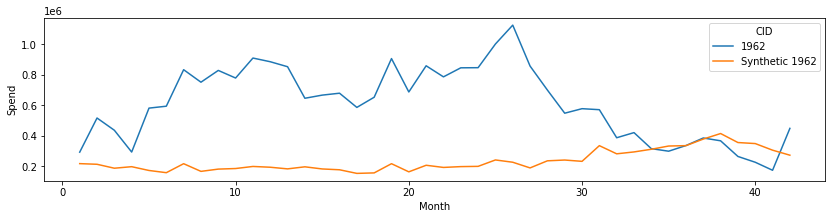

CID: 2214 , Controls Length: 1
Controls: [21] , Controls Length: [1.0]


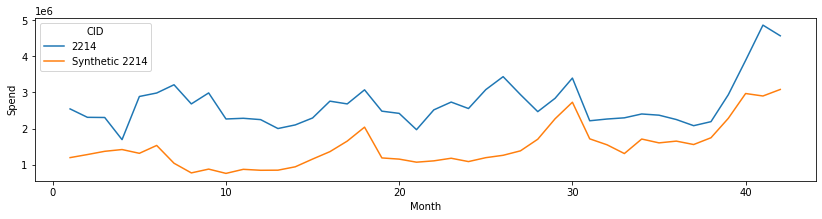

CID: 2409 , Controls Length: 1
Controls: [854033] , Controls Length: [1.0]


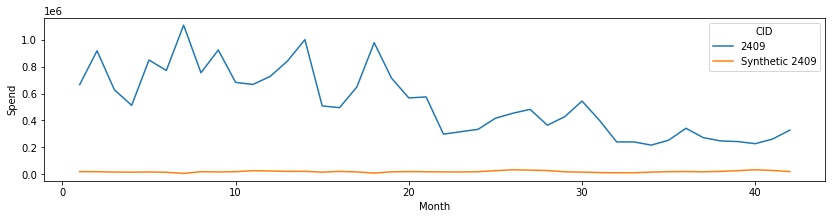

CID: 2426 , Controls Length: 1
Controls: [489] , Controls Length: [1.0]


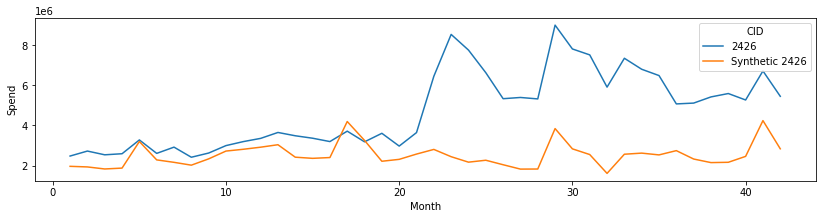

CID: 4289 , Controls Length: 3
Controls: [43076, 13088160, 159310828] , Controls Length: [0.2048102065799154, 0.7029584307446032, 0.09223136267548146]


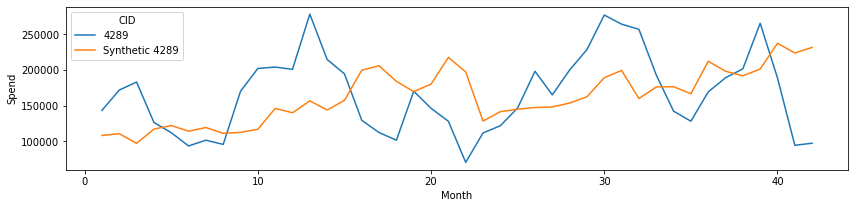

CID: 7509 , Controls Length: 1
Controls: [4569] , Controls Length: [1.0000000000000002]


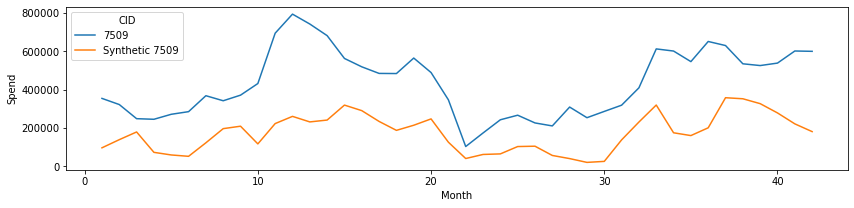

CID: 11389 , Controls Length: 3
Controls: [350519, 10398, 11057145] , Controls Length: [0.5440311518712719, 0.3016249367956855, 0.15434391133304254]


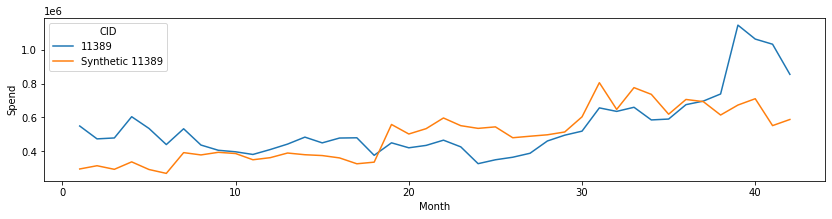

CID: 12767 , Controls Length: 1
Controls: [854033] , Controls Length: [1.0]


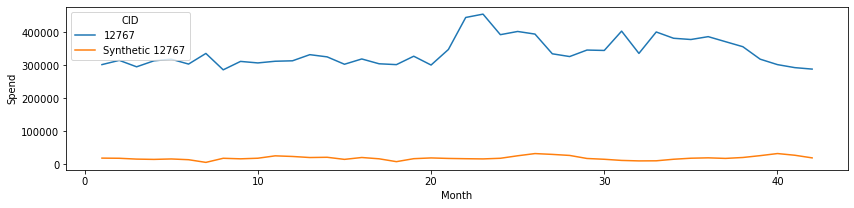

CID: 17850 , Controls Length: 2
Controls: [2069431, 168422752] , Controls Length: [0.3074866176526475, 0.6925133823473524]


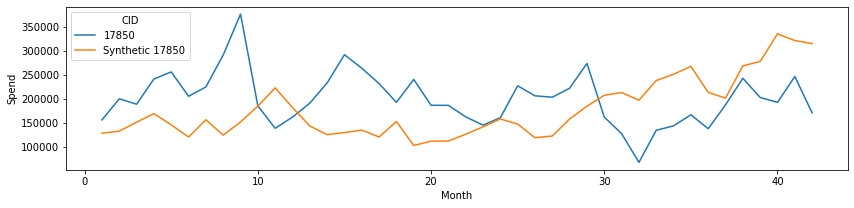

CID: 19645 , Controls Length: 3
Controls: [256873, 492414, 557798] , Controls Length: [0.5823136083992763, 0.2648390848036452, 0.15284730679707834]


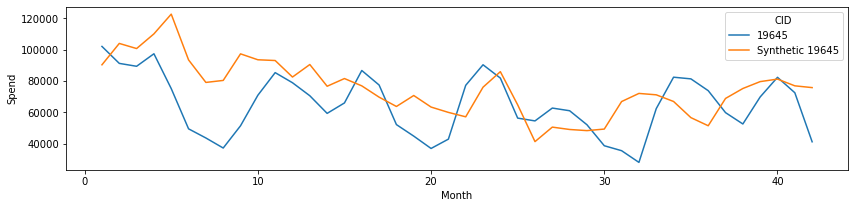

CID: 20674 , Controls Length: 3
Controls: [256873, 264768, 492414] , Controls Length: [0.2824594328660407, 0.4727500845771129, 0.24479048255684605]


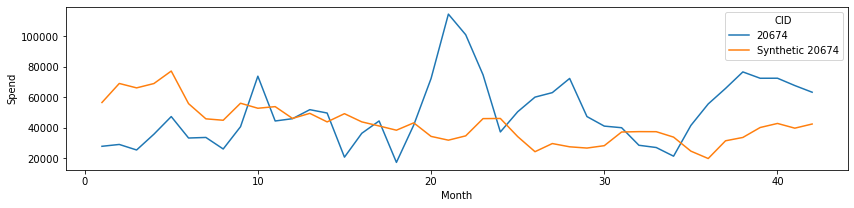

CID: 37680 , Controls Length: 2
Controls: [3013237, 54342] , Controls Length: [0.6288193432885351, 0.3711806567114641]


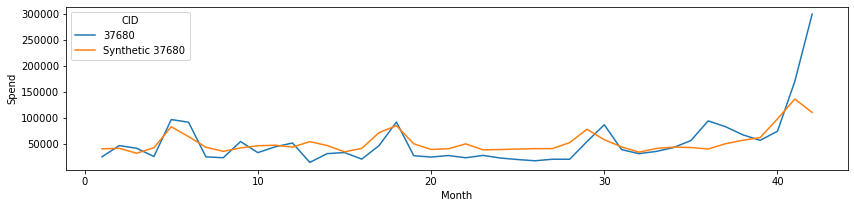

CID: 41460 , Controls Length: 1
Controls: [2197] , Controls Length: [1.0000000000000004]


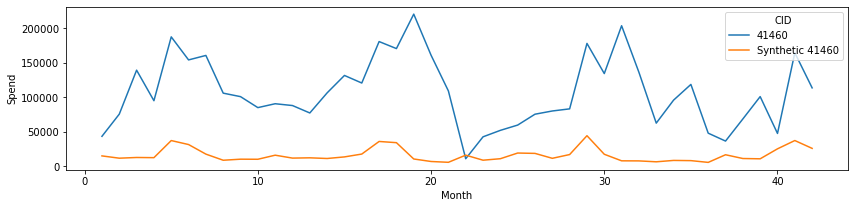

CID: 47840 , Controls Length: 2
Controls: [54342, 15262102] , Controls Length: [0.5209650209219374, 0.4790349790780624]


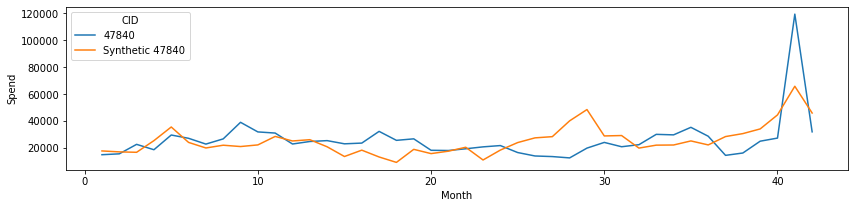

CID: 181912 , Controls Length: 1
Controls: [11401601] , Controls Length: [1.0]


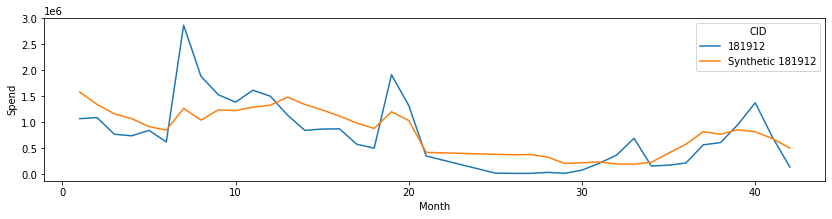

CID: 194086 , Controls Length: 1
Controls: [14185237] , Controls Length: [1.0000000000000002]


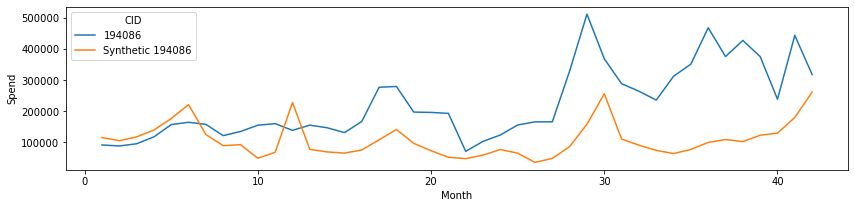

CID: 661650 , Controls Length: 2
Controls: [6344, 14098218] , Controls Length: [0.35347456157990936, 0.6465254384200902]


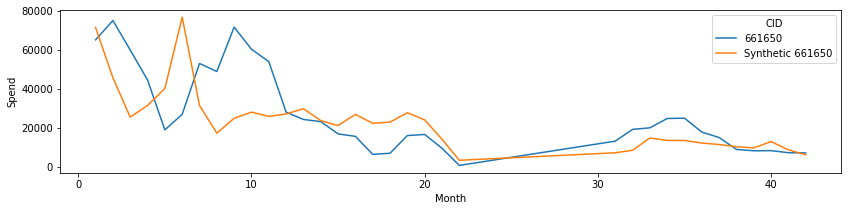

CID: 662587 , Controls Length: 2
Controls: [5043087, 10398] , Controls Length: [0.46984429301182373, 0.5301557069881762]


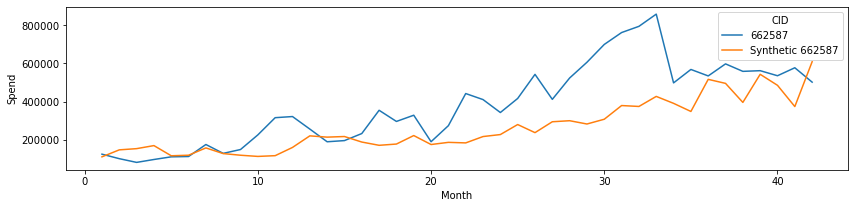

CID: 771818 , Controls Length: 2
Controls: [11229635, 43076] , Controls Length: [0.7459591219962968, 0.2540408780037024]


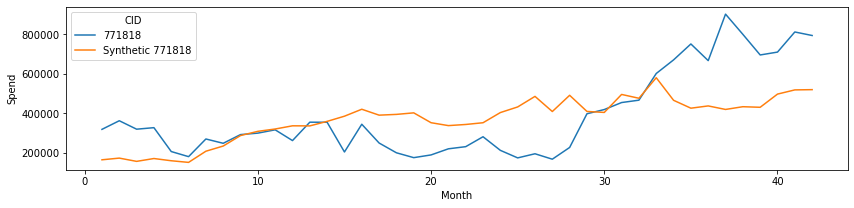

CID: 5057990 , Controls Length: 2
Controls: [12829, 14445975] , Controls Length: [0.09016024015963423, 0.9098397598403659]


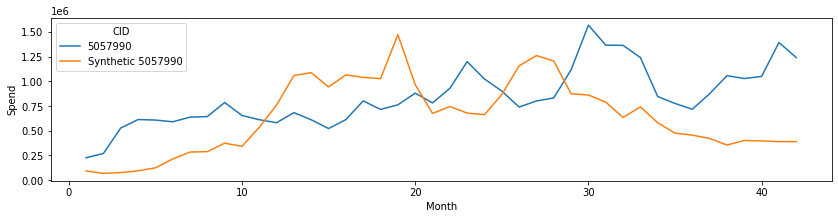

CID: 5127122 , Controls Length: 1
Controls: [42188868] , Controls Length: [0.9999999999999998]


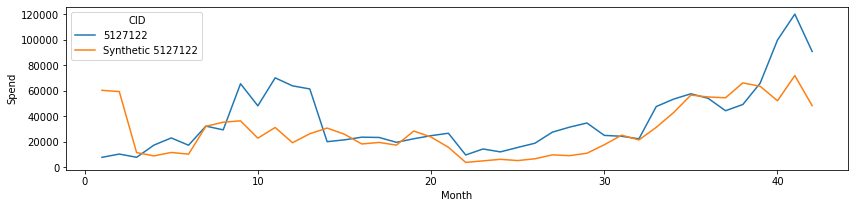

CID: 5143439 , Controls Length: 2
Controls: [890453, 11019043] , Controls Length: [0.679588342004296, 0.3204116579957031]


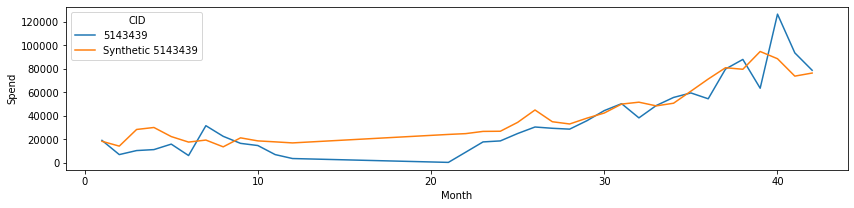

CID: 7021885 , Controls Length: 2
Controls: [856826, 36198985] , Controls Length: [0.629016496635849, 0.37098350336415065]


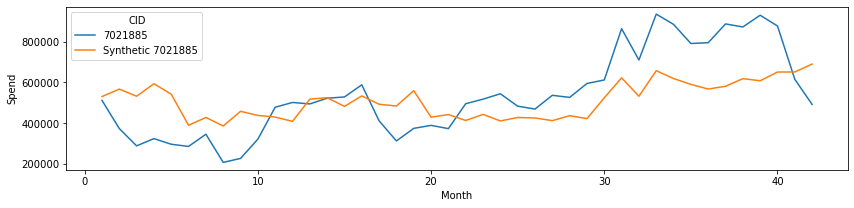

CID: 11000768 , Controls Length: 2
Controls: [13078498, 50175757] , Controls Length: [0.7113949211790714, 0.28860507882092823]


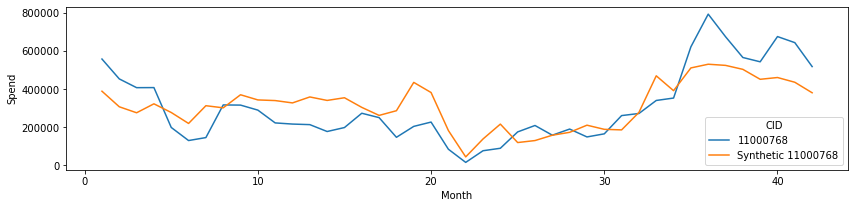

CID: 11061936 , Controls Length: 1
Controls: [18005626] , Controls Length: [0.9999999999999999]


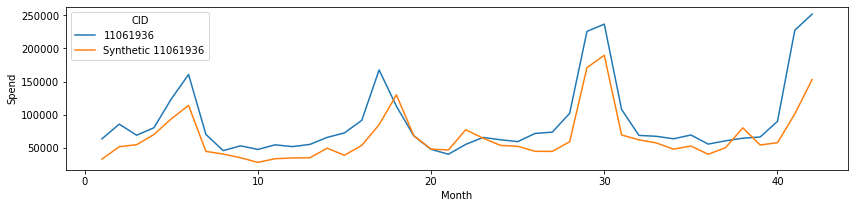

CID: 11229616 , Controls Length: 2
Controls: [89792, 16674] , Controls Length: [0.8528912215995342, 0.14597327902116336]


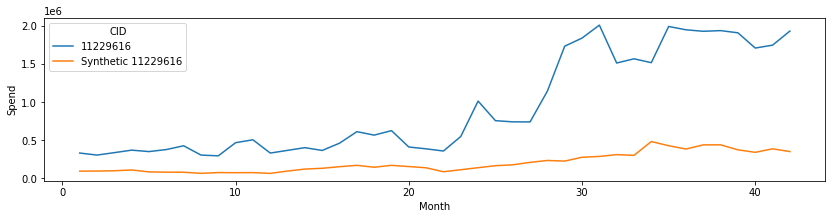

CID: 11244132 , Controls Length: 3
Controls: [15039, 48509, 25190097] , Controls Length: [0.5552573549171632, 0.17562558724173086, 0.269117057841106]


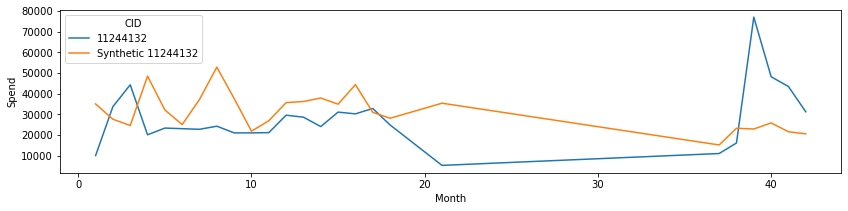

CID: 12095858 , Controls Length: 1
Controls: [60581] , Controls Length: [1.0000000000000002]


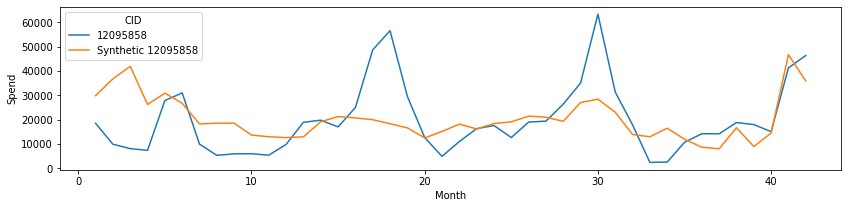

CID: 12125683 , Controls Length: 16
Controls: [11119318, 160434087, 21130500, 14026087, 13088947, 12236769, 6021478, 18165163, 4052053, 1718, 53658, 60936, 4069521, 278714, 4042947, 177190] , Controls Length: [0.052430905442644817, 0.020629905540896686, 0.09199004663460636, 0.010492446901784238, 0.03394967487832274, 0.02042738678712519, 0.039906685692349425, 0.46519759225371715, 0.025803745978915327, 0.01894407367304767, 0.029712330620206368, 0.030811528868001047, 0.029121958593376088, 0.03823111121536365, 0.012886730713029378, 0.050598323535225004]


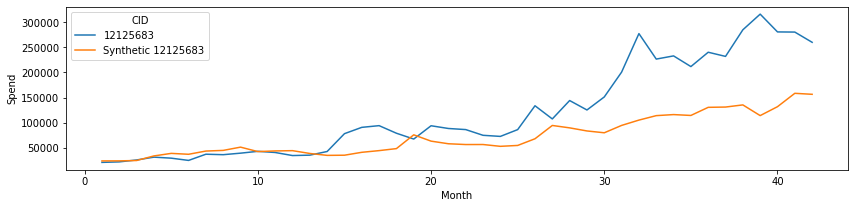

CID: 12174608 , Controls Length: 1
Controls: [36128827] , Controls Length: [1.0000000000000002]


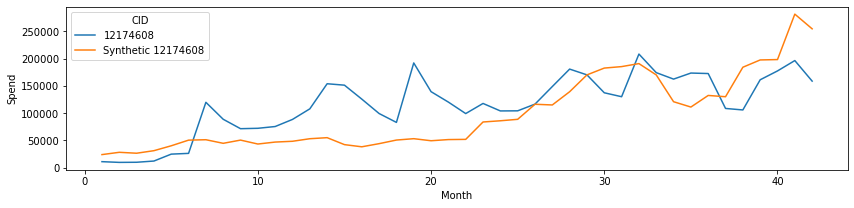

CID: 14049925 , Controls Length: 2
Controls: [13074, 43224] , Controls Length: [0.5540311202826517, 0.4459688797173483]


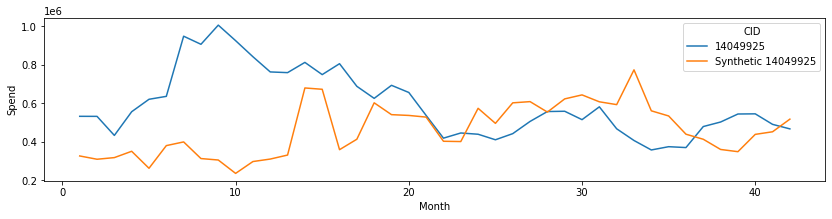

CID: 14102189 , Controls Length: 2
Controls: [524875, 886119] , Controls Length: [0.4402099513062127, 0.559790048693787]


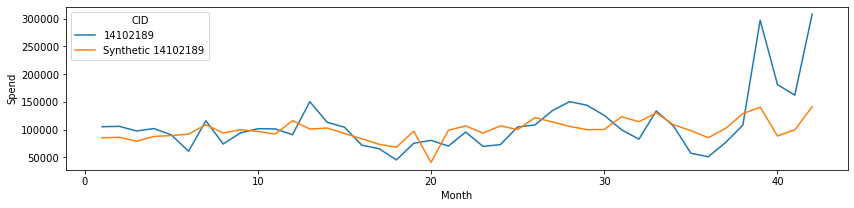

CID: 17018321 , Controls Length: 2
Controls: [655390, 17018110] , Controls Length: [0.7162089256736894, 0.28379107432631034]


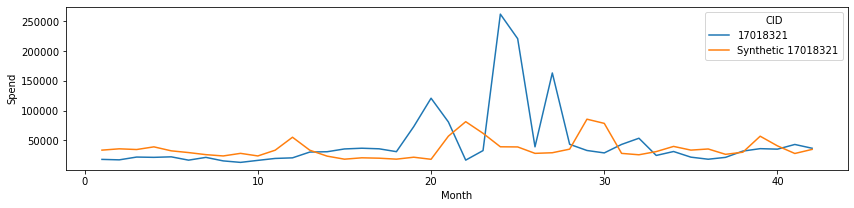

CID: 17101857 , Controls Length: 2
Controls: [12021367, 11143709] , Controls Length: [0.04336668929821857, 0.9566333107017814]


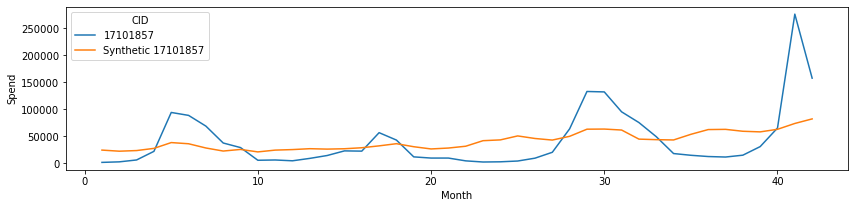

CID: 50168202 , Controls Length: 2
Controls: [11231090, 559499] , Controls Length: [0.69560139698166, 0.30439860301834004]


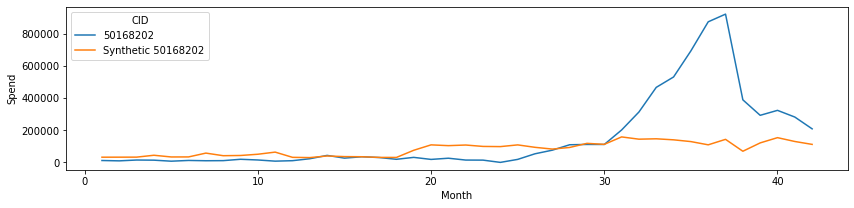

CID: 163219202 , Controls Length: 1
Controls: [250568307] , Controls Length: [1.0000000000000002]


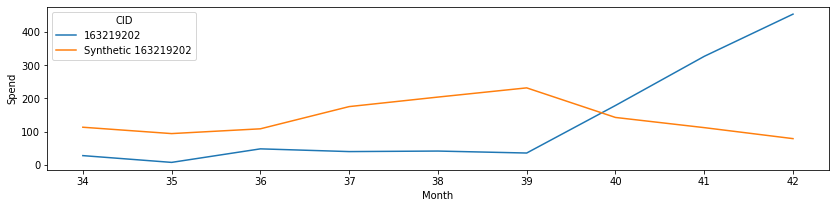

CID: 168417317 , Controls Length: 1
Controls: [8398] , Controls Length: [0.8193372088648692]


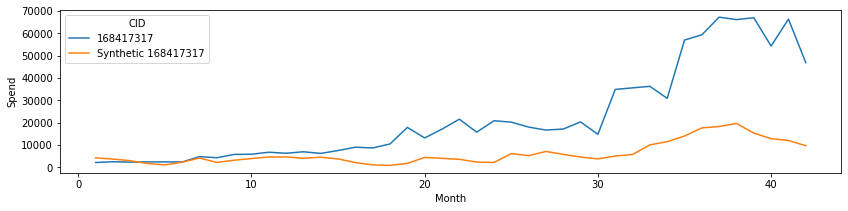

CID: 250317108 , Controls Length: 1
Controls: [159422438] , Controls Length: [1.0000000000000002]


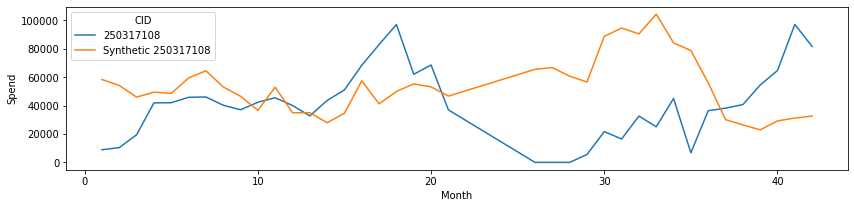

CID: 250913912 , Controls Length: 1
Controls: [406382] , Controls Length: [1.0000000000000002]


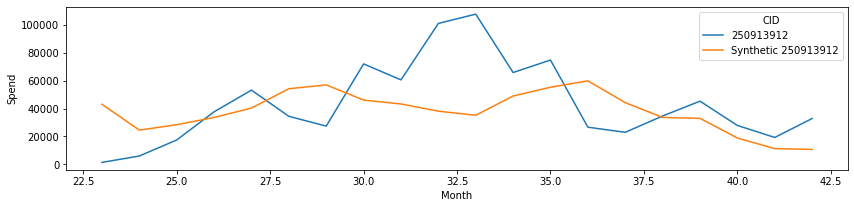

CID: 251664079 , Controls Length: 1
Controls: [163281146] , Controls Length: [0.9999999999999998]


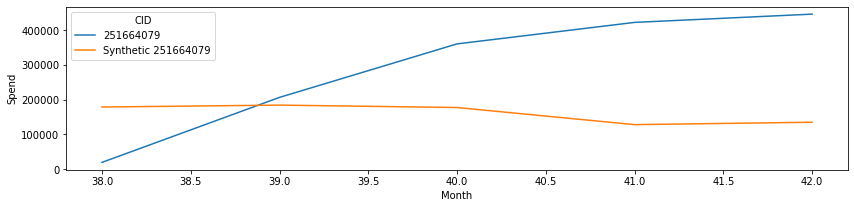

CID: 251680205 , Controls Length: 1
Controls: [410795] , Controls Length: [1.0000000000000002]


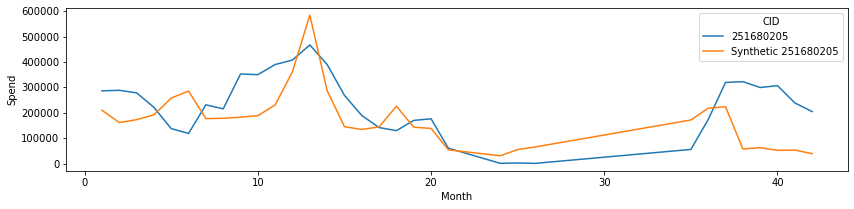

CID: 251757767 , Controls Length: 9
Controls: [251443703, 250642501, 169928951, 168941682, 158133944, 160426759, 42111767, 19000636, 163279840] , Controls Length: [0.29515252371870393, 0.02807190352448687, 0.02538479475990527, 0.055100313583251445, 0.0513588512225695, 0.037129478146981955, 0.02789135700523644, 0.2189319768357913, 0.05151050226254696]


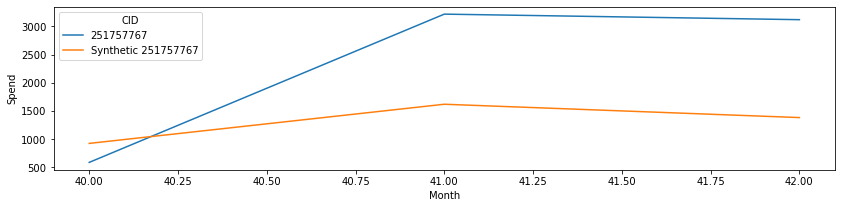

CID: 251822327 , Controls Length: 2
Controls: [169947376, 251822264] , Controls Length: [0.8560990388415916, 0.14390096115840853]


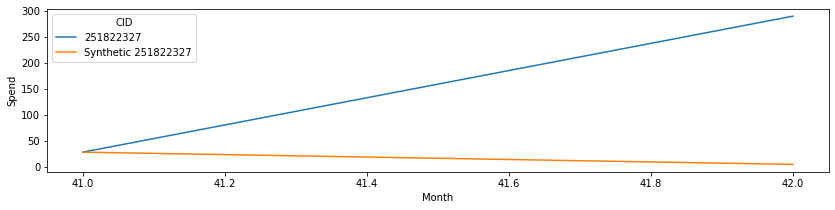

Wall time: 15.1 s


In [184]:
%%time
plot_trends(mappings_df)

In [185]:
no_ctrls_df.shape

(2, 4)

In [186]:
no_ctrls_df

CID                     Name         Month                    Reason
0   17101857             Canada Goose  December2021  No Customers in the pool
1  251680205  Tripadvisor Experiences  December2021  No Customers in the pool